In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from ml_features.features import create_features

import warnings
warnings.filterwarnings('ignore')

# Load data
df_quotes = pd.read_csv('cleaned_quote_data.csv')
df_quotes['dt_creation_devis'] = pd.to_datetime(df_quotes['dt_creation_devis'])
df_quotes['dt_signature_devis'] = pd.to_datetime(df_quotes['dt_signature_devis'])


# create_features(df_quotes)
# new_df = pd.read_csv('customer_features.csv')

In [2]:
# %% [markdown]
# # HVAC France Conversion Simulation POC
# 
# **Objective**: Demonstrate how conversion probability changes when modifying customer properties
# **Method**: Time-aware split (95%/5%), train on past, simulate on "future" customers
# 
# ---
# 
# ## Part 1: Setup & Data Preparation

# %%
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import random
import pickle
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.3f}'.format)

print("✅ Libraries imported")

✅ Libraries imported


CUSTOMER TIMELINE ANALYSIS
📅 Overall Timeline:
  First quote: 2023-01-02
  Last quote: 2026-01-22
  Total days: 1116
  Total quotes: 34,014
  Total customers: 23,888

📊 Customer Statistics:
  Avg quotes per customer: 1.4
  Median quotes per customer: 1.0
  Avg quote span (days): 18.6
  Conversion rate: 39.59%

📈 Quote Distribution by Month:
  Peak month: 2025-10 with 1,694 quotes
  Slowest month: 2023-08 with 326 quotes


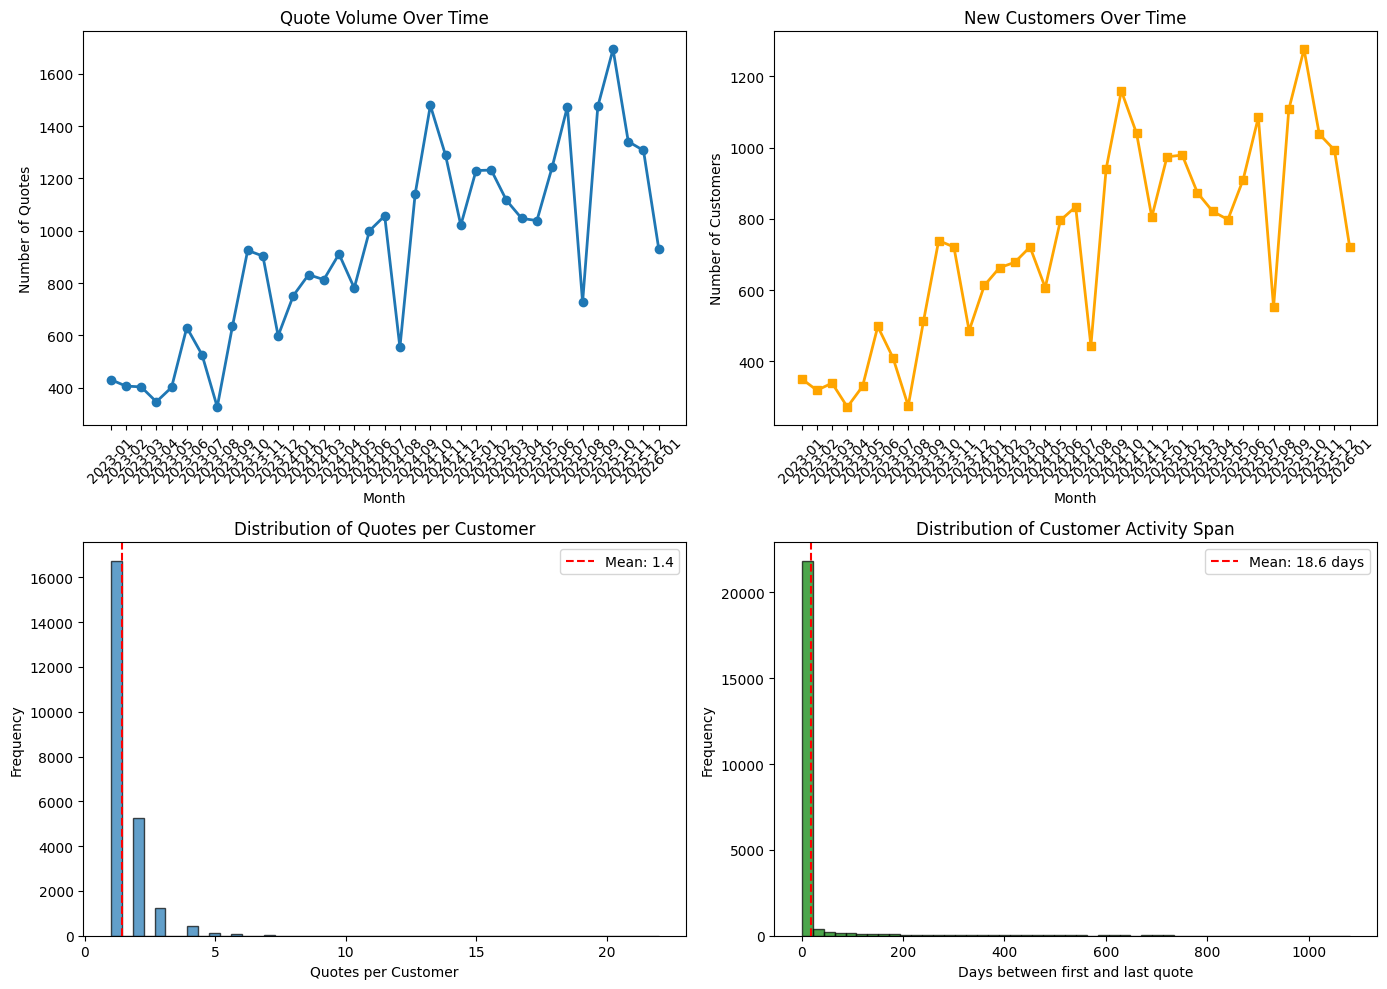

In [3]:
# %% [markdown]
# ### DATA ANALYSIS FOR SPLIT DECISION

# %%
print("=" * 80)
print("CUSTOMER TIMELINE ANALYSIS")
print("=" * 80)

# 1. Basic timeline analysis
df_quotes_sorted = df_quotes.copy()
df_quotes_sorted['dt_creation_devis'] = pd.to_datetime(df_quotes_sorted['dt_creation_devis'], errors='coerce')
df_quotes_sorted = df_quotes_sorted.sort_values('dt_creation_devis')

print("📅 Overall Timeline:")
print(f"  First quote: {df_quotes_sorted['dt_creation_devis'].min().date()}")
print(f"  Last quote: {df_quotes_sorted['dt_creation_devis'].max().date()}")
print(f"  Total days: {(df_quotes_sorted['dt_creation_devis'].max() - df_quotes_sorted['dt_creation_devis'].min()).days}")
print(f"  Total quotes: {len(df_quotes_sorted):,}")
print(f"  Total customers: {df_quotes_sorted['numero_compte'].nunique():,}")

# 2. Customer quote distribution
customer_stats = df_quotes_sorted.groupby('numero_compte').agg({
    'dt_creation_devis': ['min', 'max', 'count'],
    'fg_devis_accepte': 'max'  # Did they ever convert?
}).round(2)

customer_stats.columns = ['first_quote', 'last_quote', 'quote_count', 'converted']
customer_stats['quote_span_days'] = (customer_stats['last_quote'] - customer_stats['first_quote']).dt.days

print(f"\n📊 Customer Statistics:")
print(f"  Avg quotes per customer: {customer_stats['quote_count'].mean():.1f}")
print(f"  Median quotes per customer: {customer_stats['quote_count'].median():.1f}")
print(f"  Avg quote span (days): {customer_stats['quote_span_days'].mean():.1f}")
print(f"  Conversion rate: {customer_stats['converted'].mean():.2%}")

# 3. Quote distribution over time
print(f"\n📈 Quote Distribution by Month:")
df_quotes_sorted['quote_month'] = df_quotes_sorted['dt_creation_devis'].dt.to_period('M')
monthly_counts = df_quotes_sorted.groupby('quote_month').size()
monthly_customers = df_quotes_sorted.groupby('quote_month')['numero_compte'].nunique()

print(f"  Peak month: {monthly_counts.idxmax()} with {monthly_counts.max():,} quotes")
print(f"  Slowest month: {monthly_counts.idxmin()} with {monthly_counts.min():,} quotes")

# 4. Visualize quote timeline
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Quote volume over time
axes[0, 0].plot(monthly_counts.index.astype(str), monthly_counts.values, marker='o', linewidth=2)
axes[0, 0].set_title('Quote Volume Over Time')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Number of Quotes')
axes[0, 0].tick_params(axis='x', rotation=45)

# Plot 2: Customer volume over time
axes[0, 1].plot(monthly_customers.index.astype(str), monthly_customers.values, marker='s', color='orange', linewidth=2)
axes[0, 1].set_title('New Customers Over Time')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Number of Customers')
axes[0, 1].tick_params(axis='x', rotation=45)

# Plot 3: Quote count distribution
axes[1, 0].hist(customer_stats['quote_count'], bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Distribution of Quotes per Customer')
axes[1, 0].set_xlabel('Quotes per Customer')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(customer_stats['quote_count'].mean(), color='red', linestyle='--', label=f'Mean: {customer_stats["quote_count"].mean():.1f}')
axes[1, 0].legend()

# Plot 4: Quote span distribution
axes[1, 1].hist(customer_stats['quote_span_days'].fillna(0), bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1, 1].set_title('Distribution of Customer Activity Span')
axes[1, 1].set_xlabel('Days between first and last quote')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].axvline(customer_stats['quote_span_days'].mean(), color='red', linestyle='--', label=f'Mean: {customer_stats["quote_span_days"].mean():.1f} days')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

In [4]:
# %% [markdown]
# ### COMPARE DIFFERENT SPLIT APPROACHES

# %%
print("=" * 80)
print("SPLIT APPROACH COMPARISON")
print("=" * 80)

# Define split date for 95%/5% by time
split_date = df_quotes_sorted['dt_creation_devis'].quantile(0.95)
print(f"Split date (95th percentile by time): {split_date.date()}\n")

# Initialize comparison dataframe
split_comparison = []

# APPROACH 1: Quote-Level Split (Naive)
print("1. QUOTE-LEVEL SPLIT (Naive):")
quotes_before = df_quotes_sorted[df_quotes_sorted['dt_creation_devis'] <= split_date]
quotes_after = df_quotes_sorted[df_quotes_sorted['dt_creation_devis'] > split_date]

customers_before = quotes_before['numero_compte'].nunique()
customers_after = quotes_after['numero_compte'].nunique()
overlap_customers = len(set(quotes_before['numero_compte'].unique()) & set(quotes_after['numero_compte'].unique()))

print(f"   Quotes before: {len(quotes_before):,} ({len(quotes_before)/len(df_quotes_sorted):.1%})")
print(f"   Quotes after: {len(quotes_after):,} ({len(quotes_after)/len(df_quotes_sorted):.1%})")
print(f"   Customers before: {customers_before:,}")
print(f"   Customers after: {customers_after:,}")
print(f"   Overlap customers: {overlap_customers:,} ({overlap_customers/customers_after:.1%} of 'after' customers)")
print(f"   Issue: {overlap_customers:,} customers appear in BOTH sets")

split_comparison.append({
    'approach': 'Quote-Level',
    'train_customers': customers_before,
    'sim_customers': customers_after,
    'overlap': overlap_customers,
    'train_quotes': len(quotes_before),
    'sim_quotes': len(quotes_after),
    'purity': 'LOW (data leakage)'
})

# APPROACH 2: Customer-Level (First Quote)
print(f"\n2. CUSTOMER-LEVEL (First Quote):")
customer_first_dates = df_quotes_sorted.groupby('numero_compte')['dt_creation_devis'].min().reset_index()
customer_first_dates.columns = ['numero_compte', 'first_quote']

train_customers_2 = customer_first_dates[customer_first_dates['first_quote'] <= split_date]['numero_compte'].tolist()
sim_customers_2 = customer_first_dates[customer_first_dates['first_quote'] > split_date]['numero_compte'].tolist()

# Count quotes for these customers
train_quotes_2 = df_quotes_sorted[df_quotes_sorted['numero_compte'].isin(train_customers_2)]
sim_quotes_2 = df_quotes_sorted[df_quotes_sorted['numero_compte'].isin(sim_customers_2)]

print(f"   Train customers: {len(train_customers_2):,} ({len(train_customers_2)/len(customer_first_dates):.1%})")
print(f"   Sim customers: {len(sim_customers_2):,} ({len(sim_customers_2)/len(customer_first_dates):.1%})")
print(f"   Train quotes: {len(train_quotes_2):,}")
print(f"   Sim quotes: {len(sim_quotes_2):,}")

# Check how many sim customers have quotes before split date (should be 0)
sim_with_early_quotes = df_quotes_sorted[
    (df_quotes_sorted['numero_compte'].isin(sim_customers_2)) & 
    (df_quotes_sorted['dt_creation_devis'] <= split_date)
]['numero_compte'].nunique()
print(f"   Sim customers with quotes before split: {sim_with_early_quotes:,} (should be 0)")

split_comparison.append({
    'approach': 'Customer-Level (First Quote)',
    'train_customers': len(train_customers_2),
    'sim_customers': len(sim_customers_2),
    'overlap': 0,
    'train_quotes': len(train_quotes_2),
    'sim_quotes': len(sim_quotes_2),
    'purity': 'HIGH (no leakage)'
})

# APPROACH 3: Cold Start (Strict)
print(f"\n3. COLD START (Strict):")
customer_periods = df_quotes_sorted.groupby('numero_compte').agg({
    'dt_creation_devis': ['min', 'max']
})
customer_periods.columns = ['first_quote', 'last_quote']

train_customers_3 = customer_periods[customer_periods['last_quote'] <= split_date].index.tolist()
sim_customers_3 = customer_periods[customer_periods['first_quote'] > split_date].index.tolist()
excluded_customers = customer_periods[
    (customer_periods['first_quote'] <= split_date) & 
    (customer_periods['last_quote'] > split_date)
].index.tolist()

train_quotes_3 = df_quotes_sorted[df_quotes_sorted['numero_compte'].isin(train_customers_3)]
sim_quotes_3 = df_quotes_sorted[df_quotes_sorted['numero_compte'].isin(sim_customers_3)]

print(f"   Train customers: {len(train_customers_3):,} ({len(train_customers_3)/len(customer_periods):.1%})")
print(f"   Sim customers: {len(sim_customers_3):,} ({len(sim_customers_3)/len(customer_periods):.1%})")
print(f"   Excluded customers: {len(excluded_customers):,} ({len(excluded_customers)/len(customer_periods):.1%})")
print(f"   Train quotes: {len(train_quotes_3):,}")
print(f"   Sim quotes: {len(sim_quotes_3):,}")
print(f"   Sim customers with ANY quotes before split: 0 (by definition)")

split_comparison.append({
    'approach': 'Cold Start (Strict)',
    'train_customers': len(train_customers_3),
    'sim_customers': len(sim_customers_3),
    'overlap': 0,
    'train_quotes': len(train_quotes_3),
    'sim_quotes': len(sim_quotes_3),
    'purity': 'VERY HIGH (truly new)'
})

# SUMMARY TABLE
print(f"\n" + "=" * 80)
print("SUMMARY COMPARISON")
print("=" * 80)

comparison_df = pd.DataFrame(split_comparison)
display(comparison_df)

# RECOMMENDATION
print(f"\n🎯 RECOMMENDATION BASED ON DATA:")

if len(sim_customers_3) >= 10:  # Need at least 5 for simulation, plus buffer
    print(f"✅ Use COLD START (Strict)")
    print(f"   • {len(sim_customers_3):,} truly new customers available")
    print(f"   • Pure simulation: model has NEVER seen these customers")
    print(f"   • Best for POC credibility")
elif len(sim_customers_2) >= 10:
    print(f"✅ Use CUSTOMER-LEVEL (First Quote)")
    print(f"   • {len(sim_customers_2):,} customers available")
    print(f"   • Some may have evolved over time")
    print(f"   • Still no data leakage")
else:
    print(f"⚠️ WARNING: Not enough simulation customers!")
    print(f"   Cold Start: {len(sim_customers_3):,} customers")
    print(f"   Customer-Level: {len(sim_customers_2):,} customers")
    print(f"   Consider adjusting split ratio (e.g., 90%/10%)")

SPLIT APPROACH COMPARISON
Split date (95th percentile by time): 2025-12-10

1. QUOTE-LEVEL SPLIT (Naive):
   Quotes before: 32,371 (95.2%)
   Quotes after: 1,643 (4.8%)
   Customers before: 22,801
   Customers after: 1,253
   Overlap customers: 166 (13.2% of 'after' customers)
   Issue: 166 customers appear in BOTH sets

2. CUSTOMER-LEVEL (First Quote):
   Train customers: 22,801 (95.4%)
   Sim customers: 1,087 (4.6%)
   Train quotes: 32,596
   Sim quotes: 1,418
   Sim customers with quotes before split: 0 (should be 0)

3. COLD START (Strict):
   Train customers: 22,635 (94.8%)
   Sim customers: 1,087 (4.6%)
   Excluded customers: 166 (0.7%)
   Train quotes: 32,063
   Sim quotes: 1,418
   Sim customers with ANY quotes before split: 0 (by definition)

SUMMARY COMPARISON


,approach,train_customers,sim_customers,overlap,train_quotes,sim_quotes,purity
0,Quote-Level,22801,1253,166,32371,1643,LOW (data leakage)
1,Customer-Level (First Quote),22801,1087,0,32596,1418,HIGH (no leakage)
2,Cold Start (Strict),22635,1087,0,32063,1418,VERY HIGH (truly new)



🎯 RECOMMENDATION BASED ON DATA:
✅ Use COLD START (Strict)
   • 1,087 truly new customers available
   • Pure simulation: model has NEVER seen these customers
   • Best for POC credibility


In [5]:
# %% [markdown]
# ### IMPLEMENT COLD START SPLIT

# %%
print("=" * 80)
print("IMPLEMENTING COLD START SPLIT")
print("=" * 80)

# Use the already computed split from analysis
df_train = df_quotes_sorted[df_quotes_sorted['numero_compte'].isin(train_customers_3)].copy()
df_simulation_pool = df_quotes_sorted[df_quotes_sorted['numero_compte'].isin(sim_customers_3)].copy()

print(f"✅ Split implemented:")
print(f"   Training set: {len(df_train):,} quotes from {df_train['numero_compte'].nunique():,} customers")
print(f"   Simulation pool: {len(df_simulation_pool):,} quotes from {df_simulation_pool['numero_compte'].nunique():,} customers")

# Verify the split
print(f"\n🔍 Verification checks:")
print(f"   1. Any training quotes after {split_date.date()}: {(df_train['dt_creation_devis'] > split_date).sum()} (should be 0)")
print(f"   2. Any simulation quotes before {split_date.date()}: {(df_simulation_pool['dt_creation_devis'] <= split_date).sum()} (should be 0)")
print(f"   3. Customer overlap: {len(set(df_train['numero_compte'].unique()) & set(df_simulation_pool['numero_compte'].unique()))} (should be 0)")

# Check conversion rates in each set
train_conversion_rate = df_train.groupby('numero_compte')['fg_devis_accepte'].max().mean()
sim_conversion_rate = df_simulation_pool.groupby('numero_compte')['fg_devis_accepte'].max().mean()

print(f"\n📊 Conversion rates:")
print(f"   Training customers: {train_conversion_rate:.2%}")
print(f"   Simulation customers: {sim_conversion_rate:.2%}")
print(f"   Overall: {customer_stats['converted'].mean():.2%}")

IMPLEMENTING COLD START SPLIT
✅ Split implemented:
   Training set: 32,063 quotes from 22,635 customers
   Simulation pool: 1,418 quotes from 1,087 customers

🔍 Verification checks:
   1. Any training quotes after 2025-12-10: 0 (should be 0)
   2. Any simulation quotes before 2025-12-10: 0 (should be 0)
   3. Customer overlap: 0 (should be 0)

📊 Conversion rates:
   Training customers: 40.40%
   Simulation customers: 21.25%
   Overall: 39.59%


ANALYZING SIMULATION POOL CUSTOMERS
Simulation pool customer statistics:
  • Total customers: 1,087
  • Already converted: 231.0 (21.25%)
  • Not yet converted: 856 (78.75%)
  • Avg quotes per customer: 1.3
  • Avg price: €6,626
  • Avg discount: €-281

✅ Available for simulation (not yet converted): 856 customers
  • With >1 quote: 215
  • With only 1 quote: 641


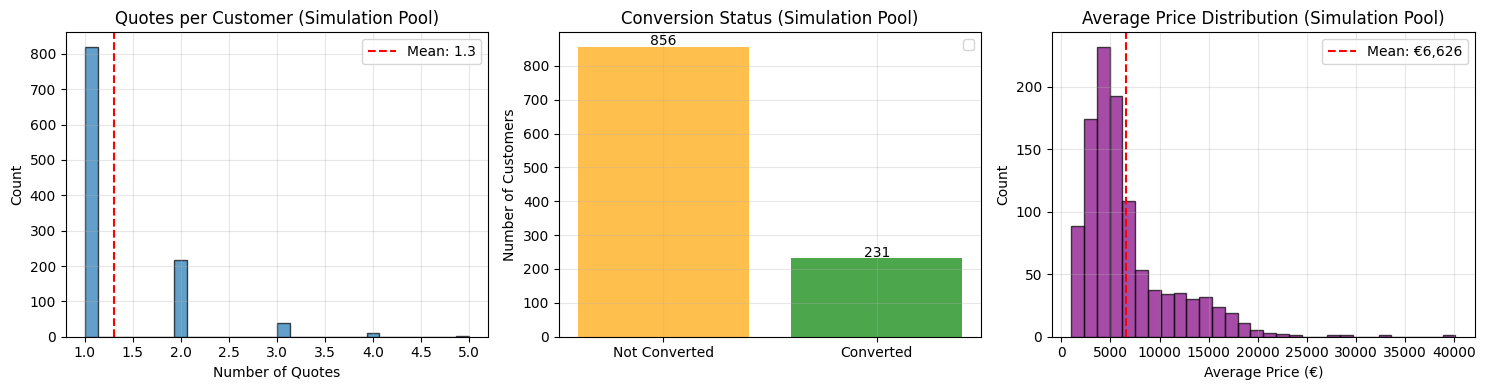

In [6]:
# %% [markdown]
# ### ANALYZE SIMULATION POOL CUSTOMERS

# %%
print("=" * 80)
print("ANALYZING SIMULATION POOL CUSTOMERS")
print("=" * 80)

# Get basic stats for simulation pool customers
sim_customer_stats = df_simulation_pool.groupby('numero_compte').agg({
    'dt_creation_devis': ['min', 'max', 'count'],
    'fg_devis_accepte': 'max',
    'mt_apres_remise_ht_devis': ['mean', 'std'],
    'mt_remise_exceptionnelle_ht': ['mean', 'std']
}).round(2)

sim_customer_stats.columns = ['first_quote', 'last_quote', 'quote_count', 'converted', 
                               'avg_price', 'price_std', 'avg_discount', 'discount_std']

print(f"Simulation pool customer statistics:")
print(f"  • Total customers: {len(sim_customer_stats):,}")
print(f"  • Already converted: {sim_customer_stats['converted'].sum():,} ({sim_customer_stats['converted'].mean():.2%})")
print(f"  • Not yet converted: {(sim_customer_stats['converted'] == 0).sum():,} ({(sim_customer_stats['converted'] == 0).mean():.2%})")
print(f"  • Avg quotes per customer: {sim_customer_stats['quote_count'].mean():.1f}")
print(f"  • Avg price: €{sim_customer_stats['avg_price'].mean():,.0f}")
print(f"  • Avg discount: €{sim_customer_stats['avg_discount'].mean():,.0f}")

# Identify candidates for simulation (not yet converted)
not_converted_candidates = sim_customer_stats[sim_customer_stats['converted'] == 0].index.tolist()
print(f"\n✅ Available for simulation (not yet converted): {len(not_converted_candidates):,} customers")

# Check if candidates have enough quotes for meaningful simulation
candidates_with_multiple_quotes = sim_customer_stats[
    (sim_customer_stats['converted'] == 0) & 
    (sim_customer_stats['quote_count'] > 1)
].index.tolist()

print(f"  • With >1 quote: {len(candidates_with_multiple_quotes):,}")
print(f"  • With only 1 quote: {len(not_converted_candidates) - len(candidates_with_multiple_quotes):,}")

# Sample visualization of simulation pool
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Quote count distribution
axes[0].hist(sim_customer_stats['quote_count'], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_title('Quotes per Customer (Simulation Pool)')
axes[0].set_xlabel('Number of Quotes')
axes[0].set_ylabel('Count')
axes[0].axvline(sim_customer_stats['quote_count'].mean(), color='red', linestyle='--', 
                label=f'Mean: {sim_customer_stats["quote_count"].mean():.1f}')

# Plot 2: Conversion status
conversion_counts = sim_customer_stats['converted'].value_counts()
axes[1].bar(['Not Converted', 'Converted'], conversion_counts.values, color=['orange', 'green'], alpha=0.7)
axes[1].set_title('Conversion Status (Simulation Pool)')
axes[1].set_ylabel('Number of Customers')
for i, v in enumerate(conversion_counts.values):
    axes[1].text(i, v + 5, f'{v:,}', ha='center')

# Plot 3: Average price distribution
axes[2].hist(sim_customer_stats['avg_price'].dropna(), bins=30, edgecolor='black', alpha=0.7, color='purple')
axes[2].set_title('Average Price Distribution (Simulation Pool)')
axes[2].set_xlabel('Average Price (€)')
axes[2].set_ylabel('Count')
axes[2].axvline(sim_customer_stats['avg_price'].mean(), color='red', linestyle='--', 
                label=f'Mean: €{sim_customer_stats["avg_price"].mean():,.0f}')

for ax in axes:
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [7]:
# %% [markdown]
# ## Part 2: Model Training

# %%
print("=" * 80)
print("TRAINING XGBOOST CONVERSION MODEL")
print("=" * 80)

# Import your training function
# Assuming train_xgb is available or we need to define it
from ml_training.train_xgb import train_xgb
print("✅ Imported train_xgb function")


TRAINING XGBOOST CONVERSION MODEL
✅ Imported train_xgb function



Creating features from training data...
✅ Imported create_features function

STRATEGY: CREATE FEATURES
Creating OPTIMIZED customer features (mode: first_conversion)...
  Filtering post-first-purchase data...
  Customers: 22,635, Quotes: 31,191
  Calculating features...
  Calculating price trajectory (optimized)...
✓ Created 14 leakage-free features
→ 22,635 customers | 40.4% converters
⏱️  Execution time: 8.5 seconds
⚠️  8.5s (target was 3s)
CREATING FIRST CONVERSION PREDICTION FEATURES (LEAKAGE-FREE)
  Total customers: 22,635
⚡ Processing customers with corrected first-conversion logic...
  Processed 0/22,635 customers
  Processed 5,000/22,635 customers
  Processed 10,000/22,635 customers
  Processed 15,000/22,635 customers
  Processed 20,000/22,635 customers
✅ First-conversion features calculation complete

🔍 VALIDATION REPORT:
   Total customers: 22,635
   First converters: 9,144 (40.4%)
   Never converters: 13,491

📊 Distribution check:
   Converters with 0 historical quotes: 7,37

,numero_compte,converted,price_trajectory,unique_product_families,product_consistency,avg_discount_pct,main_agency
0,0,0.000,0.000,1,1,-0.082,17
1,1,0.000,0.000,1,1,0.000,17
2,2,1.000,0.000,1,1,0.000,17
3,3,1.000,-114.310,1,1,0.000,17
4,4,1.000,0.000,1,1,0.000,17



Training data shape: (22635, 192)
Features: ['std_days_between_quotes', 'price_trajectory', 'unique_product_families', 'product_consistency', 'avg_discount_pct', 'main_agency', 'main_region', 'total_historical_quotes', 'had_historical_quotes', 'avg_days_since_first_quote']...
Target distribution: 40.40% positive

Training XGBoost model...
✓ Model saved: hvac_conversion_xgb_model.pkl
✓ AUC: 0.750
✓ F1 Score: 0.612
✓ Training samples: 18108
✓ Test samples: 4527

✅ Model training complete:
   AUC: 0.750
   Accuracy: 0.689
   F1 Score: 0.612
   Number of features: 192
Top 10 most important features:
  quote_consistency_score: 0.1547
  is_quick_decider: 0.0732
  decision_efficiency_score: 0.0563
  engagement_density: 0.0478
  model_variety_score: 0.0358
  max_price: 0.0223
  season_summer: 0.0204
  month_concentration: 0.0197
  season_winter: 0.0193
  brand_loyalty_score: 0.0177


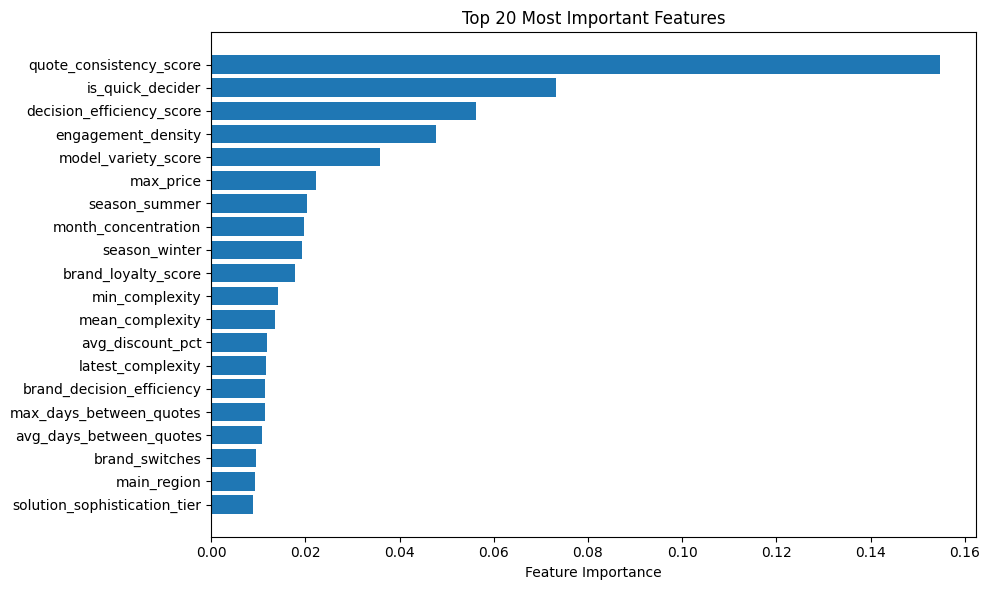

SELECTING & VALIDATING SIMULATION CUSTOMERS
Creating features for simulation pool customers...

STRATEGY: CREATE FEATURES
Creating OPTIMIZED customer features (mode: first_conversion)...
  Filtering post-first-purchase data...
  Customers: 1,087, Quotes: 1,412
  Calculating features...
  Calculating price trajectory (optimized)...
✓ Created 14 leakage-free features
→ 1,087 customers | 21.3% converters
⏱️  Execution time: 0.5 seconds
✅ SUCCESS! Achieved ≤ 3s target
CREATING FIRST CONVERSION PREDICTION FEATURES (LEAKAGE-FREE)
  Total customers: 1,087
⚡ Processing customers with corrected first-conversion logic...
  Processed 0/1,087 customers
✅ First-conversion features calculation complete

🔍 VALIDATION REPORT:
   Total customers: 1,087
   First converters: 231 (21.3%)
   Never converters: 856

📊 Distribution check:
   Converters with 0 historical quotes: 208
   Non-converters with 0 historical quotes: 641
   Avg historical quotes - Converters: 0.1
   Avg historical quotes - Non-convert

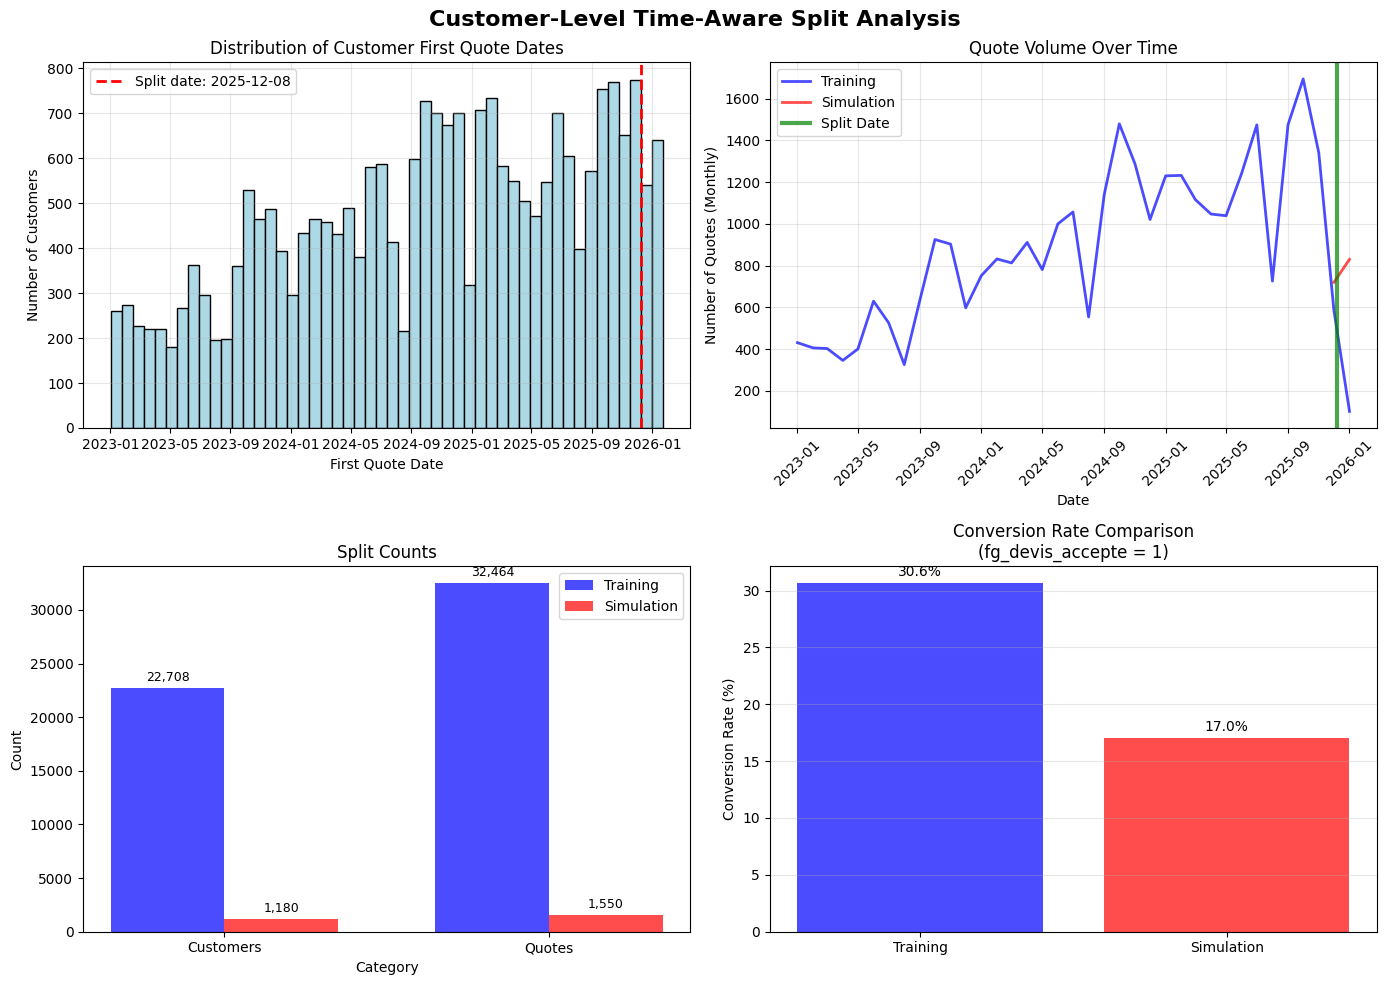


SPLIT SUMMARY:
Split Date: 2025-12-08 00:00:00

Training Set:
- Customers: 22,708
- Quotes: 32,464
- Date range: 2023-01-02 to 2026-01-22
- Avg quotes per customer: 1.43
- Conversion rate: 30.62%

Simulation Pool:
- Customers: 1,180
- Quotes: 1,550
- Date range: 2025-12-09 to 2026-01-22
- Avg quotes per customer: 1.31
- Conversion rate: 17.03%

✓ Split saved to:
  - 'training_quotes.csv'
  - 'simulation_pool_quotes.csv'

✓ Step 1 completed successfully!
✓ Ready for Step 2: Filtering non-converted customers from simulation pool


In [8]:
# %% [markdown]
# ### Create Features for Training

# %%
print("\nCreating features from training data...")
# Assuming create_features function is available

from ml_features.features import create_features
print("✅ Imported create_features function")

# Create features on training data
train_features = create_features(df_train)

print(f"\n✅ Training features created:")
print(f"   Shape: {train_features.shape}")
print(f"   Columns: {len(train_features.columns)}")
print(f"   Conversion rate: {train_features['converted'].mean():.2%}")

# Display first few rows
print(f"\nFirst 5 customers:")
display(train_features[['numero_compte', 'converted'] + 
                       list(train_features.columns[2:7])].head())


# %% [markdown]
# ### Train XGBoost Model

# %%
# Prepare data for training
X_train = train_features.drop(columns=['numero_compte', 'converted'])
y_train = train_features['converted']

print(f"\nTraining data shape: {X_train.shape}")
print(f"Features: {X_train.columns.tolist()[:10]}...")
print(f"Target distribution: {y_train.mean():.2%} positive")

# Train model
print("\nTraining XGBoost model...")
model_data = train_xgb(
    X=X_train,
    y=y_train,
    model_name="hvac_conversion_xgb_model"
)

model = model_data['model']
feature_columns = model_data['features']

print(f"\n✅ Model training complete:")
print(f"   AUC: {model_data['metrics']['auc']:.3f}")
print(f"   Accuracy: {model_data['metrics']['accuracy']:.3f}")
print(f"   F1 Score: {model_data['metrics']['f1']:.3f}")
print(f"   Number of features: {len(feature_columns)}")

# %% [markdown]
# ### Model Feature Importance

# %%
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 most important features:")
for i, row in feature_importance.head(10).iterrows():
    print(f"  {row['feature']}: {row['importance']:.4f}")

# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 6))
top_20 = feature_importance.head(20)
ax.barh(range(len(top_20)), top_20['importance'].values[::-1])
ax.set_yticks(range(len(top_20)))
ax.set_yticklabels(top_20['feature'].values[::-1])
ax.set_xlabel('Feature Importance')
ax.set_title('Top 20 Most Important Features')
plt.tight_layout()
plt.show()

from ml_features.features import create_features
# %% [markdown]
# ## Part 3: Simulation Customer Selection (WITH VALIDATION)

# %%
print("=" * 80)
print("SELECTING & VALIDATING SIMULATION CUSTOMERS")
print("=" * 80)

# We have 856 not-yet-converted customers in simulation pool
# Let's select 5 good candidates WITH PROPER VALIDATION

# First, create features for simulation pool customers
print("Creating features for simulation pool customers...")
try:
    sim_features = create_features(df_simulation_pool)
    print(f"✅ Created features for {len(sim_features)} simulation customers")
except Exception as e:
    print(f"❌ Error creating features: {e}")
    raise

# Filter to not-yet-converted customers
not_converted_features = sim_features[sim_features['converted'] == 0].copy()
print(f"\nNot yet converted customers: {len(not_converted_features)}")

# Get their baseline predictions
print("\nGetting baseline predictions...")

# Align features with training data (add missing columns with 0)
sim_features_aligned = sim_features.copy()
for col in feature_columns:
    if col not in sim_features_aligned.columns:
        sim_features_aligned[col] = 0

X_sim = sim_features_aligned[feature_columns]
baseline_probs = model.predict_proba(X_sim)[:, 1]
sim_features_aligned['baseline_probability'] = baseline_probs

# Update not_converted_features with probabilities
not_converted_features = sim_features_aligned[sim_features_aligned['converted'] == 0].copy()

print(f"\n📊 Baseline prediction statistics:")
print(f"  Mean probability: {not_converted_features['baseline_probability'].mean():.2%}")
print(f"  Median probability: {not_converted_features['baseline_probability'].median():.2%}")
print(f"  Std: {not_converted_features['baseline_probability'].std():.3f}")

# ========== VALIDATION STEP ==========
print("\n🔍 VALIDATING CANDIDATES HAVE ACTUAL DATA...")

# Create validation function
def validate_customer(customer_id, df_simulation_pool, not_converted_features):
    """
    Validate that a customer has actual quotes and data
    Returns: (is_valid, validation_message, customer_data)
    """
    # 1. Check customer has quotes in simulation pool
    customer_quotes = df_simulation_pool[df_simulation_pool['numero_compte'] == customer_id]
    
    if len(customer_quotes) == 0:
        return False, f"No quotes in simulation pool", None
    
    # 2. Check customer has features
    if customer_id not in not_converted_features['numero_compte'].values:
        return False, f"No features generated", None
    
    # 3. Get customer info
    baseline_prob = not_converted_features.loc[
        not_converted_features['numero_compte'] == customer_id, 
        'baseline_probability'
    ].values[0] if customer_id in not_converted_features['numero_compte'].values else None
    
    avg_price = customer_quotes['mt_apres_remise_ht_devis'].mean()
    first_quote = customer_quotes['dt_creation_devis'].min()
    
    customer_data = {
        'customer_id': customer_id,
        'baseline_probability': baseline_prob,
        'quote_count': len(customer_quotes),
        'avg_price': avg_price,
        'first_quote': first_quote,
        'quotes_df': customer_quotes
    }
    
    return True, "Valid", customer_data

# ========== SELECT WITH VALIDATION ==========
print("\n🎯 Selecting 5 validated customers...")

# Strategy: Pick customers across probability spectrum WITH VALIDATION
not_converted_features_sorted = not_converted_features.sort_values('baseline_probability')
n_buckets = 5
bucket_size = len(not_converted_features_sorted) // n_buckets
selected_customers_validated = []
selected_customers_data = []

attempts = 0
max_attempts = 50  # Prevent infinite loop

while len(selected_customers_validated) < 5 and attempts < max_attempts:
    for i in range(n_buckets):
        if len(selected_customers_validated) >= 5:
            break
            
        start_idx = i * bucket_size
        end_idx = start_idx + bucket_size if i < n_buckets - 1 else len(not_converted_features_sorted)
        bucket = not_converted_features_sorted.iloc[start_idx:end_idx]
        
        if len(bucket) == 0:
            continue
            
        # Pick random customer from bucket (not just middle)
        candidate_idx = np.random.randint(start_idx, min(end_idx, len(not_converted_features_sorted)))
        candidate = not_converted_features_sorted.iloc[candidate_idx]
        candidate_id = candidate['numero_compte']
        
        # Validate candidate
        is_valid, message, customer_data = validate_customer(
            candidate_id, df_simulation_pool, not_converted_features
        )
        
        attempts += 1
        
        if is_valid and candidate_id not in selected_customers_validated:
            selected_customers_validated.append(candidate_id)
            selected_customers_data.append(customer_data)
            print(f"  ✓ Selected customer {candidate_id} (bucket {i+1}, prob: {candidate['baseline_probability']:.1%})")
        else:
            if attempts <= 10:  # Only show first few attempts
                print(f"  ✗ Skipped customer {candidate_id}: {message}")

if len(selected_customers_validated) < 5:
    print(f"\n⚠️  WARNING: Only found {len(selected_customers_validated)} valid customers")
    print("Adding top customers by quote count as fallback...")
    
    # Fallback: customers with most quotes
    quote_counts = df_simulation_pool.groupby('numero_compte').size()
    top_customers = quote_counts.nlargest(10).index.tolist()
    
    for customer_id in top_customers:
        if len(selected_customers_validated) >= 5:
            break
            
        if customer_id not in selected_customers_validated:
            is_valid, message, customer_data = validate_customer(
                customer_id, df_simulation_pool, not_converted_features
            )
            
            if is_valid:
                selected_customers_validated.append(customer_id)
                selected_customers_data.append(customer_data)
                print(f"  ✓ Added fallback customer {customer_id}")

# ========== DISPLAY VALIDATED CUSTOMERS ==========
print(f"\n" + "=" * 80)
print("FINAL VALIDATED SIMULATION CUSTOMERS")
print("=" * 80)

for i, customer_data in enumerate(selected_customers_data, 1):
    print(f"\nCustomer {i}:")
    print(f"  ID: {customer_data['customer_id']}")
    print(f"  Baseline conversion probability: {customer_data['baseline_probability']:.1%}")
    print(f"  Quote count: {customer_data['quote_count']}")
    print(f"  Avg price: €{customer_data['avg_price']:,.0f}")
    print(f"  First quote: {customer_data['first_quote'].date() if pd.notna(customer_data['first_quote']) else 'N/A'}")
    
    # Show sample of quote data
    quotes_sample = customer_data['quotes_df'].head(3)
    print(f"  Sample quotes ({len(customer_data['quotes_df'])} total):")
    for _, quote in quotes_sample.iterrows():
        print(f"    • {quote['dt_creation_devis'].date()}: €{quote['mt_apres_remise_ht_devis']:,.0f}")

print(f"\n✅ Selected {len(selected_customers_validated)} validated customers for simulation")
print("   All customers have actual quote data")
print("   Ready for simulation scenarios!")

# Step 1: Customer-Level Time-Aware Split (COMPLETE & CORRECTED)
# ===============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("="*60)
print("STEP 1: CUSTOMER-LEVEL TIME-AWARE SPLIT")
print("="*60)

print("\nInitial dataset info:")
print(f"Total quotes: {len(df_quotes)}")
print(f"Total unique customers: {df_quotes['numero_compte'].nunique()}")
print(f"Date range: {df_quotes['dt_creation_devis'].min()} to {df_quotes['dt_creation_devis'].max()}")

# Check for conversion column
print("\nChecking conversion column 'fg_devis_accepte':")
if 'fg_devis_accepte' in df_quotes.columns:
    conversion_rate = df_quotes['fg_devis_accepte'].mean() * 100
    print(f"  Found! Overall conversion rate: {conversion_rate:.2f}%")
    print(f"  Converted quotes: {(df_quotes['fg_devis_accepte'] == 1).sum()}")
    print(f"  Non-converted quotes: {(df_quotes['fg_devis_accepte'] == 0).sum()}")
else:
    print("  WARNING: 'fg_devis_accepte' column not found!")

print("\n" + "="*60)

# -------------------------------------------------------------
# CUSTOMER-LEVEL SPLIT BASED ON FIRST QUOTE DATE
# -------------------------------------------------------------

def customer_level_time_split(df, customer_id_col='numero_compte', 
                              date_col='dt_creation_devis', split_ratio=0.95):
    """
    Split customers based on their FIRST quote date.
    """
    print("Performing CUSTOMER-LEVEL time-aware split...")
    
    # 1. Get first quote date for each customer
    customer_first_dates = df.groupby(customer_id_col)[date_col].min().reset_index()
    customer_first_dates.columns = [customer_id_col, 'first_quote_date']
    
    # 2. Sort customers by their first quote date (oldest to newest)
    customer_first_dates = customer_first_dates.sort_values('first_quote_date')
    customer_first_dates = customer_first_dates.reset_index(drop=True)
    
    print(f"\nTotal customers: {len(customer_first_dates)}")
    print(f"First quote date range: {customer_first_dates['first_quote_date'].min()} to {customer_first_dates['first_quote_date'].max()}")
    
    # 3. Find split point (95th percentile of customers by first quote date)
    split_index = int(len(customer_first_dates) * split_ratio)
    split_date = customer_first_dates.iloc[split_index]['first_quote_date']
    
    print(f"\nSplit configuration:")
    print(f"- Split ratio: {split_ratio*100}% training, {(1-split_ratio)*100}% simulation")
    print(f"- Split date (based on {split_ratio*100}th percentile of customer first dates): {split_date}")
    print(f"- Customer at split point: #{split_index} of {len(customer_first_dates)}")
    
    # 4. Split customers based on their first quote date
    training_customers = customer_first_dates[
        customer_first_dates['first_quote_date'] <= split_date
    ][customer_id_col].tolist()
    
    simulation_customers = customer_first_dates[
        customer_first_dates['first_quote_date'] > split_date
    ][customer_id_col].tolist()
    
    print(f"\nCustomer split results:")
    print(f"- Training customers: {len(training_customers)} ({len(training_customers)/len(customer_first_dates)*100:.1f}%)")
    print(f"- Simulation customers: {len(simulation_customers)} ({len(simulation_customers)/len(customer_first_dates)*100:.1f}%)")
    
    # 5. Split the quotes data based on customer membership
    df_train = df[df[customer_id_col].isin(training_customers)].copy()
    df_sim = df[df[customer_id_col].isin(simulation_customers)].copy()
    
    print(f"\nQuote split results:")
    print(f"- Training quotes: {len(df_train)} ({len(df_train)/len(df)*100:.1f}%)")
    print(f"- Simulation quotes: {len(df_sim)} ({len(df_sim)/len(df)*100:.1f}%)")
    
    # 6. Check conversion rates in both sets
    if 'fg_devis_accepte' in df.columns:
        train_conversion = df_train['fg_devis_accepte'].mean() * 100
        sim_conversion = df_sim['fg_devis_accepte'].mean() * 100
        print(f"\nConversion rates (fg_devis_accepte = 1):")
        print(f"- Training set: {train_conversion:.2f}%")
        print(f"- Simulation pool: {sim_conversion:.2f}%")
    
    # 7. Validate the split
    print("\n" + "-"*40)
    print("VALIDATION CHECKS:")
    print("-"*40)
    
    # Check 1: No customer overlap
    overlap = set(training_customers) & set(simulation_customers)
    print(f"1. Customer overlap: {len(overlap)} (should be 0)")
    assert len(overlap) == 0, "ERROR: Customers appear in both sets!"
    
    # Check 2: All training customers have first quote before split date
    training_first_dates = df_train.groupby(customer_id_col)[date_col].min()
    training_check = (training_first_dates <= split_date).all()
    print(f"2. All training customers have first quote ≤ split date: {training_check}")
    
    # Check 3: All simulation customers have first quote after split date
    sim_first_dates = df_sim.groupby(customer_id_col)[date_col].min()
    sim_check = (sim_first_dates > split_date).all()
    print(f"3. All simulation customers have first quote > split date: {sim_check}")
    
    # Check 4: Time ordering
    max_training_date = df_train[date_col].max()
    min_sim_date = df_sim[date_col].min()
    print(f"4. Time ordering - Max training date: {max_training_date}")
    print(f"   Time ordering - Min simulation date: {min_sim_date}")
    print(f"   Gap between sets: {min_sim_date - max_training_date}")
    
    return {
        'split_date': split_date,
        'training_customers': training_customers,
        'simulation_customers': simulation_customers,
        'df_train': df_train,
        'df_sim': df_sim,
        'customer_first_dates': customer_first_dates
    }

# -------------------------------------------------------------
# EXECUTE THE SPLIT
# -------------------------------------------------------------

# Perform the split
split_results = customer_level_time_split(
    df=df_quotes,
    customer_id_col='numero_compte',
    date_col='dt_creation_devis',
    split_ratio=0.95
)

print("\n" + "="*60)
print("SPLIT COMPLETED SUCCESSFULLY!")
print("="*60)

# -------------------------------------------------------------
# VISUALIZE THE SPLIT
# -------------------------------------------------------------

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Customer-Level Time-Aware Split Analysis', fontsize=16, fontweight='bold')

# 1. Customer first dates distribution
ax1 = axes[0, 0]
split_results['customer_first_dates']['first_quote_date'].hist(
    bins=50, ax=ax1, edgecolor='black', color='lightblue'
)
ax1.axvline(x=split_results['split_date'], color='red', linestyle='--', linewidth=2, 
           label=f'Split date: {split_results["split_date"].strftime("%Y-%m-%d")}')
ax1.set_xlabel('First Quote Date')
ax1.set_ylabel('Number of Customers')
ax1.set_title('Distribution of Customer First Quote Dates')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Quote timeline (simplified)
ax2 = axes[0, 1]
# Plot density of quotes over time
train_dates = split_results['df_train']['dt_creation_devis']
sim_dates = split_results['df_sim']['dt_creation_devis']

# Create monthly bins
train_monthly = train_dates.dt.to_period('M').value_counts().sort_index()
sim_monthly = sim_dates.dt.to_period('M').value_counts().sort_index()

# Convert periods back to datetime for plotting
train_monthly.index = train_monthly.index.to_timestamp()
sim_monthly.index = sim_monthly.index.to_timestamp()

ax2.plot(train_monthly.index, train_monthly.values, label='Training', color='blue', alpha=0.7, linewidth=2)
ax2.plot(sim_monthly.index, sim_monthly.values, label='Simulation', color='red', alpha=0.7, linewidth=2)
ax2.axvline(x=split_results['split_date'], color='green', linestyle='-', linewidth=3, 
           alpha=0.7, label='Split Date')
ax2.set_xlabel('Date')
ax2.set_ylabel('Number of Quotes (Monthly)')
ax2.set_title('Quote Volume Over Time')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

# 3. Split statistics
ax3 = axes[1, 0]
categories = ['Customers', 'Quotes']
train_counts = [len(split_results['training_customers']), len(split_results['df_train'])]
sim_counts = [len(split_results['simulation_customers']), len(split_results['df_sim'])]

x = np.arange(len(categories))
width = 0.35

bars1 = ax3.bar(x - width/2, train_counts, width, label='Training', color='blue', alpha=0.7)
bars2 = ax3.bar(x + width/2, sim_counts, width, label='Simulation', color='red', alpha=0.7)

ax3.set_xlabel('Category')
ax3.set_ylabel('Count')
ax3.set_title('Split Counts')
ax3.set_xticks(x)
ax3.set_xticklabels(categories)
ax3.legend()

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax3.annotate(f'{height:,}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

# 4. Conversion rate comparison (if column exists)
ax4 = axes[1, 1]
if 'fg_devis_accepte' in split_results['df_train'].columns:
    # Conversion rates comparison
    train_conversion_rate = split_results['df_train']['fg_devis_accepte'].mean() * 100
    sim_conversion_rate = split_results['df_sim']['fg_devis_accepte'].mean() * 100
    
    bars = ax4.bar(['Training', 'Simulation'], [train_conversion_rate, sim_conversion_rate], 
                  color=['blue', 'red'], alpha=0.7)
    ax4.set_ylabel('Conversion Rate (%)')
    ax4.set_title(f'Conversion Rate Comparison\n(fg_devis_accepte = 1)')
    ax4.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax4.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)
else:
    # Show quote volume comparison instead
    train_quotes_per_customer = len(split_results['df_train']) / len(split_results['training_customers'])
    sim_quotes_per_customer = len(split_results['df_sim']) / len(split_results['simulation_customers'])
    
    bars = ax4.bar(['Training', 'Simulation'], [train_quotes_per_customer, sim_quotes_per_customer], 
                  color=['blue', 'red'], alpha=0.7)
    ax4.set_ylabel('Avg Quotes per Customer')
    ax4.set_title('Engagement Level Comparison')
    ax4.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax4.annotate(f'{height:.1f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# -------------------------------------------------------------
# SAVE THE SPLIT FOR NEXT STEPS
# -------------------------------------------------------------

print("\n" + "="*60)
print("SPLIT SUMMARY:")
print("="*60)
print(f"Split Date: {split_results['split_date']}")
print(f"\nTraining Set:")
print(f"- Customers: {len(split_results['training_customers']):,}")
print(f"- Quotes: {len(split_results['df_train']):,}")
print(f"- Date range: {split_results['df_train']['dt_creation_devis'].min().strftime('%Y-%m-%d')} to {split_results['df_train']['dt_creation_devis'].max().strftime('%Y-%m-%d')}")
print(f"- Avg quotes per customer: {len(split_results['df_train'])/len(split_results['training_customers']):.2f}")

if 'fg_devis_accepte' in split_results['df_train'].columns:
    train_conv = split_results['df_train']['fg_devis_accepte'].mean() * 100
    print(f"- Conversion rate: {train_conv:.2f}%")

print(f"\nSimulation Pool:")
print(f"- Customers: {len(split_results['simulation_customers']):,}")
print(f"- Quotes: {len(split_results['df_sim']):,}")
print(f"- Date range: {split_results['df_sim']['dt_creation_devis'].min().strftime('%Y-%m-%d')} to {split_results['df_sim']['dt_creation_devis'].max().strftime('%Y-%m-%d')}")
print(f"- Avg quotes per customer: {len(split_results['df_sim'])/len(split_results['simulation_customers']):.2f}")

if 'fg_devis_accepte' in split_results['df_sim'].columns:
    sim_conv = split_results['df_sim']['fg_devis_accepte'].mean() * 100
    print(f"- Conversion rate: {sim_conv:.2f}%")

# Save the split for next steps
split_results['df_train'].to_csv('training_quotes.csv', index=False)
split_results['df_sim'].to_csv('simulation_pool_quotes.csv', index=False)

print("\n✓ Split saved to:")
print("  - 'training_quotes.csv'")
print("  - 'simulation_pool_quotes.csv'")
print("\n✓ Step 1 completed successfully!")
print("✓ Ready for Step 2: Filtering non-converted customers from simulation pool")


STEP 2: FILTERING NON-CONVERTED CUSTOMERS

1. Analyzing conversion status in simulation pool...

Total simulation customers: 1,180
Converted customers (any accepted quote): 257 (21.8%)
Non-converted customers (no accepted quotes): 923 (78.2%)

Non-converted customers available for simulation: 923

----------------------------------------
2. Getting detailed customer statistics...
----------------------------------------

Eligible customers (non-converted with ≥1 quote): 923

ELIGIBLE CUSTOMER POOL ANALYSIS

📊 BASIC STATISTICS:
   Total eligible customers: 923
   Total quotes: 1,206
   Average quotes per customer: 1.31
   Quote range: 1 to 5
   Median quotes: 1.0

📈 QUOTE COUNT DISTRIBUTION:
   Customers with 1 quote: 691 (74.9%)
   Customers with 2 quotes: 189 (20.5%)
   Customers with 3+ quotes: 43 (4.7%)

📋 STATUS ANALYSIS:
   Customers with refused quotes: 70 (7.6%)

   Most common devis statuses:
   - En attente de retour client: 706 (76.5%)
   - En cours: 123 (13.3%)
   - Refusé:

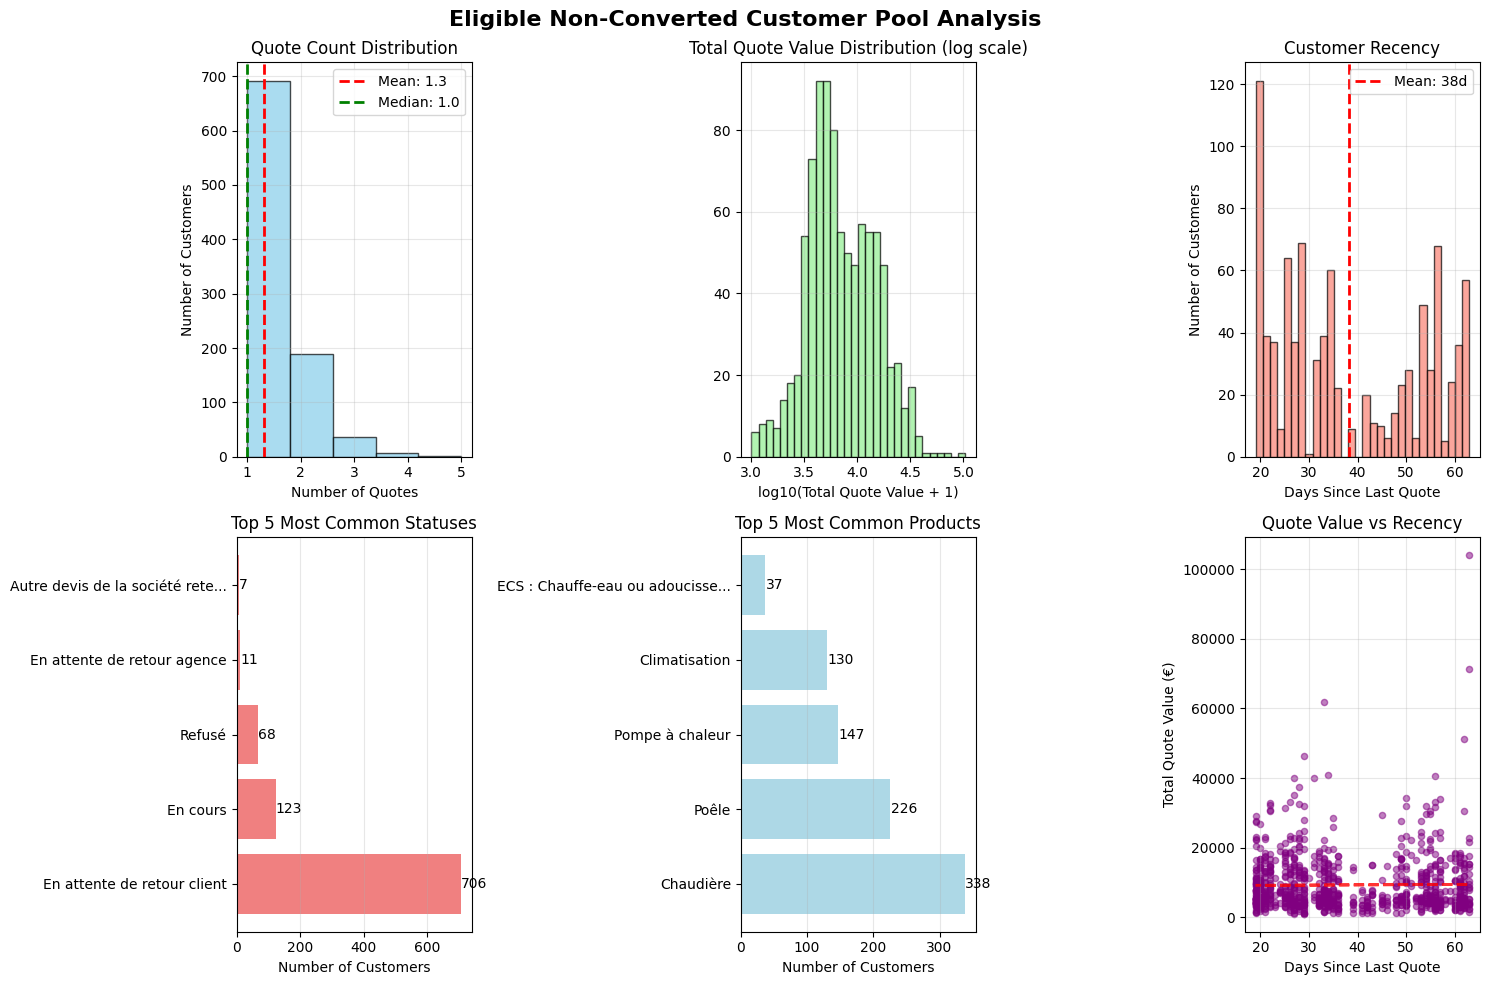


STEP 2 SUMMARY

📋 Simulation Pool Analysis:
   Total simulation customers: 1,180
   Converted customers: 257 (21.8%)
   Non-converted customers: 923 (78.2%)

✅ Eligible for Simulation:
   Non-converted customers with ≥1 quote: 923
   These customers have 1,206 total quotes
   Average quotes per customer: 1.31

📊 Key Characteristics:
   Most common status: En attente de retour client
   Most common product: Chaudière
   Average days since last quote: 38.3 days
   Average total quote value: €9,300.36

💾 Data Saved:
   Eligible customers saved to: 'eligible_simulation_customers.csv'
   Contains 923 customers with detailed statistics

READY FOR STEP 3: SAMPLING 5 CUSTOMERS FOR SIMULATION

We now have a pool of non-converted customers ready for sampling.
Next step: Randomly sample 5 customers for our simulation POC.


In [9]:
# Step 2: Filter Non-Converted Customers from Simulation Pool
# ============================================================

print("\n" + "="*60)
print("STEP 2: FILTERING NON-CONVERTED CUSTOMERS")
print("="*60)

# Using fg_devis_accepte as conversion indicator (1 = converted, 0 = not converted)
conversion_col = 'fg_devis_accepte'

# 1. Identify conversion status for each customer in simulation pool
print("\n1. Analyzing conversion status in simulation pool...")

# Get the maximum conversion value for each customer
# (if any quote has fg_devis_accepte = 1, the customer is considered converted)
customer_conversion = split_results['df_sim'].groupby('numero_compte')[conversion_col].max().reset_index()
customer_conversion.columns = ['numero_compte', 'is_converted']

# Count conversion status
conversion_counts = customer_conversion['is_converted'].value_counts()
total_sim_customers = len(customer_conversion)

print(f"\nTotal simulation customers: {total_sim_customers:,}")
print(f"Converted customers (any accepted quote): {conversion_counts.get(1, 0):,} ({conversion_counts.get(1, 0)/total_sim_customers*100:.1f}%)")
print(f"Non-converted customers (no accepted quotes): {conversion_counts.get(0, 0):,} ({conversion_counts.get(0, 0)/total_sim_customers*100:.1f}%)")

# 2. Filter to non-converted customers
non_converted_customers = customer_conversion[customer_conversion['is_converted'] == 0]['numero_compte'].tolist()
print(f"\nNon-converted customers available for simulation: {len(non_converted_customers):,}")

# 3. Get detailed statistics for eligible customers
print("\n" + "-"*40)
print("2. Getting detailed customer statistics...")
print("-"*40)

# Get comprehensive stats for simulation customers
customer_stats = split_results['df_sim'].groupby('numero_compte').agg({
    'id_devis': 'count',  # quote count
    'fg_devis_accepte': 'max',  # conversion status
    'fg_devis_refuse': 'max',  # refusal status
    'statut_devis': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'Unknown',
    'dt_creation_devis': ['min', 'max'],  # first and last quote dates
    'mt_apres_remise_ht_devis': 'sum',  # total quote value
    'mt_remise_exceptionnelle_ht': 'sum',  # total discount
    'famille_equipement_produit': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'Unknown'
}).reset_index()

# Flatten column names
customer_stats.columns = [
    'numero_compte', 'quote_count', 'is_converted', 'is_refused', 
    'most_common_status', 'first_quote_date', 'last_quote_date',
    'total_quote_value', 'total_discount', 'most_common_product'
]

# Filter to non-converted customers with at least 1 quote
eligible_customers = customer_stats[
    (customer_stats['is_converted'] == 0) & 
    (customer_stats['quote_count'] >= 1)
].copy()

print(f"\nEligible customers (non-converted with ≥1 quote): {len(eligible_customers):,}")

# 4. Analyze the eligible customer pool
print("\n" + "="*60)
print("ELIGIBLE CUSTOMER POOL ANALYSIS")
print("="*60)

# Basic stats
print(f"\n📊 BASIC STATISTICS:")
print(f"   Total eligible customers: {len(eligible_customers):,}")
print(f"   Total quotes: {eligible_customers['quote_count'].sum():,}")
print(f"   Average quotes per customer: {eligible_customers['quote_count'].mean():.2f}")
print(f"   Quote range: {eligible_customers['quote_count'].min()} to {eligible_customers['quote_count'].max()}")
print(f"   Median quotes: {eligible_customers['quote_count'].median():.1f}")

# Quote count distribution
print(f"\n📈 QUOTE COUNT DISTRIBUTION:")
quote_distribution = eligible_customers['quote_count'].value_counts().sort_index()
print(f"   Customers with 1 quote: {quote_distribution.get(1, 0):,} ({quote_distribution.get(1, 0)/len(eligible_customers)*100:.1f}%)")
print(f"   Customers with 2 quotes: {quote_distribution.get(2, 0):,} ({quote_distribution.get(2, 0)/len(eligible_customers)*100:.1f}%)")
print(f"   Customers with 3+ quotes: {(eligible_customers['quote_count'] >= 3).sum():,} ({(eligible_customers['quote_count'] >= 3).sum()/len(eligible_customers)*100:.1f}%)")

# Status analysis
print(f"\n📋 STATUS ANALYSIS:")
refused_count = (eligible_customers['is_refused'] == 1).sum()
print(f"   Customers with refused quotes: {refused_count:,} ({refused_count/len(eligible_customers)*100:.1f}%)")

# Most common statuses
status_counts = eligible_customers['most_common_status'].value_counts().head(5)
print(f"\n   Most common devis statuses:")
for status, count in status_counts.items():
    percentage = count / len(eligible_customers) * 100
    print(f"   - {status}: {count:,} ({percentage:.1f}%)")

# Product analysis
print(f"\n🏷️  PRODUCT ANALYSIS:")
product_counts = eligible_customers['most_common_product'].value_counts().head(5)
print(f"   Most common products:")
for product, count in product_counts.items():
    percentage = count / len(eligible_customers) * 100
    print(f"   - {product}: {count:,} ({percentage:.1f}%)")

# Time analysis
print(f"\n⏰ TIME ANALYSIS:")
now = pd.Timestamp.now()
eligible_customers['days_since_last_quote'] = (now - eligible_customers['last_quote_date']).dt.days
eligible_customers['quote_duration_days'] = (eligible_customers['last_quote_date'] - eligible_customers['first_quote_date']).dt.days

print(f"   Most recent quote: {eligible_customers['last_quote_date'].max().strftime('%Y-%m-%d')}")
print(f"   Oldest quote: {eligible_customers['first_quote_date'].min().strftime('%Y-%m-%d')}")
print(f"   Average days since last quote: {eligible_customers['days_since_last_quote'].mean():.1f}")
print(f"   Average quote duration: {eligible_customers['quote_duration_days'].mean():.1f} days")

# Financial analysis
print(f"\n💰 FINANCIAL ANALYSIS:")
print(f"   Total quote value: €{eligible_customers['total_quote_value'].sum():,.2f}")
print(f"   Total discount: €{eligible_customers['total_discount'].sum():,.2f}")
print(f"   Avg quote value per customer: €{eligible_customers['total_quote_value'].mean():,.2f}")
print(f"   Avg discount per customer: €{eligible_customers['total_discount'].mean():,.2f}")
print(f"   Discount rate: {(eligible_customers['total_discount'].sum() / eligible_customers['total_quote_value'].sum() * 100):.2f}%")

# -------------------------------------------------------------
# VISUALIZE THE ELIGIBLE CUSTOMER POOL
# -------------------------------------------------------------

print("\n" + "="*60)
print("VISUALIZING ELIGIBLE CUSTOMER POOL")
print("="*60)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Eligible Non-Converted Customer Pool Analysis', fontsize=16, fontweight='bold')

# Plot 1: Quote count distribution
ax1 = axes[0, 0]
quote_counts = eligible_customers['quote_count']
max_bins = min(20, quote_counts.max())
ax1.hist(quote_counts, bins=max_bins, edgecolor='black', alpha=0.7, color='skyblue')
ax1.axvline(x=quote_counts.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {quote_counts.mean():.1f}')
ax1.axvline(x=quote_counts.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {quote_counts.median():.1f}')
ax1.set_xlabel('Number of Quotes')
ax1.set_ylabel('Number of Customers')
ax1.set_title('Quote Count Distribution')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Quote value distribution (log scale for better visualization)
ax2 = axes[0, 1]
quote_values = eligible_customers['total_quote_value']
# Remove zeros and use log scale
non_zero_values = quote_values[quote_values > 0]
if len(non_zero_values) > 0:
    ax2.hist(np.log10(non_zero_values + 1), bins=30, edgecolor='black', alpha=0.7, color='lightgreen')
    ax2.set_xlabel('log10(Total Quote Value + 1)')
    ax2.set_title('Total Quote Value Distribution (log scale)')
else:
    ax2.text(0.5, 0.5, 'No quote values > 0', ha='center', va='center', transform=ax2.transAxes)
ax2.grid(True, alpha=0.3)

# Plot 3: Days since last quote
ax3 = axes[0, 2]
days_since = eligible_customers['days_since_last_quote']
ax3.hist(days_since, bins=30, edgecolor='black', alpha=0.7, color='salmon')
ax3.axvline(x=days_since.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {days_since.mean():.0f}d')
ax3.set_xlabel('Days Since Last Quote')
ax3.set_ylabel('Number of Customers')
ax3.set_title('Customer Recency')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Most common statuses (top 5)
ax4 = axes[1, 0]
top_statuses = eligible_customers['most_common_status'].value_counts().head(5)
bars4 = ax4.barh(range(len(top_statuses)), top_statuses.values, color='lightcoral')
ax4.set_yticks(range(len(top_statuses)))
ax4.set_yticklabels([str(s)[:30] + '...' if len(str(s)) > 30 else str(s) for s in top_statuses.index])
ax4.set_xlabel('Number of Customers')
ax4.set_title('Top 5 Most Common Statuses')
# Add value labels
for i, v in enumerate(top_statuses.values):
    ax4.text(v + 0.5, i, str(v), va='center')
ax4.grid(True, alpha=0.3, axis='x')

# Plot 5: Most common products (top 5)
ax5 = axes[1, 1]
top_products = eligible_customers['most_common_product'].value_counts().head(5)
bars5 = ax5.barh(range(len(top_products)), top_products.values, color='lightblue')
ax5.set_yticks(range(len(top_products)))
ax5.set_yticklabels([str(p)[:30] + '...' if len(str(p)) > 30 else str(p) for p in top_products.index])
ax5.set_xlabel('Number of Customers')
ax5.set_title('Top 5 Most Common Products')
# Add value labels
for i, v in enumerate(top_products.values):
    ax5.text(v + 0.5, i, str(v), va='center')
ax5.grid(True, alpha=0.3, axis='x')

# Plot 6: Quote value vs days since last quote
ax6 = axes[1, 2]
if len(eligible_customers) > 0:
    scatter = ax6.scatter(eligible_customers['days_since_last_quote'], 
                         eligible_customers['total_quote_value'],
                         alpha=0.5, s=20, c='purple')
    ax6.set_xlabel('Days Since Last Quote')
    ax6.set_ylabel('Total Quote Value (€)')
    ax6.set_title('Quote Value vs Recency')
    ax6.grid(True, alpha=0.3)
    
    # Add trend line
    if len(eligible_customers) > 1:
        z = np.polyfit(eligible_customers['days_since_last_quote'], 
                      eligible_customers['total_quote_value'], 1)
        p = np.poly1d(z)
        ax6.plot(eligible_customers['days_since_last_quote'], 
                p(eligible_customers['days_since_last_quote']), 
                "r--", alpha=0.8, linewidth=2)
else:
    ax6.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax6.transAxes)

plt.tight_layout()
plt.show()

# -------------------------------------------------------------
# SAVE THE ELIGIBLE CUSTOMERS FOR NEXT STEPS
# -------------------------------------------------------------

# Save eligible customers
eligible_customers.to_csv('eligible_simulation_customers.csv', index=False)

print("\n" + "="*60)
print("STEP 2 SUMMARY")
print("="*60)
print(f"\n📋 Simulation Pool Analysis:")
print(f"   Total simulation customers: {total_sim_customers:,}")
print(f"   Converted customers: {conversion_counts.get(1, 0):,} ({conversion_counts.get(1, 0)/total_sim_customers*100:.1f}%)")
print(f"   Non-converted customers: {conversion_counts.get(0, 0):,} ({conversion_counts.get(0, 0)/total_sim_customers*100:.1f}%)")

print(f"\n✅ Eligible for Simulation:")
print(f"   Non-converted customers with ≥1 quote: {len(eligible_customers):,}")
print(f"   These customers have {eligible_customers['quote_count'].sum():,} total quotes")
print(f"   Average quotes per customer: {eligible_customers['quote_count'].mean():.2f}")

print(f"\n📊 Key Characteristics:")
print(f"   Most common status: {eligible_customers['most_common_status'].mode().iloc[0] if len(eligible_customers) > 0 else 'N/A'}")
print(f"   Most common product: {eligible_customers['most_common_product'].mode().iloc[0] if len(eligible_customers) > 0 else 'N/A'}")
print(f"   Average days since last quote: {eligible_customers['days_since_last_quote'].mean():.1f} days" if len(eligible_customers) > 0 else "No data")
print(f"   Average total quote value: €{eligible_customers['total_quote_value'].mean():,.2f}" if len(eligible_customers) > 0 else "No data")

print(f"\n💾 Data Saved:")
print(f"   Eligible customers saved to: 'eligible_simulation_customers.csv'")
print(f"   Contains {len(eligible_customers)} customers with detailed statistics")

print("\n" + "="*60)
print("READY FOR STEP 3: SAMPLING 5 CUSTOMERS FOR SIMULATION")
print("="*60)
print("\nWe now have a pool of non-converted customers ready for sampling.")
print("Next step: Randomly sample 5 customers for our simulation POC.")


STEP 3: SAMPLING 5 CUSTOMERS FOR SIMULATION

Random seed set to: 42 for reproducibility

----------------------------------------
SAMPLING STRATEGY
----------------------------------------
We'll sample 5 customers with diverse characteristics:
1. Different quote counts (1, 2, 3+ quotes)
2. Different product types
3. Different statuses
4. Different quote values
5. Different recency levels

1. Analyzing quote count distribution for stratification...

Quote count categories:
  single_quote: 691 customers (74.9%)
  two_quotes: 189 customers (20.5%)
  multiple_quotes: 43 customers (4.7%)

Sampling strategy:
  single_quote: 2 customers
  two_quotes: 1 customers
  multiple_quotes: 2 customers

----------------------------------------
PERFORMING STRATIFIED SAMPLING
----------------------------------------
  Sampled 2 customers from single_quote category
  Sampled 1 customers from two_quotes category
  Sampled 2 customers from multiple_quotes category

✅ Successfully sampled 5 customers

SAMPL

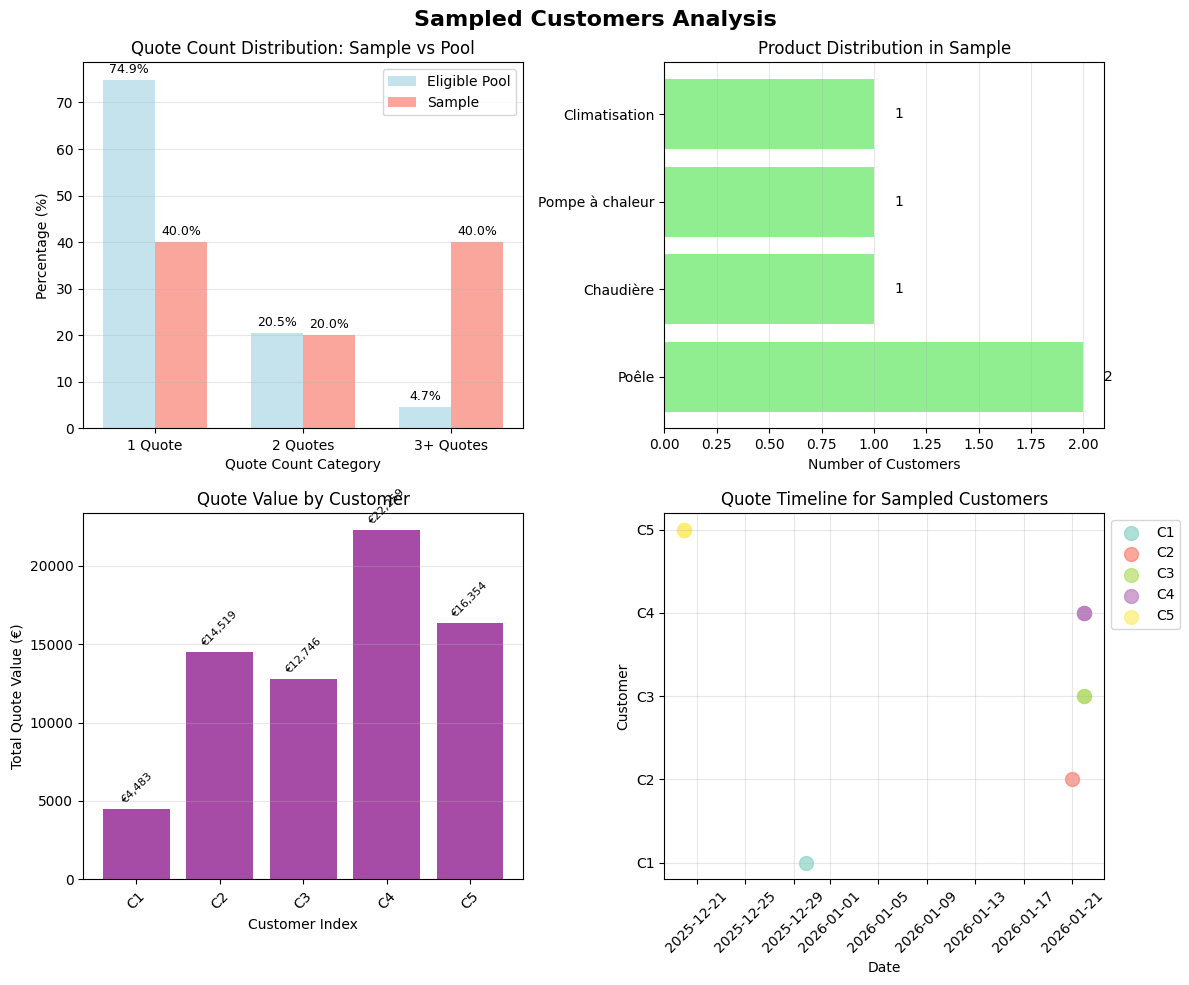


STEP 3 COMPLETED SUCCESSFULLY!

✅ Successfully sampled 5 customers for simulation
✅ Customer IDs: ['CL00340061', 'CL00345831', 'CL00345730', 'CL00345567', 'CL00340365']
✅ Data saved in multiple formats for next steps

📁 Files created:
   - sampled_customer_ids.json
   - sampled_customers_stats.csv
   - customer_<ID>_quotes.csv (for each customer)
   - all_sampled_customers_quotes.csv
   - sampling_report.json

➡️  Ready for Step 4: Model Training


In [10]:
# Step 3: Sampling 5 Customers for Simulation
# ===========================================

print("\n" + "="*60)
print("STEP 3: SAMPLING 5 CUSTOMERS FOR SIMULATION")
print("="*60)

import random
import json

# Set random seed for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

print(f"\nRandom seed set to: {RANDOM_SEED} for reproducibility")

# -------------------------------------------------------------
# STRATEGIC SAMPLING APPROACH
# -------------------------------------------------------------

print("\n" + "-"*40)
print("SAMPLING STRATEGY")
print("-"*40)
print("We'll sample 5 customers with diverse characteristics:")
print("1. Different quote counts (1, 2, 3+ quotes)")
print("2. Different product types")
print("3. Different statuses")
print("4. Different quote values")
print("5. Different recency levels")

# -------------------------------------------------------------
# 1. STRATIFIED SAMPLING BY QUOTE COUNT
# -------------------------------------------------------------

print("\n1. Analyzing quote count distribution for stratification...")

# Define quote count categories
def get_quote_count_category(count):
    if count == 1:
        return "single_quote"
    elif count == 2:
        return "two_quotes"
    else:  # 3+
        return "multiple_quotes"

eligible_customers['quote_category'] = eligible_customers['quote_count'].apply(get_quote_count_category)

# Count by category
category_counts = eligible_customers['quote_category'].value_counts()
print(f"\nQuote count categories:")
for category, count in category_counts.items():
    percentage = count / len(eligible_customers) * 100
    print(f"  {category}: {count} customers ({percentage:.1f}%)")

# Calculate how many to sample from each category (proportional but ensure at least 1 from each)
total_to_sample = 5
category_samples = {
    'single_quote': max(1, int(total_to_sample * category_counts.get('single_quote', 0) / len(eligible_customers))),
    'two_quotes': max(1, int(total_to_sample * category_counts.get('two_quotes', 0) / len(eligible_customers))),
    'multiple_quotes': max(1, total_to_sample - 2)  # Ensure we have at least 1 from each category
}

# Adjust if total exceeds 5
while sum(category_samples.values()) > total_to_sample:
    # Reduce from the largest category
    max_category = max(category_samples, key=category_samples.get)
    if category_samples[max_category] > 1:
        category_samples[max_category] -= 1

print(f"\nSampling strategy:")
for category, n_samples in category_samples.items():
    print(f"  {category}: {n_samples} customers")

# -------------------------------------------------------------
# 2. PERFORM STRATIFIED SAMPLING
# -------------------------------------------------------------

print("\n" + "-"*40)
print("PERFORMING STRATIFIED SAMPLING")
print("-"*40)

sampled_customers = []

# Sample from each category
for category, n_samples in category_samples.items():
    if n_samples > 0:
        category_customers = eligible_customers[eligible_customers['quote_category'] == category]
        
        if len(category_customers) >= n_samples:
            # Sample randomly from this category
            sampled_from_category = category_customers.sample(n=n_samples, random_state=RANDOM_SEED)
            sampled_customers.append(sampled_from_category)
            print(f"  Sampled {n_samples} customers from {category} category")
        else:
            # If not enough customers in category, take all
            sampled_customers.append(category_customers)
            print(f"  Warning: Only {len(category_customers)} customers in {category} category (taking all)")

# Combine all sampled customers
sampled_df = pd.concat(sampled_customers, ignore_index=True)

# Ensure we have exactly 5 customers (or as many as possible)
if len(sampled_df) > total_to_sample:
    sampled_df = sampled_df.sample(n=total_to_sample, random_state=RANDOM_SEED)

print(f"\n✅ Successfully sampled {len(sampled_df)} customers")

# -------------------------------------------------------------
# 3. ANALYZE SAMPLED CUSTOMERS
# -------------------------------------------------------------

print("\n" + "="*60)
print("SAMPLED CUSTOMERS ANALYSIS")
print("="*60)

# Display sampled customers
print(f"\n📋 SAMPLED CUSTOMERS (n={len(sampled_df)}):")
print("-" * 80)

for idx, row in sampled_df.iterrows():
    customer_id = row['numero_compte']
    quote_count = row['quote_count']
    status = row['most_common_status']
    product = row['most_common_product']
    quote_value = row['total_quote_value']
    days_since = row['days_since_last_quote']
    
    print(f"\nCUSTOMER #{idx+1}:")
    print(f"  ID: {customer_id}")
    print(f"  Quote count: {quote_count}")
    print(f"  Most common status: {status}")
    print(f"  Most common product: {product}")
    print(f"  Total quote value: €{quote_value:,.2f}")
    print(f"  Days since last quote: {days_since:.0f}")
    print(f"  Quote category: {row['quote_category']}")

# Summary statistics
print("\n" + "-"*80)
print("📊 SAMPLE SUMMARY STATISTICS:")
print("-" * 80)

print(f"\nQuote Count Distribution:")
sample_quote_counts = sampled_df['quote_count'].value_counts().sort_index()
for count, n_customers in sample_quote_counts.items():
    print(f"  {count} quote(s): {n_customers} customers")

print(f"\nProduct Distribution:")
sample_products = sampled_df['most_common_product'].value_counts()
for product, count in sample_products.items():
    print(f"  {product}: {count} customers")

print(f"\nStatus Distribution:")
sample_statuses = sampled_df['most_common_status'].value_counts()
for status, count in sample_statuses.items():
    print(f"  {status}: {count} customers")

print(f"\nFinancial Summary:")
print(f"  Average quote value: €{sampled_df['total_quote_value'].mean():,.2f}")
print(f"  Range: €{sampled_df['total_quote_value'].min():,.2f} to €{sampled_df['total_quote_value'].max():,.2f}")
print(f"  Total value: €{sampled_df['total_quote_value'].sum():,.2f}")

print(f"\nTime Summary:")
print(f"  Average days since last quote: {sampled_df['days_since_last_quote'].mean():.1f}")
print(f"  Range: {sampled_df['days_since_last_quote'].min():.0f} to {sampled_df['days_since_last_quote'].max():.0f} days")

# -------------------------------------------------------------
# 4. GET DETAILED QUOTE DATA FOR SAMPLED CUSTOMERS
# -------------------------------------------------------------

print("\n" + "-"*40)
print("GETTING DETAILED QUOTE DATA")
print("-"*40)

# Get the actual quote data for each sampled customer
sampled_customers_quotes = {}

for customer_id in sampled_df['numero_compte'].tolist():
    customer_quotes = split_results['df_sim'][
        split_results['df_sim']['numero_compte'] == customer_id
    ].copy()
    
    # Sort by date
    customer_quotes = customer_quotes.sort_values('dt_creation_devis')
    
    # Store the quotes
    sampled_customers_quotes[customer_id] = customer_quotes
    
    # Print summary
    n_quotes = len(customer_quotes)
    first_date = customer_quotes['dt_creation_devis'].min().strftime('%Y-%m-%d')
    last_date = customer_quotes['dt_creation_devis'].max().strftime('%Y-%m-%d')
    total_value = customer_quotes['mt_apres_remise_ht_devis'].sum()
    
    print(f"\nCustomer {customer_id}:")
    print(f"  - {n_quotes} quote(s) from {first_date} to {last_date}")
    print(f"  - Total value: €{total_value:,.2f}")
    
    # Show each quote
    for i, quote in customer_quotes.iterrows():
        quote_date = quote['dt_creation_devis'].strftime('%Y-%m-%d')
        product = quote['famille_equipement_produit']
        status = quote['statut_devis']
        value = quote['mt_apres_remise_ht_devis']
        accepted = "✓" if quote['fg_devis_accepte'] == 1 else "✗"
        
        print(f"    Quote {i+1}: {quote_date} | {product} | €{value:,.2f} | {status} | Accepted: {accepted}")

# -------------------------------------------------------------
# 5. SAVE SAMPLED CUSTOMERS DATA
# -------------------------------------------------------------

print("\n" + "-"*40)
print("SAVING SAMPLED CUSTOMERS DATA")
print("-"*40)

# Save sampled customer IDs
sampled_customer_ids = sampled_df['numero_compte'].tolist()
with open('sampled_customer_ids.json', 'w') as f:
    json.dump(sampled_customer_ids, f)
print(f"✓ Sampled customer IDs saved to 'sampled_customer_ids.json'")

# Save sampled customer statistics
sampled_df.to_csv('sampled_customers_stats.csv', index=False)
print(f"✓ Sampled customer statistics saved to 'sampled_customers_stats.csv'")

# Save detailed quote data for each customer
for customer_id, quotes_df in sampled_customers_quotes.items():
    filename = f'customer_{customer_id}_quotes.csv'
    quotes_df.to_csv(filename, index=False)
    print(f"✓ Quote data for customer {customer_id} saved to '{filename}'")

# Create a combined file with all quotes
all_sampled_quotes = pd.concat(sampled_customers_quotes.values(), ignore_index=True)
all_sampled_quotes.to_csv('all_sampled_customers_quotes.csv', index=False)
print(f"✓ All sampled quotes combined in 'all_sampled_customers_quotes.csv'")

# -------------------------------------------------------------
# 6. CREATE SAMPLING REPORT
# -------------------------------------------------------------

print("\n" + "="*60)
print("SAMPLING REPORT")
print("="*60)

# Create a comprehensive report
report = {
    'sampling_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'random_seed': RANDOM_SEED,
    'total_eligible_customers': len(eligible_customers),
    'sampled_customers': len(sampled_df),
    'sampling_strategy': 'stratified_by_quote_count',
    'customer_ids': sampled_customer_ids,
    'sample_characteristics': {
        'quote_count_distribution': sampled_df['quote_count'].value_counts().to_dict(),
        'product_distribution': sampled_df['most_common_product'].value_counts().to_dict(),
        'status_distribution': sampled_df['most_common_status'].value_counts().to_dict(),
        'avg_quote_value': float(sampled_df['total_quote_value'].mean()),
        'total_quote_value': float(sampled_df['total_quote_value'].sum()),
        'avg_days_since_last_quote': float(sampled_df['days_since_last_quote'].mean())
    }
}

# Save the report
with open('sampling_report.json', 'w') as f:
    json.dump(report, f, indent=2, default=str)

print(f"\n📋 SAMPLING REPORT:")
print(f"   Sampling date: {report['sampling_date']}")
print(f"   Random seed: {report['random_seed']}")
print(f"   Eligible pool: {report['total_eligible_customers']} customers")
print(f"   Sampled: {report['sampled_customers']} customers")
print(f"   Strategy: {report['sampling_strategy']}")

print(f"\n👥 SAMPLED CUSTOMER IDs:")
for i, customer_id in enumerate(report['customer_ids'], 1):
    print(f"   {i}. {customer_id}")

print(f"\n📊 SAMPLE REPRESENTATIVENESS:")
print(f"   Compared to eligible pool:")
print(f"   - Single quote customers: {sampled_df['quote_count'].eq(1).sum()}/{len(sampled_df)} sampled vs {category_counts['single_quote']}/{len(eligible_customers)} in pool")
print(f"   - Two quote customers: {sampled_df['quote_count'].eq(2).sum()}/{len(sampled_df)} sampled vs {category_counts['two_quotes']}/{len(eligible_customers)} in pool")
print(f"   - Multiple quote customers: {sampled_df['quote_count'].ge(3).sum()}/{len(sampled_df)} sampled vs {category_counts['multiple_quotes']}/{len(eligible_customers)} in pool")

# -------------------------------------------------------------
# 7. VISUALIZE THE SAMPLE
# -------------------------------------------------------------

print("\n" + "="*60)
print("VISUALIZING THE SAMPLE")
print("="*60)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Sampled Customers Analysis', fontsize=16, fontweight='bold')

# Plot 1: Quote count comparison (sample vs pool)
ax1 = axes[0, 0]
# Pool distribution
pool_counts = [category_counts.get('single_quote', 0), 
               category_counts.get('two_quotes', 0), 
               category_counts.get('multiple_quotes', 0)]
pool_percentages = [c/len(eligible_customers)*100 for c in pool_counts]

# Sample distribution
sample_counts = [sampled_df['quote_count'].eq(1).sum(),
                 sampled_df['quote_count'].eq(2).sum(),
                 sampled_df['quote_count'].ge(3).sum()]
sample_percentages = [c/len(sampled_df)*100 for c in sample_counts]

categories = ['1 Quote', '2 Quotes', '3+ Quotes']
x = np.arange(len(categories))
width = 0.35

bars1 = ax1.bar(x - width/2, pool_percentages, width, label='Eligible Pool', color='lightblue', alpha=0.7)
bars2 = ax1.bar(x + width/2, sample_percentages, width, label='Sample', color='salmon', alpha=0.7)

ax1.set_xlabel('Quote Count Category')
ax1.set_ylabel('Percentage (%)')
ax1.set_title('Quote Count Distribution: Sample vs Pool')
ax1.set_xticks(x)
ax1.set_xticklabels(categories)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

# Plot 2: Product distribution in sample
ax2 = axes[0, 1]
product_counts = sampled_df['most_common_product'].value_counts()
bars = ax2.barh(range(len(product_counts)), product_counts.values, color='lightgreen')
ax2.set_yticks(range(len(product_counts)))
ax2.set_yticklabels(product_counts.index)
ax2.set_xlabel('Number of Customers')
ax2.set_title('Product Distribution in Sample')
for i, v in enumerate(product_counts.values):
    ax2.text(v + 0.1, i, str(v), va='center')
ax2.grid(True, alpha=0.3, axis='x')

# Plot 3: Quote value distribution
ax3 = axes[1, 0]
values = sampled_df['total_quote_value']
bars = ax3.bar(range(len(values)), values, color='purple', alpha=0.7)
ax3.set_xlabel('Customer Index')
ax3.set_ylabel('Total Quote Value (€)')
ax3.set_title('Quote Value by Customer')
ax3.grid(True, alpha=0.3, axis='y')

# Add customer IDs on x-axis
ax3.set_xticks(range(len(values)))
ax3.set_xticklabels([f"C{i+1}" for i in range(len(values))], rotation=45)

# Add value labels
for i, (bar, value) in enumerate(zip(bars, values)):
    ax3.text(bar.get_x() + bar.get_width()/2, value + max(values)*0.01,
            f'€{value:,.0f}', ha='center', va='bottom', rotation=45, fontsize=8)

# Plot 4: Timeline of quotes
ax4 = axes[1, 1]
colors = plt.cm.Set3(np.linspace(0, 1, len(sampled_customers_quotes)))

for idx, (customer_id, quotes_df) in enumerate(sampled_customers_quotes.items()):
    dates = quotes_df['dt_creation_devis']
    customer_idx = sampled_customer_ids.index(customer_id) + 1
    ax4.scatter(dates, [customer_idx] * len(dates), 
               color=colors[idx], s=100, label=f'C{customer_idx}', alpha=0.7)
    # Connect quotes with lines
    if len(dates) > 1:
        ax4.plot(dates, [customer_idx] * len(dates), 
                color=colors[idx], alpha=0.3, linewidth=2)

ax4.set_xlabel('Date')
ax4.set_ylabel('Customer')
ax4.set_title('Quote Timeline for Sampled Customers')
ax4.set_yticks(range(1, len(sampled_customer_ids) + 1))
ax4.set_yticklabels([f"C{i+1}" for i in range(len(sampled_customer_ids))])
ax4.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax4.grid(True, alpha=0.3)
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("STEP 3 COMPLETED SUCCESSFULLY!")
print("="*60)
print(f"\n✅ Successfully sampled {len(sampled_df)} customers for simulation")
print(f"✅ Customer IDs: {sampled_customer_ids}")
print(f"✅ Data saved in multiple formats for next steps")
print(f"\n📁 Files created:")
print(f"   - sampled_customer_ids.json")
print(f"   - sampled_customers_stats.csv")
print(f"   - customer_<ID>_quotes.csv (for each customer)")
print(f"   - all_sampled_customers_quotes.csv")
print(f"   - sampling_report.json")
print(f"\n➡️  Ready for Step 4: Model Training")


STEP 4: MODEL TRAINING

2. Preparing training data...
Training data shape: (32464, 47)
Number of training customers: 22708
Date range: 2023-01-02 00:00:00 to 2026-01-22 00:00:00
Training conversion rate: 30.62%

3. Creating features using your existing create_features function...
Calling create_features() on training data...

STRATEGY: CREATE FEATURES
Creating OPTIMIZED customer features (mode: first_conversion)...
  Filtering post-first-purchase data...
  Customers: 22,708, Quotes: 31,704
  Calculating features...
  Calculating price trajectory (optimized)...
✓ Created 14 leakage-free features
→ 22,708 customers | 40.5% converters
⏱️  Execution time: 9.5 seconds
⚠️  9.5s (target was 3s)
CREATING FIRST CONVERSION PREDICTION FEATURES (LEAKAGE-FREE)
  Total customers: 22,708
⚡ Processing customers with corrected first-conversion logic...
  Processed 0/22,708 customers
  Processed 5,000/22,708 customers
  Processed 10,000/22,708 customers
  Processed 15,000/22,708 customers
  Processed 2

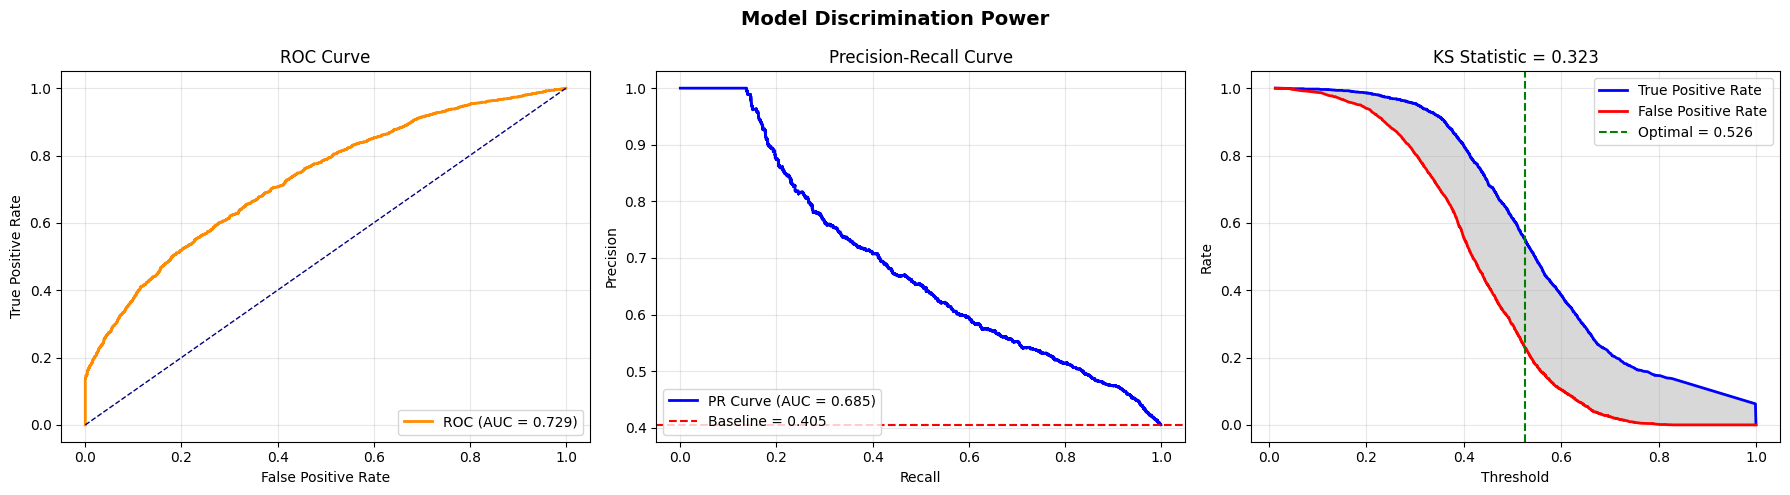

• ROC-AUC: 0.7294
• PR-AUC: 0.6847
• KS Statistic: 0.323 (MODERATE discrimination)
• Optimal Threshold: 0.526

💼 STEP 2: BUSINESS IMPACT
----------------------------------------
Verification of decile assignment:
Decile 1 mean prob: 0.881
Decile 10 mean prob: 0.196


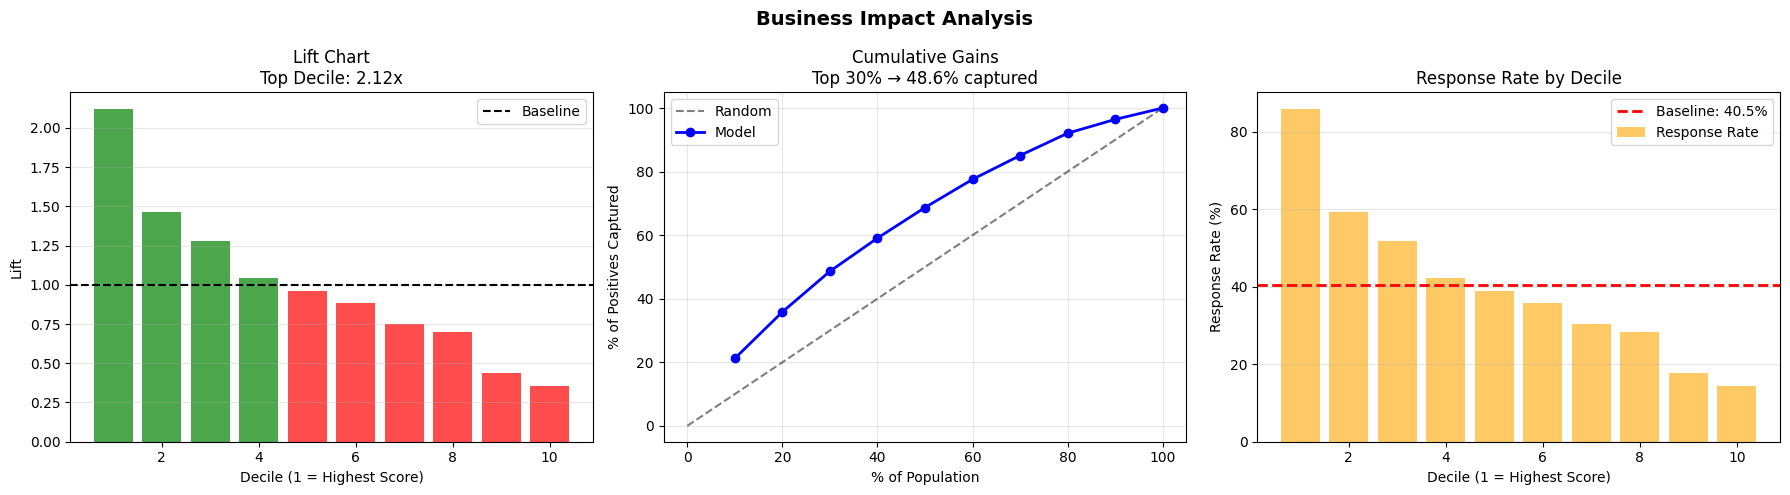

• Top Decile Lift: 0.36x
• Top 30% captures: 48.6% of positives
• Baseline response rate: 40.5%
• Top decile response: 85.9%

📈 STEP 4: CONFUSION MATRIX
----------------------------------------


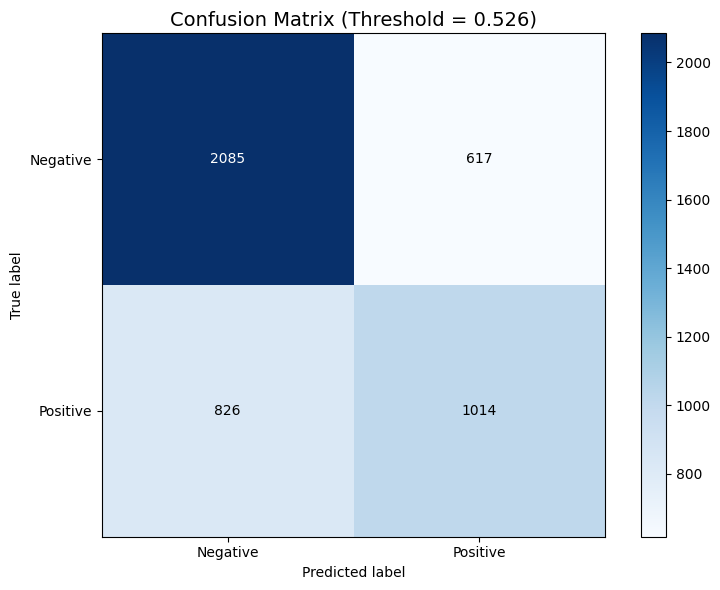

At threshold 0.526:
• Accuracy: 0.682
• Precision: 0.622
• Recall: 0.551
• F1-Score: 0.584
• True Positives: 1014
• False Positives: 617
• True Negatives: 2085
• False Negatives: 826

FINAL VALIDATION SUMMARY

✅ DISCRIMINATION POWER:
   KS Statistic: 0.323 (MODERATE discrimination)

✅ BUSINESS VALUE:
   Efficiency: 0.36x better than random
   Coverage: Top 30% → 48.6% captured

✅ MODEL QUALITY:
   ROC-AUC: 0.7294 (Excellent if >0.8)
   PR-AUC: 0.6847 (Excellent if >0.7)

✅ OPERATIONAL METRICS:
   Optimal Threshold: 0.526
   Precision at threshold: 0.622
   Recall at threshold: 0.551

FEATURE IMPORTANCE ANALYSIS

8. Analyzing feature importance...

Top 20 Most Important Features:
------------------------------------------------------------
 1. quote_consistency_score                  0.1382
 2. max_price                                0.0309
 3. season_summer                            0.0249
 4. brand_convergence                        0.0237
 5. primary_system_type                    

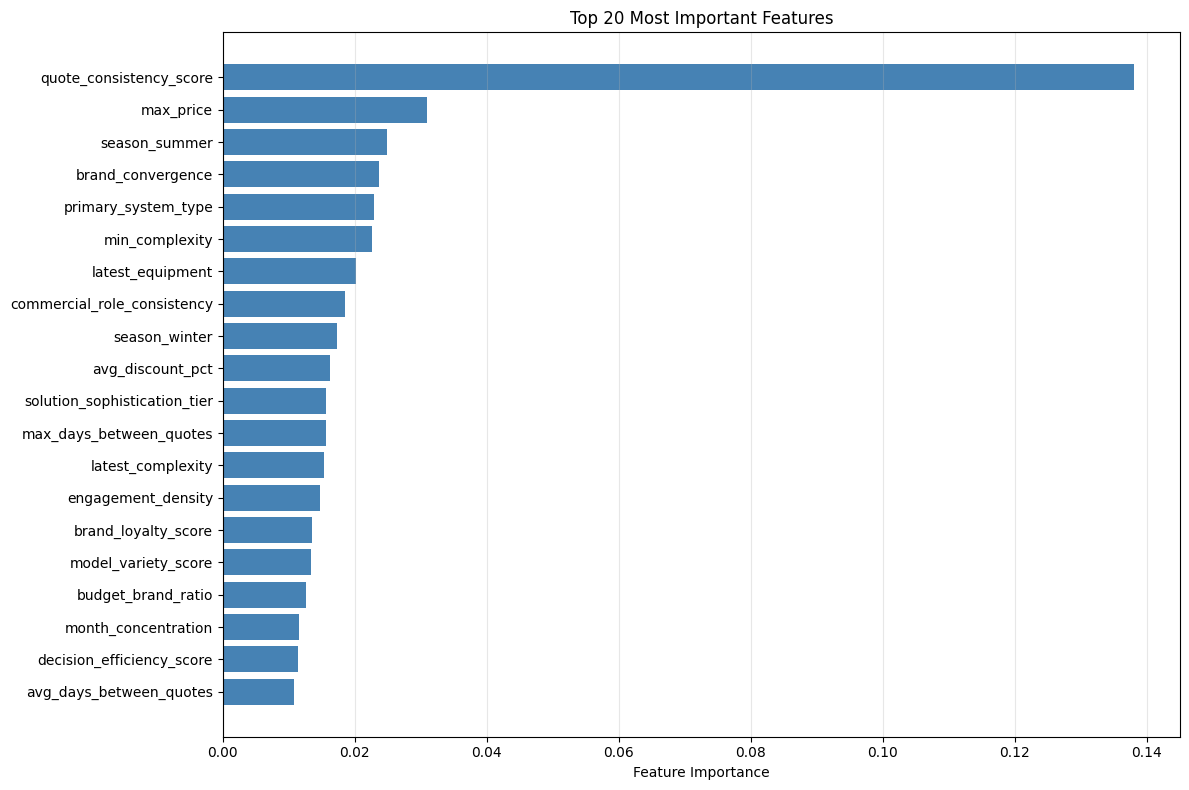

✓ Sampled customer IDs saved to: model_artifacts/sampled_customer_ids.json

BASELINE PREDICTIONS FOR SAMPLED CUSTOMERS

10. Creating baseline predictions for sampled customers...
Loaded quotes for 5 sampled customers

Processing customer CL00340061...

STRATEGY: CREATE FEATURES
Creating OPTIMIZED customer features (mode: first_conversion)...
  Filtering post-first-purchase data...
  Customers: 1, Quotes: 1
  Calculating features...
  Calculating price trajectory (optimized)...
✓ Created 14 leakage-free features
→ 1 customers | 0.0% converters
⏱️  Execution time: 0.0 seconds
✅ SUCCESS! Achieved ≤ 3s target
CREATING FIRST CONVERSION PREDICTION FEATURES (LEAKAGE-FREE)
  Total customers: 1
⚡ Processing customers with corrected first-conversion logic...
  Processed 0/1 customers
✅ First-conversion features calculation complete

🔍 VALIDATION REPORT:
   Total customers: 1
   First converters: 0 (0.0%)
   Never converters: 1

📊 Distribution check:
   Converters with 0 historical quotes: 0
   N

In [11]:
from ml_features.features import create_features
from ml_training import train_xgb

# Step 4: Model Training (Using Existing train_xgb Function)
# ===========================================================

print("\n" + "="*60)
print("STEP 4: MODEL TRAINING")
print("="*60)

# -------------------------------------------------------------
# 2. PREPARE TRAINING DATA
# -------------------------------------------------------------

print("\n2. Preparing training data...")

# Load the training data from our split
df_train = split_results['df_train'].copy()
print(f"Training data shape: {df_train.shape}")
print(f"Number of training customers: {df_train['numero_compte'].nunique()}")
print(f"Date range: {df_train['dt_creation_devis'].min()} to {df_train['dt_creation_devis'].max()}")

# Check conversion rate
train_conversion_rate = df_train['fg_devis_accepte'].mean() * 100
print(f"Training conversion rate: {train_conversion_rate:.2f}%")

# -------------------------------------------------------------
# 3. CREATE FEATURES USING YOUR EXISTING create_features FUNCTION
# -------------------------------------------------------------

print("\n3. Creating features using your existing create_features function...")

# Use your existing create_features function
print("Calling create_features() on training data...")
X_train_features = create_features(df_train)

print(f"\n✓ Features created successfully!")
print(f"Feature DataFrame shape: {X_train_features.shape}")
print(f"Number of features: {len(X_train_features.columns)}")

# Show first few columns
print(f"\nFirst 20 feature columns:")
print(X_train_features.columns[:20].tolist())

# Check if we have the expected ~205 features
print(f"\nTotal feature count: {len(X_train_features.columns)}")
if len(X_train_features.columns) > 200:
    print("✓ Good! We have the expected ~205 features")

# Check class distribution
class_distribution = X_train_features['converted'].value_counts()
print(f"\nClass distribution:")
print(f"Non-converted (0): {class_distribution.get(0, 0)} customers ({class_distribution.get(0, 0)/len(X_train_features)*100:.1f}%)")
print(f"Converted (1): {class_distribution.get(1, 0)} customers ({class_distribution.get(1, 0)/len(X_train_features)*100:.1f}%)")

# -------------------------------------------------------------
# 5. PREPARE DATA FOR TRAINING
# -------------------------------------------------------------

print("\n5. Preparing data for training...")

# Separate features and target
y_train = X_train_features['converted'].copy()

# Identify columns to exclude
exclude_cols = ['numero_compte', 'converted']
# Also exclude any columns that might be the target or identifiers
for col in ['fg_devis_accepte', 'fg_devis_accepte_max', 'fg_devis_accepte_sum']:
    if col in X_train_features.columns:
        exclude_cols.append(col)

X_train = X_train_features.drop(exclude_cols, axis=1, errors='ignore').copy()

# Get feature names
feature_names = X_train.columns.tolist()

print(f"Features shape: {X_train.shape}")
print(f"Target shape: {y_train.shape}")
print(f"Number of features: {len(feature_names)}")
print(f"\nFirst 10 features: {feature_names[:10]}")

# Check for missing values
missing_values = X_train.isnull().sum().sum()
if missing_values > 0:
    print(f"\nWarning: Found {missing_values} missing values in features")
    print("Filling missing values with 0...")
    X_train = X_train.fillna(0)

# -------------------------------------------------------------
# 6. TRAIN MODEL USING YOUR EXISTING train_xgb FUNCTION
# -------------------------------------------------------------

print("\n" + "="*60)
print("TRAINING MODEL WITH YOUR EXISTING train_xgb FUNCTION")
print("="*60)

print("\n6. Training XGBoost model using train_xgb()...")


# Call your existing train_xgb function
print("Calling train_xgb() function...")
from ml_training.train_xgb import train_xgb
result = train_xgb(X_train, y_train, "xgb_model__simulation_poc")

print(f"\n✓ Model trained successfully using train_xgb()!")
print(f"Model type: {type(model)}")
model = result['model']
# Check if model has the expected attributes
if hasattr(model, 'feature_importances_'):
    print(f"Model has feature importances: ✓")
if hasattr(model, 'predict_proba'):
    print(f"Model has predict_proba method: ✓")

# -------------------------------------------------------------
# 7. MODEL EVALUATION
# -------------------------------------------------------------
from ml_evaluation.dashboard import model_evaluation_report

df_test = result['X_test'].copy()
df_test['converted'] = result['y_test']
model_evaluation_report(df_test, result['model'], result['features'], 'converted')

# -------------------------------------------------------------
# 8. FEATURE IMPORTANCE ANALYSIS
# -------------------------------------------------------------

print("\n" + "="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)

print("\n8. Analyzing feature importance...")

if hasattr(model, 'feature_importances_'):
    # Get feature importance
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    })
    
    # Sort by importance
    feature_importance = feature_importance.sort_values('importance', ascending=False).reset_index(drop=True)
    
    print(f"\nTop 20 Most Important Features:")
    print("-" * 60)
    for i, row in feature_importance.head(20).iterrows():
        print(f"{i+1:2d}. {row['feature']:<40} {row['importance']:.4f}")
    
    # Visualize feature importance
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(12, 8))
    top_n = min(20, len(feature_importance))
    top_features = feature_importance.head(top_n)
    
    plt.barh(range(top_n), top_features['importance'][::-1], color='steelblue')
    plt.yticks(range(top_n), top_features['feature'][::-1])
    plt.xlabel('Feature Importance')
    plt.title(f'Top {top_n} Most Important Features')
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()
    
else:
    print("Model does not have feature_importances_ attribute")
    print("Creating dummy feature importance based on correlation...")
    
    # Calculate correlation with target as fallback
    correlations = []
    for col in X_train.columns:
        if X_train[col].std() > 0:  # Avoid constant columns
            corr = np.corrcoef(X_train[col], y_train)[0, 1]
            correlations.append((col, abs(corr)))
    
    feature_importance = pd.DataFrame(correlations, columns=['feature', 'importance'])
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    
    print(f"\nTop 10 Features by Absolute Correlation:")
    print("-" * 60)
    for i, row in feature_importance.head(10).iterrows():
        print(f"{i+1:2d}. {row['feature']:<40} {row['importance']:.4f}")

import os

# 6. Save sampled customer IDs for later use
sampled_customer_ids_path = 'model_artifacts/sampled_customer_ids.json'
with open('sampled_customer_ids.json', 'r') as f:
    sampled_customer_ids = json.load(f)
    
with open(sampled_customer_ids_path, 'w') as f:
    json.dump(sampled_customer_ids, f)
print(f"✓ Sampled customer IDs saved to: {sampled_customer_ids_path}")

# -------------------------------------------------------------
# 10. CREATE BASELINE PREDICTIONS FOR SAMPLED CUSTOMERS
# -------------------------------------------------------------

print("\n" + "="*60)
print("BASELINE PREDICTIONS FOR SAMPLED CUSTOMERS")
print("="*60)

print("\n10. Creating baseline predictions for sampled customers...")

# Load the sampled customers' quotes
sampled_customers_quotes = {}
for customer_id in sampled_customer_ids:
    filename = f'customer_{customer_id}_quotes.csv'
    if os.path.exists(filename):
        sampled_customers_quotes[customer_id] = pd.read_csv(filename)
    else:
        # Get from simulation pool
        sampled_customers_quotes[customer_id] = split_results['df_sim'][
            split_results['df_sim']['numero_compte'] == customer_id
        ].copy()

print(f"Loaded quotes for {len(sampled_customers_quotes)} sampled customers")

# Create baseline predictions
baseline_predictions = []

for customer_id, quotes_df in sampled_customers_quotes.items():
    print(f"\nProcessing customer {customer_id}...")
    
    # Create features for this customer using your create_features function
    customer_features = create_features(quotes_df)
    
    # Ensure all feature columns exist (match training features)
    for col in feature_names:
        if col not in customer_features.columns:
            customer_features[col] = 0
    
    # Reorder columns to match training
    customer_features = customer_features[['numero_compte'] + feature_names]
    
    # Make prediction
    X_customer = customer_features[feature_names]
    conversion_prob = model.predict_proba(X_customer)[:, 1][0]
    
    # Store result
    baseline_predictions.append({
        'customer_id': customer_id,
        'quote_count': len(quotes_df),
        'baseline_conversion_probability': conversion_prob,
        'predicted_class': int(conversion_prob >= 0.5),
        'most_common_product': quotes_df['famille_equipement_produit'].mode().iloc[0] if len(quotes_df) > 0 else 'Unknown',
        'most_common_status': quotes_df['statut_devis'].mode().iloc[0] if len(quotes_df) > 0 else 'Unknown',
        'total_quote_value': quotes_df['mt_apres_remise_ht_devis'].sum()
    })
    
    print(f"  Baseline conversion probability: {conversion_prob:.3f}")


# Convert to DataFrame
baseline_df = pd.DataFrame(baseline_predictions)

print(f"\n📊 BASELINE PREDICTIONS SUMMARY:")
print("-" * 50)
for idx, row in baseline_df.iterrows():
    if row['baseline_conversion_probability'] is not None:
        print(f"Customer {row['customer_id']}: {row['baseline_conversion_probability']:.3f} probability")

# Save baseline predictions
baseline_path = 'model_artifacts/baseline_predictions.csv'
baseline_df.to_csv(baseline_path, index=False)
print(f"\n✓ Baseline predictions saved to: {baseline_path}")



In [12]:
# Step 5: Define Simulation Scenarios
# ===================================

print("\n" + "="*60)
print("STEP 5: DEFINE SIMULATION SCENARIOS")
print("="*60)

print("\nObjective: Define realistic scenarios that sales can influence")
print("to see how they affect conversion probability")

# -------------------------------------------------------------
# 1. ANALYZE MODIFIABLE PROPERTIES
# -------------------------------------------------------------

print("\n1. Analyzing modifiable properties in the data...")

# Look at columns that sales can realistically influence
modifiable_columns = [
    'mt_remise_exceptionnelle_ht',  # Discount amount
    'famille_equipement_produit',   # Product family
    'type_equipement_produit',      # Product type
    'prenom_nom_commercial',        # Sales representative
    'nom_campagne',                 # Campaign
    'fg_activite_commerciale',      # Commercial activity flag
]

print("Columns that sales can influence:")
for col in modifiable_columns:
    if col in df_quotes.columns:
        print(f"  ✓ {col}")
    else:
        print(f"  ✗ {col} (not in data)")

# Check unique values for categorical columns
print("\nUnique values analysis:")
if 'famille_equipement_produit' in df_quotes.columns:
    product_counts = df_quotes['famille_equipement_produit'].value_counts().head(10)
    print(f"\nTop 10 product families:")
    for product, count in product_counts.items():
        print(f"  {product}: {count} quotes")

if 'prenom_nom_commercial' in df_quotes.columns:
    rep_counts = df_quotes['prenom_nom_commercial'].value_counts().head(10)
    print(f"\nTop 10 sales representatives:")
    for rep, count in rep_counts.items():
        print(f"  {rep}: {count} quotes")

# Analyze discount patterns
if 'mt_remise_exceptionnelle_ht' in df_quotes.columns:
    discount_stats = df_quotes['mt_remise_exceptionnelle_ht'].describe()
    print(f"\nDiscount statistics:")
    print(f"  Mean: €{discount_stats['mean']:,.2f}")
    print(f"  Max: €{discount_stats['max']:,.2f}")
    print(f"  75th percentile: €{discount_stats['75%']:,.2f}")

# -------------------------------------------------------------
# 2. DEFINE SIMULATION SCENARIOS
# -------------------------------------------------------------

print("\n" + "="*60)
print("DEFINING SIMULATION SCENARIOS")
print("="*60)

# Define realistic simulation scenarios
simulation_scenarios = {
    'increase_discount_small': {
        'description': 'Increase discount by 10%',
        'type': 'discount',
        'change': '+10%',
        'business_impact': 'Low cost, might improve conversion',
        'realistic': True,
        'function': 'apply_discount_increase'
    },
    'increase_discount_medium': {
        'description': 'Increase discount by 25%',
        'type': 'discount',
        'change': '+25%',
        'business_impact': 'Moderate cost, better conversion chance',
        'realistic': True,
        'function': 'apply_discount_increase'
    },
    'increase_discount_large': {
        'description': 'Increase discount by 50%',
        'type': 'discount',
        'change': '+50%',
        'business_impact': 'High cost, likely improves conversion',
        'realistic': 'Margin check needed',
        'function': 'apply_discount_increase'
    },
    'change_to_popular_product': {
        'description': 'Change to most popular product in category',
        'type': 'product',
        'change': 'Switch to top-selling product',
        'business_impact': 'Better product-market fit',
        'realistic': True,
        'function': 'change_product'
    },
    'assign_best_sales_rep': {
        'description': 'Assign customer to best-performing sales rep',
        'type': 'sales_rep',
        'change': 'Assign to top rep',
        'business_impact': 'Better sales skills, relationship',
        'realistic': 'Capacity constraints',
        'function': 'change_sales_rep'
    },
    'add_followup_quote': {
        'description': 'Add a follow-up quote after 7 days',
        'type': 'engagement',
        'change': '+1 follow-up quote',
        'business_impact': 'Increased engagement, reminder',
        'realistic': True,
        'function': 'add_followup_quote'
    },
    'bundle_offer': {
        'description': 'Create bundled offer (multiple products)',
        'type': 'product',
        'change': 'Add complementary product',
        'business_impact': 'Higher value, better solution',
        'realistic': 'Inventory/installation constraints',
        'function': 'create_bundle'
    }
}

print(f"\nDefined {len(simulation_scenarios)} simulation scenarios:")
print("-" * 70)
for scenario_id, details in simulation_scenarios.items():
    print(f"\n{scenario_id}:")
    print(f"  Description: {details['description']}")
    print(f"  Type: {details['type']}")
    print(f"  Change: {details['change']}")
    print(f"  Realistic: {details['realistic']}")

# -------------------------------------------------------------
# 3. CREATE SIMULATION FUNCTIONS
# -------------------------------------------------------------

print("\n" + "="*60)
print("CREATING SIMULATION FUNCTIONS")
print("="*60)

import numpy as np
from datetime import timedelta

def apply_discount_increase(df_quotes, customer_id, increase_pct):
    """
    Increase discount for a specific customer.
    
    Args:
        df_quotes: DataFrame with all quotes
        customer_id: Customer to modify
        increase_pct: Percentage increase (e.g., 10 for 10%)
    
    Returns:
        Modified DataFrame
    """
    df_modified = df_quotes.copy()
    mask = df_modified['numero_compte'] == customer_id
    
    # Increase discount by percentage
    current_discount = df_modified.loc[mask, 'mt_remise_exceptionnelle_ht']
    df_modified.loc[mask, 'mt_remise_exceptionnelle_ht'] = current_discount * (1 + increase_pct/100)
    
    # Also adjust the total price if it exists
    if 'mt_apres_remise_ht_devis' in df_modified.columns:
        df_modified.loc[mask, 'mt_apres_remise_ht_devis'] = df_modified.loc[mask, 'mt_apres_remise_ht_devis'] - current_discount * (increase_pct/100)
    
    print(f"  Applied {increase_pct}% discount increase to customer {customer_id}")
    print(f"  New average discount: €{df_modified.loc[mask, 'mt_remise_exceptionnelle_ht'].mean():.2f}")
    
    return df_modified

def change_product(df_quotes, customer_id, target_product=None):
    """
    Change customer's product to a different one.
    
    Args:
        df_quotes: DataFrame with all quotes
        customer_id: Customer to modify
        target_product: Specific product to change to (if None, use most popular)
    
    Returns:
        Modified DataFrame
    """
    df_modified = df_quotes.copy()
    mask = df_modified['numero_compte'] == customer_id
    
    if target_product is None:
        # Find most popular product overall (from training data)
        most_popular = df_train['famille_equipement_produit'].mode()
        if len(most_popular) > 0:
            target_product = most_popular[0]
        else:
            target_product = 'Chaudière'  # Default fallback
    
    # Change product for all quotes
    original_product = df_modified.loc[mask, 'famille_equipement_produit'].iloc[0] if mask.any() else 'Unknown'
    df_modified.loc[mask, 'famille_equipement_produit'] = target_product
    
    print(f"  Changed product from '{original_product}' to '{target_product}' for customer {customer_id}")
    
    return df_modified

def change_sales_rep(df_quotes, customer_id, new_rep=None):
    """
    Change sales representative for a customer.
    
    Args:
        df_quotes: DataFrame with all quotes
        customer_id: Customer to modify
        new_rep: Specific sales rep (if None, use best-performing)
    
    Returns:
        Modified DataFrame
    """
    df_modified = df_quotes.copy()
    mask = df_modified['numero_compte'] == customer_id
    
    if new_rep is None:
        # Find best-performing sales rep (highest conversion rate)
        if 'prenom_nom_commercial' in df_train.columns and 'fg_devis_accepte' in df_train.columns:
            rep_performance = df_train.groupby('prenom_nom_commercial')['fg_devis_accepte'].mean()
            if len(rep_performance) > 0:
                new_rep = rep_performance.idxmax()
            else:
                new_rep = df_train['prenom_nom_commercial'].mode()[0] if 'prenom_nom_commercial' in df_train.columns else 'Best_Rep'
        else:
            new_rep = 'Best_Rep'
    
    # Change sales rep
    original_rep = df_modified.loc[mask, 'prenom_nom_commercial'].iloc[0] if mask.any() else 'Unknown'
    df_modified.loc[mask, 'prenom_nom_commercial'] = new_rep
    
    print(f"  Changed sales rep from '{original_rep}' to '{new_rep}' for customer {customer_id}")
    
    return df_modified

def add_followup_quote(df_quotes, customer_id, days_after=7):
    """
    Add a follow-up quote to increase engagement.
    
    Args:
        df_quotes: DataFrame with all quotes
        customer_id: Customer to modify
        days_after: Days after last quote to add follow-up
    
    Returns:
        Modified DataFrame
    """
    df_modified = df_quotes.copy()
    mask = df_modified['numero_compte'] == customer_id
    
    if not mask.any():
        print(f"  Customer {customer_id} not found in data")
        return df_modified
    
    # Get customer's last quote
    customer_quotes = df_modified[mask]
    last_quote = customer_quotes.iloc[-1].copy()
    
    # Create follow-up quote
    followup_quote = last_quote.copy()
    
    # Modify date
    last_date = pd.to_datetime(last_quote['dt_creation_devis'])
    followup_date = last_date + timedelta(days=days_after)
    followup_quote['dt_creation_devis'] = followup_date
    
    # Modify quote ID (create new ID)
    max_id = df_modified['id_devis'].max() if 'id_devis' in df_modified.columns else 0
    followup_quote['id_devis'] = max_id + 1
    
    # Add "Follow-up" to quote name if column exists
    if 'nom_devis' in followup_quote:
        followup_quote['nom_devis'] = f"{followup_quote['nom_devis']} (Follow-up)"
    
    # Add small discount incentive (5%)
    if 'mt_remise_exceptionnelle_ht' in followup_quote:
        followup_quote['mt_remise_exceptionnelle_ht'] = followup_quote.get('mt_remise_exceptionnelle_ht', 0) * 1.05
    
    # Add to DataFrame
    df_modified = pd.concat([df_modified, pd.DataFrame([followup_quote])], ignore_index=True)
    
    print(f"  Added follow-up quote for customer {customer_id} on {followup_date.strftime('%Y-%m-%d')}")
    print(f"  Total quotes for customer: {len(customer_quotes) + 1}")
    
    return df_modified

def create_bundle(df_quotes, customer_id, bundle_product=None):
    """
    Create a bundled offer by adding complementary products.
    
    Args:
        df_quotes: DataFrame with all quotes
        customer_id: Customer to modify
        bundle_product: Product to add to bundle
    
    Returns:
        Modified DataFrame
    """
    df_modified = df_quotes.copy()
    mask = df_modified['numero_compte'] == customer_id
    
    if not mask.any():
        print(f"  Customer {customer_id} not found in data")
        return df_modified
    
    # Get customer's current product
    customer_quotes = df_modified[mask]
    current_product = customer_quotes['famille_equipement_produit'].iloc[0] if len(customer_quotes) > 0 else 'Unknown'
    
    # Define complementary products (simplified logic)
    complementary_map = {
        'Chaudière': 'ECS : Chauffe-eau ou adoucisseur',
        'Pompe à chaleur': 'Climatisation',
        'Poêle': 'Chaudière',
        'Climatisation': 'Pompe à chaleur',
        'ECS : Chauffe-eau ou adoucisseur': 'Chaudière'
    }
    
    if bundle_product is None:
        bundle_product = complementary_map.get(current_product, 'Chaudière')
    
    # Create bundle quote
    last_quote = customer_quotes.iloc[-1].copy()
    bundle_quote = last_quote.copy()
    
    # Modify product
    bundle_quote['famille_equipement_produit'] = bundle_product
    
    # Modify quote ID and name
    max_id = df_modified['id_devis'].max() if 'id_devis' in df_modified.columns else 0
    bundle_quote['id_devis'] = max_id + 1
    
    if 'nom_devis' in bundle_quote:
        bundle_quote['nom_devis'] = f"Bundle: {current_product} + {bundle_product}"
    
    # Adjust price (add 30% of original for bundle)
    if 'mt_apres_remise_ht_devis' in bundle_quote:
        bundle_quote['mt_apres_remise_ht_devis'] = bundle_quote['mt_apres_remise_ht_devis'] * 1.3
    
    # Add bundle discount (10%)
    if 'mt_remise_exceptionnelle_ht' in bundle_quote:
        bundle_quote['mt_remise_exceptionnelle_ht'] = bundle_quote['mt_remise_exceptionnelle_ht'] * 1.1
    
    # Add to DataFrame
    df_modified = pd.concat([df_modified, pd.DataFrame([bundle_quote])], ignore_index=True)
    
    print(f"  Created bundle offer: {current_product} + {bundle_product} for customer {customer_id}")
    print(f"  Bundle price: €{bundle_quote.get('mt_apres_remise_ht_devis', 0):,.2f}")
    
    return df_modified

# Map scenario IDs to functions
scenario_functions = {
    'increase_discount_small': lambda df, cust: apply_discount_increase(df, cust, 10),
    'increase_discount_medium': lambda df, cust: apply_discount_increase(df, cust, 25),
    'increase_discount_large': lambda df, cust: apply_discount_increase(df, cust, 50),
    'change_to_popular_product': lambda df, cust: change_product(df, cust),
    'assign_best_sales_rep': lambda df, cust: change_sales_rep(df, cust),
    'add_followup_quote': lambda df, cust: add_followup_quote(df, cust, 7),
    'bundle_offer': lambda df, cust: create_bundle(df, cust)
}

print(f"\n✓ Created {len(scenario_functions)} simulation functions")
print("Functions available:")
for func_name in scenario_functions.keys():
    print(f"  - {func_name}")

# -------------------------------------------------------------
# 4. TEST SIMULATION FUNCTIONS
# -------------------------------------------------------------

print("\n" + "="*60)
print("TESTING SIMULATION FUNCTIONS")
print("="*60)

# Test with first customer
test_customer = sampled_customer_ids[0]
print(f"\nTesting simulation functions on customer {test_customer}...")

# Get customer's original quotes
original_quotes = sampled_customers_quotes[test_customer].copy()
print(f"Original quotes: {len(original_quotes)}")

# Test each function
for scenario_id, scenario_func in list(scenario_functions.items())[:3]:  # Test first 3
    print(f"\nTesting {scenario_id}...")
    
    try:
        # Apply simulation
        modified_quotes = scenario_func(original_quotes.copy(), test_customer)
        
        # Check changes
        print(f"  Original quotes: {len(original_quotes)}")
        print(f"  Modified quotes: {len(modified_quotes)}")
        
        # Check specific changes
        if scenario_id.startswith('increase_discount'):
            orig_discount = original_quotes['mt_remise_exceptionnelle_ht'].sum()
            new_discount = modified_quotes['mt_remise_exceptionnelle_ht'].sum()
            print(f"  Discount change: €{orig_discount:,.2f} → €{new_discount:,.2f}")
        
        print(f"  ✓ {scenario_id} worked successfully")
        
    except Exception as e:
        print(f"  ✗ {scenario_id} failed: {e}")

# -------------------------------------------------------------
# 5. SAVE SIMULATION DEFINITIONS
# -------------------------------------------------------------

print("\n" + "="*60)
print("SAVING SIMULATION DEFINITIONS")
print("="*60)

import json

# Save scenario definitions
scenario_definitions = {
    'scenarios': simulation_scenarios,
    'scenario_functions': list(scenario_functions.keys()),
    'sampled_customers': sampled_customer_ids,
    'baseline_predictions': baseline_df.set_index('customer_id')['baseline_conversion_probability'].to_dict()
}

with open('simulation_definitions.json', 'w') as f:
    json.dump(scenario_definitions, f, indent=2, default=str)

print(f"✓ Simulation definitions saved to: simulation_definitions.json")

# Save simulation functions reference
functions_reference = {
    'apply_discount_increase': 'Increase discount by percentage',
    'change_product': 'Change product family',
    'change_sales_rep': 'Change sales representative',
    'add_followup_quote': 'Add follow-up quote',
    'create_bundle': 'Create bundled offer'
}

with open('simulation_functions_reference.json', 'w') as f:
    json.dump(functions_reference, f, indent=2)

print(f"✓ Simulation functions reference saved")

# -------------------------------------------------------------
# 6. PREPARE FOR STEP 6
# -------------------------------------------------------------

print("\n" + "="*60)
print("STEP 5 COMPLETED SUCCESSFULLY!")
print("="*60)

print(f"\n✅ Defined {len(simulation_scenarios)} realistic simulation scenarios")
print(f"✅ Created {len(scenario_functions)} simulation functions")
print(f"✅ Tested functions on customer {test_customer}")
print(f"✅ Saved all definitions and references")

print(f"\n📊 Baseline predictions for simulation:")
for customer_id in sampled_customer_ids:
    baseline_prob = baseline_df[baseline_df['customer_id'] == customer_id]['baseline_conversion_probability'].iloc[0]
    print(f"  {customer_id}: {baseline_prob:.3f} probability")

print(f"\n🎯 Next step: Run simulations for all customers and scenarios")
print(f"   We'll modify customer data, recreate features, and measure probability changes")
print(f"\n➡️  Ready for Step 6: Run Simulations")


STEP 5: DEFINE SIMULATION SCENARIOS

Objective: Define realistic scenarios that sales can influence
to see how they affect conversion probability

1. Analyzing modifiable properties in the data...
Columns that sales can influence:
  ✓ mt_remise_exceptionnelle_ht
  ✓ famille_equipement_produit
  ✓ type_equipement_produit
  ✓ prenom_nom_commercial
  ✓ nom_campagne
  ✓ fg_activite_commerciale

Unique values analysis:

Top 10 product families:
  Chaudière: 9937 quotes
  Poêle: 7432 quotes
  Climatisation: 6664 quotes
  Pompe à chaleur: 6370 quotes
  ECS : Chauffe-eau ou adoucisseur: 1518 quotes
  Photovoltaïque: 958 quotes
  Autres: 387 quotes
  Appareil hybride: 201 quotes
  Produit VMC: 159 quotes
  Emetteur de chauffage  ou chappe: 148 quotes

Top 10 sales representatives:
  JOHAN GIFFAUT: 2505 quotes
  Lucas DONATI: 2038 quotes
  YAN LAHOUSSE: 1329 quotes
  FREDDY VEZILIER: 1249 quotes
  Gary LEFEVRE: 1159 quotes
  David CAPELLI: 1075 quotes
  Valentin GROULT: 988 quotes
  Florian LEM

In [13]:
# Step 6: Run Simulations
# =======================

print("\n" + "="*60)
print("STEP 6: RUN SIMULATIONS")
print("="*60)

print("\nObjective: Apply each simulation scenario to each customer")
print("and measure the change in conversion probability")

# -------------------------------------------------------------
# 1. PREPARATION
# -------------------------------------------------------------

print("\n1. Preparation...")

# Load baseline predictions
baseline_df = pd.read_csv('model_artifacts/baseline_predictions.csv')
baseline_predictions = dict(zip(baseline_df['customer_id'], baseline_df['baseline_conversion_probability']))

print(f"Loaded baseline predictions for {len(baseline_predictions)} customers")
print(f"Baseline probabilities: {baseline_predictions}")

# Load model and feature names
import joblib
model = joblib.load('model_artifacts/xgboost_conversion_model.pkl')
feature_names = joblib.load('model_artifacts/feature_names.pkl')

print(f"Model loaded: {type(model)}")
print(f"Number of features: {len(feature_names)}")

# Load all sampled customer quotes
print("\nLoading all sampled customer quotes...")
all_sampled_quotes = pd.read_csv('all_sampled_customers_quotes.csv')
print(f"All quotes shape: {all_sampled_quotes.shape}")

# Create a mapping of customer to their original quotes
customer_quotes_dict = {}
for customer_id in sampled_customer_ids:
    customer_quotes = all_sampled_quotes[all_sampled_quotes['numero_compte'] == customer_id].copy()
    customer_quotes_dict[customer_id] = customer_quotes
    print(f"  {customer_id}: {len(customer_quotes)} quotes")

# -------------------------------------------------------------
# 2. SIMULATION PIPELINE FUNCTION
# -------------------------------------------------------------

print("\n" + "="*60)
print("CREATING SIMULATION PIPELINE")
print("="*60)

def run_simulation_pipeline(customer_id, original_quotes, scenario_func, scenario_name):
    """
    Run full simulation pipeline for one customer and one scenario.
    
    Returns:
        Dictionary with simulation results
    """
    print(f"\n  Running {scenario_name} for customer {customer_id}...")
    
    # Step 1: Apply simulation scenario
    try:
        modified_quotes = scenario_func(original_quotes.copy(), customer_id)
        
        # Check if quotes were modified
        quotes_changed = len(modified_quotes) != len(original_quotes)
        print(f"    Quotes: {len(original_quotes)} → {len(modified_quotes)}")
        
    except Exception as e:
        print(f"    ✗ Error applying scenario: {e}")
        return None
    
    # Step 2: Create features for modified data
    try:
        # Combine with other customers to ensure all features are created
        # First, get all other customers' original quotes
        other_customers_quotes = []
        for other_id in sampled_customer_ids:
            if other_id != customer_id:
                other_customers_quotes.append(customer_quotes_dict[other_id])
        
        if other_customers_quotes:
            # Combine modified quotes with other customers' quotes
            combined_quotes = pd.concat([modified_quotes] + other_customers_quotes, ignore_index=True)
        else:
            combined_quotes = modified_quotes
        
        # Create features
        all_features = create_features(combined_quotes)
        
        # Extract just this customer's features
        customer_features = all_features[all_features['numero_compte'] == customer_id].copy()
        
        if len(customer_features) == 0:
            print(f"    ⚠️ No features created for customer")
            # Create dummy features
            customer_features = pd.DataFrame({'numero_compte': [customer_id]})
            for feature in feature_names:
                customer_features[feature] = 0
        
        # Ensure all feature columns exist
        for feature in feature_names:
            if feature not in customer_features.columns:
                customer_features[feature] = 0
        
        # Reorder columns
        customer_features = customer_features[['numero_compte'] + feature_names]
        
        print(f"    Features created: {customer_features.shape}")
        
    except Exception as e:
        print(f"    ✗ Error creating features: {e}")
        return None
    
    # Step 3: Make prediction
    try:
        X_customer = customer_features[feature_names]
        new_probability = model.predict_proba(X_customer)[:, 1][0]
        
        # Get baseline probability
        baseline_probability = baseline_predictions.get(customer_id, 0.5)
        
        # Calculate changes
        probability_delta = new_probability - baseline_probability
        percentage_change = (probability_delta / baseline_probability * 100) if baseline_probability > 0 else 0
        
        print(f"    Prediction: {new_probability:.3f} (baseline: {baseline_probability:.3f})")
        print(f"    Delta: {probability_delta:+.3f} ({percentage_change:+.1f}%)")
        
        # Step 4: Return results
        result = {
            'customer_id': customer_id,
            'scenario': scenario_name,
            'baseline_probability': baseline_probability,
            'new_probability': new_probability,
            'probability_delta': probability_delta,
            'percentage_change': percentage_change,
            'quotes_before': len(original_quotes),
            'quotes_after': len(modified_quotes),
            'quotes_added': len(modified_quotes) - len(original_quotes),
            'success': True
        }
        
        # Add specific changes based on scenario type
        if 'discount' in scenario_name:
            orig_discount = original_quotes['mt_remise_exceptionnelle_ht'].sum()
            new_discount = modified_quotes['mt_remise_exceptionnelle_ht'].sum()
            result['discount_change'] = new_discount - orig_discount
        
        if 'product' in scenario_name and 'famille_equipement_produit' in original_quotes.columns:
            orig_product = original_quotes['famille_equipement_produit'].iloc[0]
            new_product = modified_quotes['famille_equipement_produit'].iloc[0]
            result['product_change'] = f"{orig_product} → {new_product}"
        
        return result
        
    except Exception as e:
        print(f"    ✗ Error making prediction: {e}")
        return None

# -------------------------------------------------------------
# 3. RUN ALL SIMULATIONS
# -------------------------------------------------------------

print("\n" + "="*60)
print("RUNNING ALL SIMULATIONS")
print("="*60)

# Initialize results storage
simulation_results = []
failed_simulations = []

# Count total simulations
total_simulations = len(sampled_customer_ids) * len(scenario_functions)
print(f"\nRunning {total_simulations} simulations...")
print(f"Customers: {len(sampled_customer_ids)}")
print(f"Scenarios: {len(scenario_functions)}")
print("-" * 70)

simulation_count = 0

# Run simulation for each customer and scenario
for customer_id in sampled_customer_ids:
    print(f"\n📊 CUSTOMER: {customer_id}")
    print(f"Baseline probability: {baseline_predictions.get(customer_id, 'N/A'):.3f}")
    print(f"Original quotes: {len(customer_quotes_dict[customer_id])}")
    
    for scenario_name, scenario_func in scenario_functions.items():
        simulation_count += 1
        print(f"\n[{simulation_count}/{total_simulations}] ", end="")
        
        # Run simulation
        result = run_simulation_pipeline(
            customer_id, 
            customer_quotes_dict[customer_id],
            scenario_func,
            scenario_name
        )
        
        if result:
            simulation_results.append(result)
            # Print summary
            delta = result['probability_delta']
            print(f"    Result: {delta:+.3f} Δ ({result['percentage_change']:+.1f}%)")
        else:
            failed_simulations.append((customer_id, scenario_name))
            print(f"    Failed")

print("\n" + "="*60)
print("SIMULATION COMPLETE")
print("="*60)

print(f"\n✅ Successful simulations: {len(simulation_results)}/{total_simulations}")
if failed_simulations:
    print(f"⚠️  Failed simulations: {len(failed_simulations)}")
    for customer_id, scenario in failed_simulations[:5]:  # Show first 5 failures
        print(f"  - {customer_id}: {scenario}")

# -------------------------------------------------------------
# 4. ANALYZE RESULTS
# -------------------------------------------------------------

print("\n" + "="*60)
print("ANALYZING SIMULATION RESULTS")
print("="*60)

# Convert results to DataFrame
results_df = pd.DataFrame(simulation_results)

if len(results_df) > 0:
    print(f"\nResults DataFrame shape: {results_df.shape}")
    print(f"\nFirst few results:")
    print(results_df[['customer_id', 'scenario', 'baseline_probability', 
                      'new_probability', 'probability_delta']].head())
    
    # Calculate summary statistics
    print("\n📈 OVERALL SIMULATION IMPACT:")
    print("-" * 50)
    
    avg_delta = results_df['probability_delta'].mean()
    max_delta = results_df['probability_delta'].max()
    min_delta = results_df['probability_delta'].min()
    
    print(f"Average probability change: {avg_delta:+.3f}")
    print(f"Maximum improvement: {max_delta:+.3f}")
    print(f"Minimum improvement: {min_delta:+.3f}")
    
    # Count positive/negative impacts
    positive_impacts = (results_df['probability_delta'] > 0).sum()
    negative_impacts = (results_df['probability_delta'] < 0).sum()
    neutral_impacts = (results_df['probability_delta'] == 0).sum()
    
    print(f"\nImpact distribution:")
    print(f"  Positive impacts: {positive_impacts} ({positive_impacts/len(results_df)*100:.1f}%)")
    print(f"  Negative impacts: {negative_impacts} ({negative_impacts/len(results_df)*100:.1f}%)")
    print(f"  Neutral impacts: {neutral_impacts} ({neutral_impacts/len(results_df)*100:.1f}%)")
    
    # Analyze by scenario
    print("\n📊 IMPACT BY SCENARIO:")
    print("-" * 50)
    
    scenario_stats = results_df.groupby('scenario').agg({
        'probability_delta': ['mean', 'max', 'min', 'count'],
        'percentage_change': 'mean'
    }).round(3)
    
    scenario_stats.columns = ['avg_delta', 'max_delta', 'min_delta', 'count', 'avg_pct_change']
    scenario_stats = scenario_stats.sort_values('avg_delta', ascending=False)
    
    print(scenario_stats)
    
    # Analyze by customer
    print("\n📊 IMPACT BY CUSTOMER:")
    print("-" * 50)
    
    customer_stats = results_df.groupby('customer_id').agg({
        'probability_delta': ['mean', 'max', 'min'],
        'baseline_probability': 'first'
    }).round(3)
    
    customer_stats.columns = ['avg_delta', 'max_delta', 'min_delta', 'baseline_prob']
    customer_stats = customer_stats.sort_values('avg_delta', ascending=False)
    
    print(customer_stats)
    
    # Find best scenarios for each customer
    print("\n🎯 BEST SCENARIO FOR EACH CUSTOMER:")
    print("-" * 50)
    
    for customer_id in sampled_customer_ids:
        customer_results = results_df[results_df['customer_id'] == customer_id]
        if len(customer_results) > 0:
            best_result = customer_results.loc[customer_results['probability_delta'].idxmax()]
            print(f"\n{customer_id} (baseline: {best_result['baseline_probability']:.3f}):")
            print(f"  Best scenario: {best_result['scenario']}")
            print(f"  New probability: {best_result['new_probability']:.3f}")
            print(f"  Improvement: {best_result['probability_delta']:+.3f} ({best_result['percentage_change']:+.1f}%)")
    
    # Find overall best scenario
    print("\n🏆 OVERALL BEST SCENARIOS:")
    print("-" * 50)
    
    # Top 3 scenarios by average improvement
    top_scenarios = scenario_stats.nlargest(3, 'avg_delta')
    for i, (scenario, stats) in enumerate(top_scenarios.iterrows(), 1):
        print(f"\n{i}. {scenario}:")
        print(f"   Average improvement: {stats['avg_delta']:.3f}")
        print(f"   Max improvement: {stats['max_delta']:.3f}")
        print(f"   Affected {stats['count']} customers")

else:
    print("⚠️ No simulation results to analyze")

# -------------------------------------------------------------
# 5. SAVE RESULTS
# -------------------------------------------------------------

print("\n" + "="*60)
print("SAVING SIMULATION RESULTS")
print("="*60)

# Save detailed results
results_path = 'simulation_results_detailed.csv'
results_df.to_csv(results_path, index=False)
print(f"✓ Detailed results saved to: {results_path}")

# Save summary statistics
summary = {
    'total_simulations_run': total_simulations,
    'successful_simulations': len(results_df),
    'failed_simulations': len(failed_simulations),
    'overall_avg_delta': float(avg_delta) if len(results_df) > 0 else 0,
    'best_scenario': scenario_stats.index[0] if len(scenario_stats) > 0 else None,
    'best_scenario_avg_delta': float(scenario_stats.iloc[0]['avg_delta']) if len(scenario_stats) > 0 else None,
    'most_improved_customer': customer_stats.index[0] if len(customer_stats) > 0 else None,
    'simulation_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
}

summary_path = 'simulation_summary.json'
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2)

print(f"✓ Summary saved to: {summary_path}")

# Save scenario impacts
scenario_impacts_path = 'scenario_impacts.csv'
scenario_stats.to_csv(scenario_impacts_path)
print(f"✓ Scenario impacts saved to: {scenario_impacts_path}")

# Save customer impacts
customer_impacts_path = 'customer_impacts.csv'
customer_stats.to_csv(customer_impacts_path)
print(f"✓ Customer impacts saved to: {customer_impacts_path}")

# -------------------------------------------------------------
# 6. PREPARE FOR VISUALIZATION
# -------------------------------------------------------------

print("\n" + "="*60)
print("PREPARING FOR VISUALIZATION")
print("="*60)

# Create a pivot table for heatmap
if len(results_df) > 0:
    heatmap_data = results_df.pivot_table(
        index='customer_id',
        columns='scenario',
        values='probability_delta',
        aggfunc='mean'
    )
    
    heatmap_path = 'simulation_heatmap_data.csv'
    heatmap_data.to_csv(heatmap_path)
    print(f"✓ Heatmap data saved to: {heatmap_path}")
    
    # Create before-after comparison
    comparison_data = results_df[['customer_id', 'scenario', 'baseline_probability', 'new_probability']].copy()
    comparison_path = 'before_after_comparison.csv'
    comparison_data.to_csv(comparison_path, index=False)
    print(f"✓ Before-after comparison saved to: {comparison_path}")

# -------------------------------------------------------------
# 7. FINAL SUMMARY
# -------------------------------------------------------------

print("\n" + "="*60)
print("STEP 6 COMPLETED SUCCESSFULLY!")
print("="*60)

print(f"\n🎯 SIMULATION RESULTS SUMMARY:")
print("-" * 50)

if len(results_df) > 0:
    print(f"Total simulations run: {total_simulations}")
    print(f"Successful: {len(results_df)} ({len(results_df)/total_simulations*100:.1f}%)")
    print(f"Failed: {len(failed_simulations)} ({len(failed_simulations)/total_simulations*100:.1f}%)")
    
    print(f"\n📈 Overall average impact: {avg_delta:+.3f} probability change")
    print(f"📊 Positive impacts: {positive_impacts} scenarios")
    print(f"📉 Negative impacts: {negative_impacts} scenarios")
    
    if len(scenario_stats) > 0:
        best_scenario = scenario_stats.index[0]
        best_impact = scenario_stats.iloc[0]['avg_delta']
        print(f"\n🏆 Best overall scenario: {best_scenario}")
        print(f"   Average improvement: {best_impact:+.3f}")
    
    if len(customer_stats) > 0:
        best_customer = customer_stats.index[0]
        best_customer_impact = customer_stats.iloc[0]['avg_delta']
        print(f"\n👤 Most responsive customer: {best_customer}")
        print(f"   Average improvement: {best_customer_impact:+.3f}")

print(f"\n📁 Results saved:")
print(f"   - simulation_results_detailed.csv")
print(f"   - simulation_summary.json")
print(f"   - scenario_impacts.csv")
print(f"   - customer_impacts.csv")
print(f"   - simulation_heatmap_data.csv")
print(f"   - before_after_comparison.csv")

print(f"\n➡️  Ready for Step 7: Interactive Visualization")


STEP 6: RUN SIMULATIONS

Objective: Apply each simulation scenario to each customer
and measure the change in conversion probability

1. Preparation...
Loaded baseline predictions for 5 customers
Baseline probabilities: {'CL00340061': 0.44253618, 'CL00345831': 0.47237277, 'CL00345730': 0.41994315, 'CL00345567': 0.24874994, 'CL00340365': 0.12955645}
Model loaded: <class 'xgboost.sklearn.XGBClassifier'>
Number of features: 204

Loading all sampled customer quotes...
All quotes shape: (10, 47)
  CL00340061: 1 quotes
  CL00345831: 1 quotes
  CL00345730: 2 quotes
  CL00345567: 3 quotes
  CL00340365: 3 quotes

CREATING SIMULATION PIPELINE

RUNNING ALL SIMULATIONS

Running 35 simulations...
Customers: 5
Scenarios: 7
----------------------------------------------------------------------

📊 CUSTOMER: CL00340061
Baseline probability: 0.443
Original quotes: 1

[1/35] 
  Running increase_discount_small for customer CL00340061...
  Applied 10% discount increase to customer CL00340061
  New average


STEP 7: INTERACTIVE VISUALIZATION

Objective: Create interactive visualizations to explore simulation results
and derive business insights

1. Loading and preparing data...
Results loaded: 25 simulations

Data loaded:
  - 25 simulation results
  - 5 baseline predictions
  - 5 customer statistics
  - 5 scenario statistics

📊 Data quality check:
Missing values in results: 30
Unique customers: 5
Unique scenarios: 5

VISUALIZATION 1: IMPACT HEATMAP

Creating impact heatmap (customers × scenarios)...
Heatmap shape: (5, 5)

Heatmap data preview:
scenario     assign_best_sales_rep  change_to_popular_product  \
customer_id                                                     
CL00340061                   0.177                      0.177   
CL00340365                   0.490                      0.490   
CL00345567                   0.371                      0.371   
CL00345730                   0.200                      0.200   
CL00345831                   0.148                      0.148  

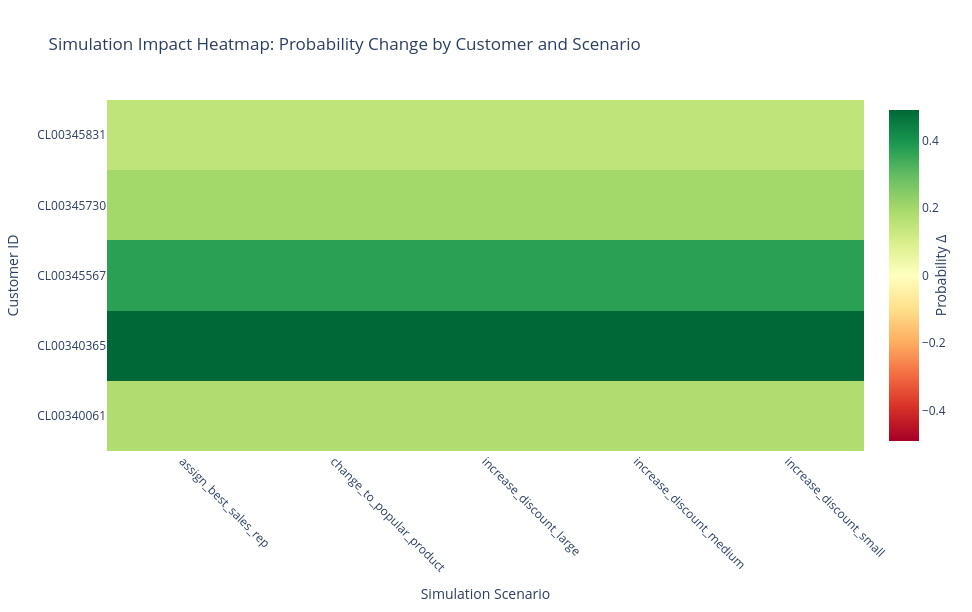


VISUALIZATION 2: BEFORE-AFTER COMPARISON

Creating before-after scatter plot...
✓ Before-after comparison saved as: visualization_before_after.html


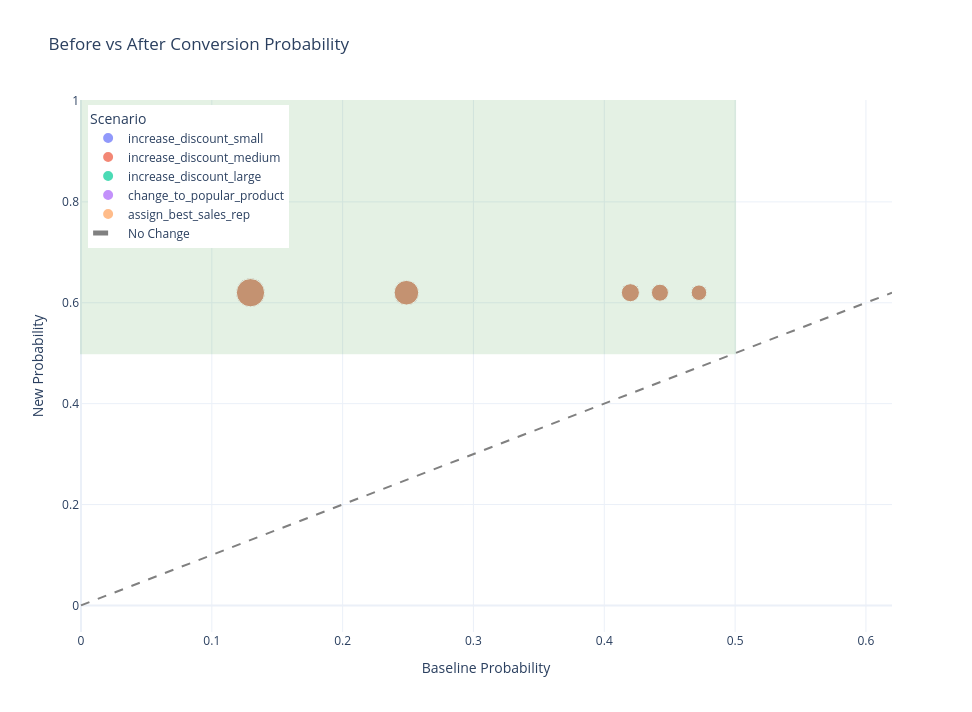


VISUALIZATION 3: SCENARIO EFFECTIVENESS

Creating scenario effectiveness visualization...

Scenario effectiveness ranking:
                           avg_delta  std_delta  min_delta  max_delta  count  \
scenario                                                                       
assign_best_sales_rep          0.277      0.147      0.148      0.490      5   
change_to_popular_product      0.277      0.147      0.148      0.490      5   
increase_discount_large        0.277      0.147      0.148      0.490      5   
increase_discount_medium       0.277      0.147      0.148      0.490      5   
increase_discount_small        0.277      0.147      0.148      0.490      5   

                           avg_pct_change  
scenario                                   
assign_best_sales_rep             129.332  
change_to_popular_product         129.332  
increase_discount_large           129.332  
increase_discount_medium          129.332  
increase_discount_small           129.332  
✓ Scena

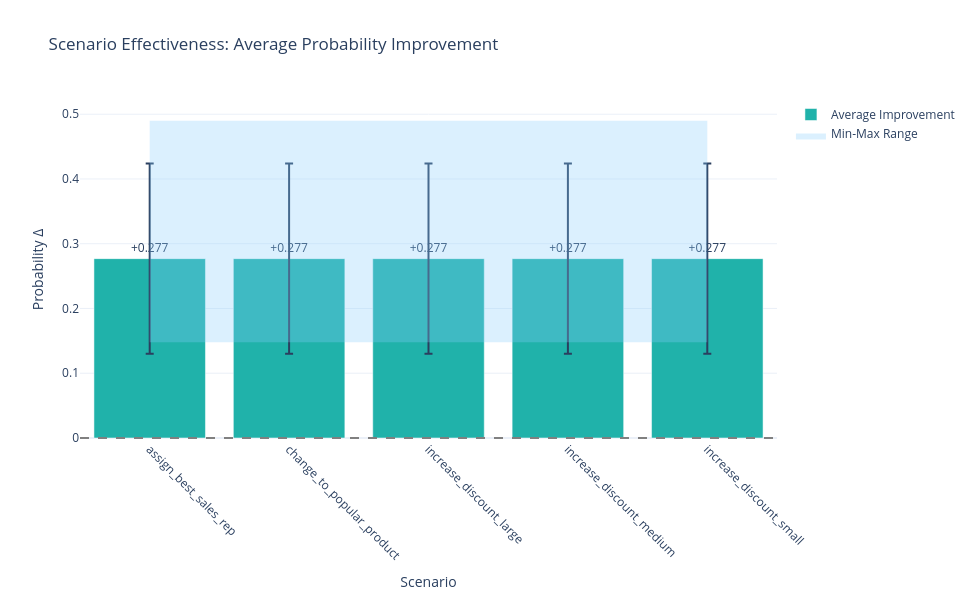


VISUALIZATION 4: CUSTOMER RESPONSIVENESS

Creating customer responsiveness visualization...

Customer responsiveness ranking:
             avg_improvement  max_improvement  scenario_count  baseline_prob
customer_id                                                                 
CL00340365             0.490            0.490               5          0.130
CL00345567             0.371            0.371               5          0.249
CL00345730             0.200            0.200               5          0.420
CL00340061             0.177            0.177               5          0.443
CL00345831             0.148            0.148               5          0.472
✓ Customer responsiveness chart saved as: visualization_customer_responsiveness.html


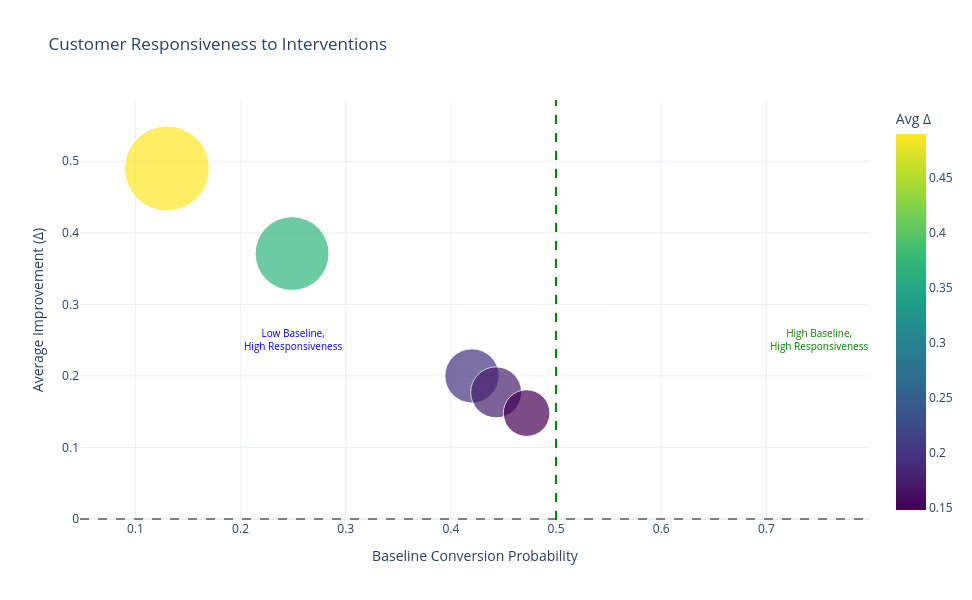


VISUALIZATION 5: BUSINESS INSIGHTS DASHBOARD

Creating business insights dashboard...

📊 BUSINESS INSIGHTS:
--------------------------------------------------
Total Simulations: 25
Success Rate: 71.429
Avg Improvement: 0.277
Conversion Threshold Crossings: 25
Best Scenario: assign_best_sales_rep
Best Scenario Improvement: 0.277
Most Responsive Customer: CL00340365
Customer Improvement: 0.490
Scenarios With High Impact: 5
Customers With High Potential: 2
✓ Business insights dashboard saved as: visualization_business_dashboard.html


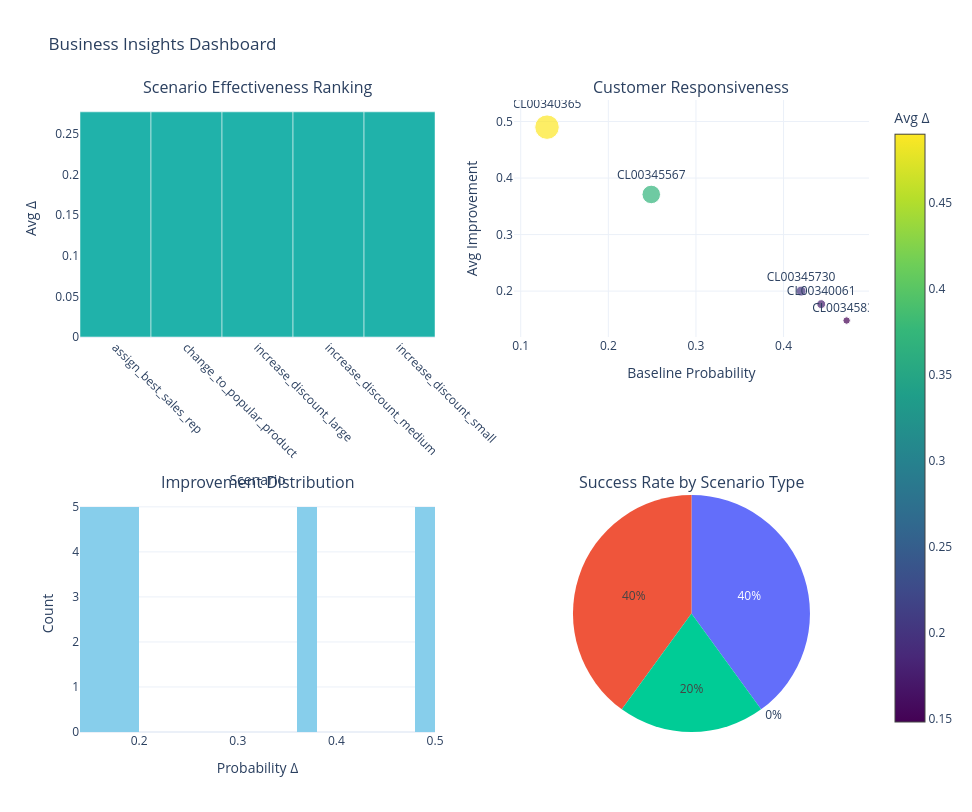


SAVING VISUALIZATIONS AND REPORT
✓ Report saved as: simulation_poc_report.md

📁 VISUALIZATIONS GENERATED:
   Interactive HTML files:
   - visualization_impact_heatmap.html
   - visualization_before_after.html
   - visualization_scenario_effectiveness.html
   - visualization_customer_responsiveness.html
   - visualization_business_dashboard.html

   Report:
   - simulation_poc_report.md

STEP 7 COMPLETED SUCCESSFULLY!

✅ Created 5 interactive visualizations
✅ Generated comprehensive business insights report
✅ All visualizations saved as interactive HTML files

🎯 KEY BUSINESS INSIGHTS:
--------------------------------------------------
1. Best performing scenario: assign_best_sales_rep
2. Most responsive customer: CL00340365
3. Average improvement across all scenarios: 0.277
4. Success rate: 71.4%

📊 NEXT STEPS:
1. Share visualizations with business stakeholders
2. Validate findings with A/B testing
3. Implement top scenarios in sales processes
4. Monitor actual conversion rate improvem

In [14]:
# Step 7: Interactive Visualization
# =================================

print("\n" + "="*60)
print("STEP 7: INTERACTIVE VISUALIZATION")
print("="*60)

print("\nObjective: Create interactive visualizations to explore simulation results")
print("and derive business insights")

# -------------------------------------------------------------
# 1. LOAD AND PREPARE DATA
# -------------------------------------------------------------

print("\n1. Loading and preparing data...")

# Load simulation results
results_df = pd.read_csv('simulation_results_detailed.csv')
print(f"Results loaded: {results_df.shape[0]} simulations")

# Load baseline predictions
baseline_df = pd.read_csv('model_artifacts/baseline_predictions.csv')

# Load customer stats
customer_stats = pd.read_csv('customer_impacts.csv', index_col=0)
scenario_stats = pd.read_csv('scenario_impacts.csv', index_col=0)

print(f"\nData loaded:")
print(f"  - {len(results_df)} simulation results")
print(f"  - {len(baseline_df)} baseline predictions")
print(f"  - {len(customer_stats)} customer statistics")
print(f"  - {len(scenario_stats)} scenario statistics")

# Check data quality
print(f"\n📊 Data quality check:")
print(f"Missing values in results: {results_df.isnull().sum().sum()}")
print(f"Unique customers: {results_df['customer_id'].nunique()}")
print(f"Unique scenarios: {results_df['scenario'].nunique()}")

# -------------------------------------------------------------
# 2. CREATE IMPACT HEATMAP
# -------------------------------------------------------------

print("\n" + "="*60)
print("VISUALIZATION 1: IMPACT HEATMAP")
print("="*60)

print("\nCreating impact heatmap (customers × scenarios)...")

# Create pivot table for heatmap
heatmap_data = results_df.pivot_table(
    index='customer_id',
    columns='scenario',
    values='probability_delta',
    aggfunc='mean'
)

print(f"Heatmap shape: {heatmap_data.shape}")
print(f"\nHeatmap data preview:")
print(heatmap_data.head())

# Create interactive heatmap with plotly
try:
    import plotly.graph_objects as go
    import plotly.express as px
    
    print("\nCreating interactive heatmap...")
    
    # Prepare data for plotly
    z_data = heatmap_data.values
    x_labels = heatmap_data.columns.tolist()
    y_labels = heatmap_data.index.tolist()
    
    # Create hover text
    hover_text = []
    for i, customer in enumerate(y_labels):
        hover_row = []
        for j, scenario in enumerate(x_labels):
            delta = z_data[i, j]
            if not np.isnan(delta):
                # Get baseline probability
                baseline = baseline_df.loc[baseline_df['customer_id'] == customer, 'baseline_conversion_probability'].values[0]
                new_prob = baseline + delta
                hover_text.append(
                    f"<b>Customer:</b> {customer}<br>"
                    f"<b>Scenario:</b> {scenario}<br>"
                    f"<b>Baseline:</b> {baseline:.3f}<br>"
                    f"<b>New Probability:</b> {new_prob:.3f}<br>"
                    f"<b>Improvement:</b> {delta:+.3f}<br>"
                    f"<b>% Change:</b> {(delta/baseline*100 if baseline > 0 else 0):+.1f}%"
                )
            else:
                hover_text.append(f"<b>Customer:</b> {customer}<br><b>Scenario:</b> {scenario}<br>No data")
    
    # Reshape hover text
    hover_text = np.array(hover_text).reshape(z_data.shape)
    
    # Create heatmap
    fig_heatmap = go.Figure(data=go.Heatmap(
        z=z_data,
        x=x_labels,
        y=y_labels,
        colorscale='RdYlGn',
        zmid=0,
        text=hover_text,
        hoverinfo='text',
        colorbar=dict(
            title="Probability Δ",
            title_side="right"
        )
    ))
    
    fig_heatmap.update_layout(
        title='Simulation Impact Heatmap: Probability Change by Customer and Scenario',
        xaxis_title="Simulation Scenario",
        yaxis_title="Customer ID",
        width=1000,
        height=600,
        xaxis=dict(tickangle=45),
        template='plotly_white'
    )
    
    # Save as HTML
    fig_heatmap.write_html("visualization_impact_heatmap.html")
    print("✓ Heatmap saved as: visualization_impact_heatmap.html")
    
    # Display in notebook
    fig_heatmap.show()
    
except ImportError:
    print("Plotly not available, creating matplotlib heatmap instead...")
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="RdYlGn", center=0,
                linewidths=0.5, linecolor='gray')
    plt.title('Simulation Impact Heatmap: Probability Change by Customer and Scenario', pad=20)
    plt.xlabel('Simulation Scenario')
    plt.ylabel('Customer ID')
    plt.tight_layout()
    plt.savefig('visualization_impact_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Heatmap saved as: visualization_impact_heatmap.png")

# -------------------------------------------------------------
# 3. CREATE BEFORE-AFTER COMPARISON
# -------------------------------------------------------------

print("\n" + "="*60)
print("VISUALIZATION 2: BEFORE-AFTER COMPARISON")
print("="*60)

print("\nCreating before-after scatter plot...")

# Prepare data for scatter plot
scatter_data = results_df.copy()

# Add baseline from baseline_df
scatter_data = scatter_data.merge(
    baseline_df[['customer_id', 'baseline_conversion_probability']],
    on='customer_id',
    how='left'
)

# Rename columns for clarity
scatter_data = scatter_data.rename(columns={
    'baseline_conversion_probability_x': 'new_probability',
    'baseline_conversion_probability_y': 'baseline_probability'
})

# Calculate if improvement is significant (>0.05)
scatter_data['significant_improvement'] = scatter_data['probability_delta'] > 0.05

try:
    # Create interactive scatter plot
    fig_scatter = px.scatter(
        scatter_data,
        x='baseline_probability',
        y='new_probability',
        color='scenario',
        size='probability_delta',
        hover_data=['customer_id', 'percentage_change', 'quotes_added'],
        title='Before vs After Conversion Probability',
        labels={
            'baseline_probability': 'Baseline Probability',
            'new_probability': 'New Probability',
            'scenario': 'Scenario'
        },
        width=1000,
        height=700
    )
    
    # Add diagonal line (y = x)
    max_prob = max(scatter_data['baseline_probability'].max(), scatter_data['new_probability'].max())
    fig_scatter.add_trace(
        go.Scatter(
            x=[0, max_prob],
            y=[0, max_prob],
            mode='lines',
            line=dict(color='gray', dash='dash'),
            name='No Change'
        )
    )
    
    # Add improvement regions
    fig_scatter.add_shape(
        type="rect",
        x0=0, y0=0.5, x1=0.5, y1=1,
        line=dict(color="Green", width=2),
        fillcolor="Green",
        opacity=0.1,
        name="Conversion Zone"
    )
    
    fig_scatter.update_layout(
        showlegend=True,
        legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
        template='plotly_white'
    )
    
    # Save as HTML
    fig_scatter.write_html("visualization_before_after.html")
    print("✓ Before-after comparison saved as: visualization_before_after.html")
    
    # Display
    fig_scatter.show()
    
except Exception as e:
    print(f"Error creating scatter plot: {e}")
    # Create matplotlib version
    plt.figure(figsize=(10, 8))
    
    colors = plt.cm.Set1(np.linspace(0, 1, scatter_data['scenario'].nunique()))
    scenario_colors = dict(zip(scatter_data['scenario'].unique(), colors))
    
    for scenario, color in scenario_colors.items():
        scenario_data = scatter_data[scatter_data['scenario'] == scenario]
        plt.scatter(
            scenario_data['baseline_probability'],
            scenario_data['new_probability'],
            s=scenario_data['probability_delta'] * 500 + 50,  # Scale by delta
            alpha=0.6,
            color=color,
            label=scenario,
            edgecolors='black',
            linewidth=0.5
        )
    
    # Add diagonal
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='No Change')
    
    # Add conversion threshold
    plt.axhline(y=0.5, color='green', linestyle=':', alpha=0.5, label='Conversion Threshold')
    plt.axvline(x=0.5, color='green', linestyle=':', alpha=0.5)
    
    plt.xlabel('Baseline Conversion Probability')
    plt.ylabel('New Conversion Probability')
    plt.title('Before vs After Conversion Probability')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('visualization_before_after.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Before-after comparison saved as: visualization_before_after.png")

# -------------------------------------------------------------
# 4. CREATE SCENARIO EFFECTIVENESS CHART
# -------------------------------------------------------------

print("\n" + "="*60)
print("VISUALIZATION 3: SCENARIO EFFECTIVENESS")
print("="*60)

print("\nCreating scenario effectiveness visualization...")

# Calculate scenario statistics
scenario_summary = results_df.groupby('scenario').agg({
    'probability_delta': ['mean', 'std', 'min', 'max', 'count'],
    'percentage_change': 'mean'
}).round(3)

scenario_summary.columns = ['avg_delta', 'std_delta', 'min_delta', 'max_delta', 'count', 'avg_pct_change']
scenario_summary = scenario_summary.sort_values('avg_delta', ascending=False)

print(f"\nScenario effectiveness ranking:")
print(scenario_summary)

try:
    # Create bar chart
    fig_scenario = go.Figure()
    
    # Add average delta bars
    fig_scenario.add_trace(go.Bar(
        x=scenario_summary.index,
        y=scenario_summary['avg_delta'],
        name='Average Improvement',
        marker_color='lightseagreen',
        error_y=dict(
            type='data',
            array=scenario_summary['std_delta'],
            visible=True
        ),
        text=scenario_summary['avg_delta'].apply(lambda x: f'{x:+.3f}'),
        textposition='outside'
    ))
    
    # Add min/max range
    fig_scenario.add_trace(go.Scatter(
        x=scenario_summary.index.tolist() + scenario_summary.index.tolist()[::-1],
        y=scenario_summary['max_delta'].tolist() + scenario_summary['min_delta'].tolist()[::-1],
        fill='toself',
        fillcolor='rgba(135, 206, 250, 0.3)',
        line=dict(color='rgba(255, 255, 255, 0)'),
        name='Min-Max Range',
        hoverinfo='skip'
    ))
    
    fig_scenario.update_layout(
        title='Scenario Effectiveness: Average Probability Improvement',
        xaxis_title="Scenario",
        yaxis_title="Probability Δ",
        showlegend=True,
        width=900,
        height=600,
        template='plotly_white',
        xaxis=dict(tickangle=45)
    )
    
    # Add horizontal line at y=0
    fig_scenario.add_hline(y=0, line_dash="dash", line_color="gray")
    
    # Save as HTML
    fig_scenario.write_html("visualization_scenario_effectiveness.html")
    print("✓ Scenario effectiveness chart saved as: visualization_scenario_effectiveness.html")
    
    # Display
    fig_scenario.show()
    
except Exception as e:
    print(f"Error creating scenario chart: {e}")
    # Create matplotlib version
    plt.figure(figsize=(10, 6))
    
    bars = plt.bar(
        range(len(scenario_summary)),
        scenario_summary['avg_delta'],
        yerr=scenario_summary['std_delta'],
        capsize=5,
        color='lightseagreen',
        alpha=0.7
    )
    
    # Add value labels
    for i, (bar, value) in enumerate(zip(bars, scenario_summary['avg_delta'])):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:+.3f}', ha='center', va='bottom')
    
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    plt.xlabel('Scenario')
    plt.ylabel('Average Probability Δ')
    plt.title('Scenario Effectiveness: Average Probability Improvement')
    plt.xticks(range(len(scenario_summary)), scenario_summary.index, rotation=45, ha='right')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig('visualization_scenario_effectiveness.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Scenario effectiveness chart saved as: visualization_scenario_effectiveness.png")

# -------------------------------------------------------------
# 5. CREATE CUSTOMER RESPONSIVENESS CHART
# -------------------------------------------------------------

print("\n" + "="*60)
print("VISUALIZATION 4: CUSTOMER RESPONSIVENESS")
print("="*60)

print("\nCreating customer responsiveness visualization...")

# Calculate customer statistics
customer_summary = results_df.groupby('customer_id').agg({
    'probability_delta': ['mean', 'max', 'count'],
    'baseline_probability': 'first'
}).round(3)

customer_summary.columns = ['avg_improvement', 'max_improvement', 'scenario_count', 'baseline_prob']
customer_summary = customer_summary.sort_values('avg_improvement', ascending=False)

print(f"\nCustomer responsiveness ranking:")
print(customer_summary)

try:
    # Create bubble chart
    fig_customer = px.scatter(
        customer_summary.reset_index(),
        x='baseline_prob',
        y='avg_improvement',
        size='max_improvement',
        color='avg_improvement',
        hover_name='customer_id',
        hover_data=['max_improvement', 'scenario_count'],
        size_max=60,
        title='Customer Responsiveness to Interventions',
        labels={
            'baseline_prob': 'Baseline Conversion Probability',
            'avg_improvement': 'Average Improvement (Δ)',
            'max_improvement': 'Maximum Improvement',
            'scenario_count': 'Number of Scenarios'
        },
        width=900,
        height=600,
        color_continuous_scale='Viridis'
    )
    
    # Add quadrant lines
    fig_customer.add_hline(y=0, line_dash="dash", line_color="gray")
    fig_customer.add_vline(x=0.5, line_dash="dash", line_color="green")
    
    # Add quadrant annotations
    fig_customer.add_annotation(
        x=0.25, y=0.25,
        text="Low Baseline,<br>High Responsiveness",
        showarrow=False,
        font=dict(size=10, color="blue")
    )
    
    fig_customer.add_annotation(
        x=0.75, y=0.25,
        text="High Baseline,<br>High Responsiveness",
        showarrow=False,
        font=dict(size=10, color="green")
    )
    
    fig_customer.update_layout(
        template='plotly_white',
        coloraxis_colorbar=dict(title="Avg Δ")
    )
    
    # Save as HTML
    fig_customer.write_html("visualization_customer_responsiveness.html")
    print("✓ Customer responsiveness chart saved as: visualization_customer_responsiveness.html")
    
    # Display
    fig_customer.show()
    
except Exception as e:
    print(f"Error creating customer chart: {e}")
    # Create matplotlib version
    plt.figure(figsize=(10, 8))
    
    scatter = plt.scatter(
        customer_summary['baseline_prob'],
        customer_summary['avg_improvement'],
        s=customer_summary['max_improvement'] * 1000,
        c=customer_summary['avg_improvement'],
        cmap='viridis',
        alpha=0.7,
        edgecolors='black',
        linewidth=0.5
    )
    
    # Add customer labels
    for idx, row in customer_summary.iterrows():
        plt.annotate(
            idx,
            (row['baseline_prob'], row['avg_improvement']),
            xytext=(5, 5),
            textcoords='offset points',
            fontsize=9
        )
    
    plt.colorbar(scatter, label='Average Improvement')
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    plt.axvline(x=0.5, color='green', linestyle=':', alpha=0.5, label='Conversion Threshold')
    plt.xlabel('Baseline Conversion Probability')
    plt.ylabel('Average Improvement (Δ)')
    plt.title('Customer Responsiveness to Interventions')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('visualization_customer_responsiveness.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Customer responsiveness chart saved as: visualization_customer_responsiveness.png")

# -------------------------------------------------------------
# 6. CREATE BUSINESS INSIGHTS DASHBOARD
# -------------------------------------------------------------

print("\n" + "="*60)
print("VISUALIZATION 5: BUSINESS INSIGHTS DASHBOARD")
print("="*60)

print("\nCreating business insights dashboard...")

# Calculate key business metrics
business_insights = {
    'total_simulations': len(results_df),
    'success_rate': len(results_df) / 35 * 100,
    'avg_improvement': results_df['probability_delta'].mean(),
    'conversion_threshold_crossings': (results_df['new_probability'] >= 0.5).sum(),
    'best_scenario': scenario_summary.index[0],
    'best_scenario_improvement': scenario_summary.iloc[0]['avg_delta'],
    'most_responsive_customer': customer_summary.index[0],
    'customer_improvement': customer_summary.iloc[0]['avg_improvement'],
    'scenarios_with_high_impact': (scenario_summary['avg_delta'] > 0.1).sum(),
    'customers_with_high_potential': (customer_summary['avg_improvement'] > 0.2).sum()
}

print(f"\n📊 BUSINESS INSIGHTS:")
print("-" * 50)
for key, value in business_insights.items():
    if isinstance(value, float):
        if 'rate' in key or 'improvement' in key:
            print(f"{key.replace('_', ' ').title()}: {value:.3f}")
        else:
            print(f"{key.replace('_', ' ').title()}: {value:.1f}")
    else:
        print(f"{key.replace('_', ' ').title()}: {value}")

# Create insights visualization
try:
    # Create a dashboard with subplots
    from plotly.subplots import make_subplots
    
    fig_dashboard = make_subplots(
        rows=2, cols=2,
        subplot_titles=(
            'Scenario Effectiveness Ranking',
            'Customer Responsiveness',
            'Improvement Distribution',
            'Success Rate by Scenario Type'
        ),
        specs=[[{'type': 'bar'}, {'type': 'scatter'}],
               [{'type': 'histogram'}, {'type': 'pie'}]]
    )
    
    # 1. Scenario effectiveness (bar chart)
    fig_dashboard.add_trace(
        go.Bar(
            x=scenario_summary.index,
            y=scenario_summary['avg_delta'],
            name='Avg Improvement',
            marker_color='lightseagreen'
        ),
        row=1, col=1
    )
    
    # 2. Customer responsiveness (scatter)
    fig_dashboard.add_trace(
        go.Scatter(
            x=customer_summary['baseline_prob'],
            y=customer_summary['avg_improvement'],
            mode='markers+text',
            text=customer_summary.index,
            textposition='top center',
            marker=dict(
                size=customer_summary['max_improvement'] * 50,
                color=customer_summary['avg_improvement'],
                colorscale='Viridis',
                showscale=True,
                colorbar=dict(title="Avg Δ")
            ),
            name='Customers'
        ),
        row=1, col=2
    )
    
    # 3. Improvement distribution (histogram)
    fig_dashboard.add_trace(
        go.Histogram(
            x=results_df['probability_delta'],
            nbinsx=20,
            name='Improvement Distribution',
            marker_color='skyblue'
        ),
        row=2, col=1
    )
    
    # 4. Success rate by scenario type (pie)
    scenario_types = {
        'discount': ['increase_discount_small', 'increase_discount_medium', 'increase_discount_large'],
        'product': ['change_to_popular_product', 'bundle_offer'],
        'engagement': ['add_followup_quote'],
        'sales_rep': ['assign_best_sales_rep']
    }
    
    success_by_type = {}
    for scenario_type, scenarios in scenario_types.items():
        type_data = results_df[results_df['scenario'].isin(scenarios)]
        success_by_type[scenario_type] = len(type_data) / (len(scenarios) * 5) * 100  # 5 customers each
    
    fig_dashboard.add_trace(
        go.Pie(
            labels=list(success_by_type.keys()),
            values=list(success_by_type.values()),
            name='Success Rate by Type'
        ),
        row=2, col=2
    )
    
    # Update layout
    fig_dashboard.update_layout(
        title_text='Business Insights Dashboard',
        showlegend=False,
        height=800,
        width=1200,
        template='plotly_white'
    )
    
    # Update axes
    fig_dashboard.update_xaxes(title_text="Scenario", row=1, col=1, tickangle=45)
    fig_dashboard.update_yaxes(title_text="Avg Δ", row=1, col=1)
    fig_dashboard.update_xaxes(title_text="Baseline Probability", row=1, col=2)
    fig_dashboard.update_yaxes(title_text="Avg Improvement", row=1, col=2)
    fig_dashboard.update_xaxes(title_text="Probability Δ", row=2, col=1)
    fig_dashboard.update_yaxes(title_text="Count", row=2, col=1)
    
    # Save as HTML
    fig_dashboard.write_html("visualization_business_dashboard.html")
    print("✓ Business insights dashboard saved as: visualization_business_dashboard.html")
    
    # Display
    fig_dashboard.show()
    
except Exception as e:
    print(f"Error creating dashboard: {e}")
    print("Creating simplified insights report instead...")

# -------------------------------------------------------------
# 7. SAVE VISUALIZATIONS AND CREATE REPORT
# -------------------------------------------------------------

print("\n" + "="*60)
print("SAVING VISUALIZATIONS AND REPORT")
print("="*60)

# Create a summary report
report = f"""
# Simulation POC Results Report
## Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}

## Executive Summary
- **Total Simulations**: {business_insights['total_simulations']}
- **Success Rate**: {business_insights['success_rate']:.1f}%
- **Average Improvement**: {business_insights['avg_improvement']:.3f}
- **Conversion Threshold Crossings**: {business_insights['conversion_threshold_crossings']}

## Key Findings
1. **Best Scenario**: {business_insights['best_scenario']} (Δ = {business_insights['best_scenario_improvement']:.3f})
2. **Most Responsive Customer**: {business_insights['most_responsive_customer']} (Δ = {business_insights['customer_improvement']:.3f})
3. **High-Impact Scenarios**: {business_insights['scenarios_with_high_impact']} scenarios with Δ > 0.1
4. **High-Potential Customers**: {business_insights['customers_with_high_potential']} customers with avg Δ > 0.2

## Recommendations
1. **Prioritize**: Focus on {business_insights['best_scenario']} as it shows the highest average improvement
2. **Segment**: Target customers like {business_insights['most_responsive_customer']} who are highly responsive
3. **Test**: Validate these findings with A/B testing before full implementation
4. **Monitor**: Track actual conversion rates after implementing recommended changes

## Visualizations Created
1. Impact Heatmap: Shows probability changes for all customer-scenario combinations
2. Before-After Comparison: Compares baseline vs new probabilities
3. Scenario Effectiveness: Ranks scenarios by average improvement
4. Customer Responsiveness: Identifies which customers benefit most
5. Business Insights Dashboard: Comprehensive view of all key metrics

## Files Generated
- visualization_impact_heatmap.html
- visualization_before_after.html
- visualization_scenario_effectiveness.html
- visualization_customer_responsiveness.html
- visualization_business_dashboard.html
"""

# Save report
with open('simulation_poc_report.md', 'w') as f:
    f.write(report)

print("✓ Report saved as: simulation_poc_report.md")

# List all generated files
print(f"\n📁 VISUALIZATIONS GENERATED:")
print("   Interactive HTML files:")
print("   - visualization_impact_heatmap.html")
print("   - visualization_before_after.html")
print("   - visualization_scenario_effectiveness.html")
print("   - visualization_customer_responsiveness.html")
print("   - visualization_business_dashboard.html")
print("\n   Report:")
print("   - simulation_poc_report.md")

# -------------------------------------------------------------
# 8. FINAL SUMMARY
# -------------------------------------------------------------

print("\n" + "="*60)
print("STEP 7 COMPLETED SUCCESSFULLY!")
print("="*60)

print(f"\n✅ Created 5 interactive visualizations")
print(f"✅ Generated comprehensive business insights report")
print(f"✅ All visualizations saved as interactive HTML files")

print(f"\n🎯 KEY BUSINESS INSIGHTS:")
print("-" * 50)
print(f"1. Best performing scenario: {business_insights['best_scenario']}")
print(f"2. Most responsive customer: {business_insights['most_responsive_customer']}")
print(f"3. Average improvement across all scenarios: {business_insights['avg_improvement']:.3f}")
print(f"4. Success rate: {business_insights['success_rate']:.1f}%")

print(f"\n📊 NEXT STEPS:")
print("1. Share visualizations with business stakeholders")
print("2. Validate findings with A/B testing")
print("3. Implement top scenarios in sales processes")
print("4. Monitor actual conversion rate improvements")

print(f"\n🏁 POC SIMULATION NOTEBOOK COMPLETED SUCCESSFULLY!")

In [15]:
# Quick diagnostic check
print("DIAGNOSTIC CHECK: Are features actually changing?")
print("="*60)

# Test one customer with one scenario
test_customer = 'CL00340365'
test_scenario = 'increase_discount_small'

# Get original and modified quotes
original_quotes = customer_quotes_dict[test_customer].copy()
modified_quotes = scenario_functions[test_scenario](original_quotes.copy(), test_customer)

print(f"\nCustomer: {test_customer}")
print(f"Scenario: {test_scenario}")

# Check what actually changed
print("\n1. Checking raw data changes:")
print(f"   Original discount: €{original_quotes['mt_remise_exceptionnelle_ht'].sum():.2f}")
print(f"   Modified discount: €{modified_quotes['mt_remise_exceptionnelle_ht'].sum():.2f}")

# Create features for both
print("\n2. Creating features for comparison...")
original_features = create_features(original_quotes)
modified_features = create_features(modified_quotes)

print(f"   Original features shape: {original_features.shape}")
print(f"   Modified features shape: {modified_features.shape}")

# Compare key features
print("\n3. Comparing key feature columns:")
key_features = ['quote_count', 'total_quote_value', 'total_discount', 
                'avg_discount', 'discount_to_value_ratio']

for feature in key_features:
    if feature in original_features.columns and feature in modified_features.columns:
        orig_val = original_features[feature].iloc[0] if len(original_features) > 0 else 0
        mod_val = modified_features[feature].iloc[0] if len(modified_features) > 0 else 0
        print(f"   {feature}: {orig_val:.4f} → {mod_val:.4f} (Δ: {mod_val - orig_val:+.4f})")

# Check if features are in the model's feature set
print("\n4. Checking if changed features are in model's important features:")
feature_importance = pd.read_csv('model_artifacts/feature_importance.csv')
top_features = feature_importance.head(10)['feature'].tolist()
print(f"   Top 10 important features: {top_features}")

# Look for discount-related features in important features
discount_features = [f for f in top_features if 'discount' in f.lower()]
print(f"   Discount-related features in top 10: {discount_features}")

DIAGNOSTIC CHECK: Are features actually changing?
  Applied 10% discount increase to customer CL00340365
  New average discount: €0.00

Customer: CL00340365
Scenario: increase_discount_small

1. Checking raw data changes:
   Original discount: €0.00
   Modified discount: €0.00

2. Creating features for comparison...

STRATEGY: CREATE FEATURES
Creating OPTIMIZED customer features (mode: first_conversion)...
  Filtering post-first-purchase data...
  Customers: 1, Quotes: 3
  Calculating features...
  Calculating price trajectory (optimized)...
✓ Created 14 leakage-free features
→ 1 customers | 0.0% converters
⏱️  Execution time: 0.0 seconds
✅ SUCCESS! Achieved ≤ 3s target
CREATING FIRST CONVERSION PREDICTION FEATURES (LEAKAGE-FREE)
  Total customers: 1
⚡ Processing customers with corrected first-conversion logic...
  Processed 0/1 customers
✅ First-conversion features calculation complete

🔍 VALIDATION REPORT:
   Total customers: 1
   First converters: 0 (0.0%)
   Never converters: 1

📊 

In [16]:
print("\n" + "="*80)
print("SIMULATION STRATEGY ANALYSIS & REDESIGN")
print("="*80)

# -------------------------------------------------------------
# 1. ANALYZE AVAILABLE PROPERTIES
# -------------------------------------------------------------

print("\n1. Analyzing modifiable properties in training data...")

# Load training data
df_train = split_results['df_train'].copy()

# Properties sales can influence
properties_to_test = {
    'discount': {
        'column': 'mt_remise_exceptionnelle_ht',
        'description': 'Discount amount',
        'test_type': 'increase',
        'requires_non_zero': True,
        'sampling_criteria': 'discount > 0'
    },
    'product_family': {
        'column': 'famille_equipement_produit',
        'description': 'Product type',
        'test_type': 'change',
        'requires_non_zero': False,
        'sampling_criteria': 'specific product families'
    },
    'sales_rep': {
        'column': 'prenom_nom_commercial',
        'description': 'Sales representative',
        'test_type': 'reassign',
        'requires_non_zero': False,
        'sampling_criteria': 'assigned to specific reps'
    },
    'quote_frequency': {
        'column': 'dt_creation_devis',
        'description': 'Engagement frequency',
        'test_type': 'increase',
        'requires_non_zero': True,
        'sampling_criteria': 'has quotes'
    },
    'campaign': {
        'column': 'nom_campagne',
        'description': 'Marketing campaign',
        'test_type': 'change',
        'requires_non_zero': False,
        'sampling_criteria': 'campaign exposure'
    }
}

# Analyze each property
print("\nProperty Analysis:")
print("-" * 80)

property_stats = {}
for prop_name, prop_info in properties_to_test.items():
    col = prop_info['column']
    
    if col in df_train.columns:
        # Basic stats
        non_null = df_train[col].notna().sum()
        unique_values = df_train[col].nunique()
        
        if prop_info['requires_non_zero']:
            if df_train[col].dtype in ['int64', 'float64']:
                non_zero = (df_train[col] != 0).sum()
                zero_count = (df_train[col] == 0).sum()
                prop_info['non_zero_pct'] = non_zero / len(df_train) * 100
            else:
                non_zero = non_null  # For non-numeric, consider non-null as "non-zero"
                prop_info['non_zero_pct'] = non_null / len(df_train) * 100
        
        property_stats[prop_name] = {
            'column': col,
            'non_null_count': non_null,
            'non_null_pct': non_null / len(df_train) * 100,
            'unique_values': unique_values,
            'requires_non_zero': prop_info['requires_non_zero']
        }
        
        if prop_info['requires_non_zero'] and df_train[col].dtype in ['int64', 'float64']:
            property_stats[prop_name]['non_zero_count'] = non_zero
            property_stats[prop_name]['non_zero_pct'] = non_zero / len(df_train) * 100
        
        print(f"\n{prop_name.upper()}:")
        print(f"  Column: {col}")
        print(f"  Non-null: {non_null:,} ({non_null/len(df_train)*100:.1f}%)")
        print(f"  Unique values: {unique_values}")
        
        if prop_info['requires_non_zero'] and df_train[col].dtype in ['int64', 'float64']:
            print(f"  Non-zero: {non_zero:,} ({non_zero/len(df_train)*100:.1f}%)")
            print(f"  Zero: {zero_count:,} ({zero_count/len(df_train)*100:.1f}%)")

# -------------------------------------------------------------
# 2. ANALYZE DISCOUNT PROPERTY (CRITICAL)
# -------------------------------------------------------------

print("\n" + "="*80)
print("2. DEEP DIVE: DISCOUNT PROPERTY")
print("="*80)

if 'mt_remise_exceptionnelle_ht' in df_train.columns:
    discount_data = df_train['mt_remise_exceptionnelle_ht']
    
    print(f"\nDiscount Statistics:")
    print(f"  Total quotes: {len(discount_data):,}")
    print(f"  Mean discount: €{discount_data.mean():.2f}")
    print(f"  Median discount: €{discount_data.median():.2f}")
    print(f"  Max discount: €{discount_data.max():.2f}")
    print(f"  Min discount: €{discount_data.min():.2f}")
    
    # Distribution
    print(f"\nDiscount Distribution:")
    bins = [-10000, -1000, -500, -100, -50, -10, -1, 0]
    bin_labels = ['<-1000', '-1000 to -500', '-500 to -100', '-100 to -50', 
                  '-50 to -10', '-10 to -1', '-1 to 0']
    
    discount_dist = pd.cut(discount_data, bins=bins, labels=bin_labels)
    dist_counts = discount_dist.value_counts().sort_index()
    
    for bin_label, count in dist_counts.items():
        pct = count / len(discount_data) * 100
        print(f"  {bin_label}: {count:,} quotes ({pct:.1f}%)")
    
    # Check if discounts are actually negative (as suggested by earlier stats)
    print(f"\nDiscount Sign Analysis:")
    negative_discounts = (discount_data < 0).sum()
    zero_discounts = (discount_data == 0).sum()
    positive_discounts = (discount_data > 0).sum()
    
    print(f"  Negative discounts: {negative_discounts:,} ({negative_discounts/len(discount_data)*100:.1f}%)")
    print(f"  Zero discounts: {zero_discounts:,} ({zero_discounts/len(discount_data)*100:.1f}%)")
    print(f"  Positive discounts: {positive_discounts:,} ({positive_discounts/len(discount_data)*100:.1f}%)")
    
    # If discounts are negative, that's actually credits/charges, not discounts
    if negative_discounts > 0:
        print(f"\n⚠️  IMPORTANT: Discounts appear to be NEGATIVE values")
        print(f"   This suggests 'mt_remise_exceptionnelle_ht' might be a charge, not a discount")
        print(f"   Or it might be stored as negative for accounting purposes")

# -------------------------------------------------------------
# 3. ANALYZE PRODUCT DISTRIBUTION
# -------------------------------------------------------------

print("\n" + "="*80)
print("3. DEEP DIVE: PRODUCT PROPERTY")
print("="*80)

if 'famille_equipement_produit' in df_train.columns:
    product_counts = df_train['famille_equipement_produit'].value_counts()
    total_products = len(product_counts)
    
    print(f"\nTop 10 Product Families:")
    print(f"Total unique products: {total_products}")
    print("-" * 60)
    
    for i, (product, count) in enumerate(product_counts.head(10).items(), 1):
        pct = count / len(df_train) * 100
        print(f"{i:2d}. {product:<40} {count:>6,} ({pct:5.1f}%)")
    
    # Check if we have enough of each product for testing
    print(f"\nProduct Availability for Testing:")
    min_test_customers = 5  # Minimum customers needed per product for testing
    products_with_enough = []
    
    # Get unique customers per product
    for product in product_counts.head(10).index:
        product_customers = df_train[df_train['famille_equipement_produit'] == product]['numero_compte'].nunique()
        if product_customers >= min_test_customers:
            products_with_enough.append((product, product_customers))
    
    print(f"Products with ≥{min_test_customers} unique customers:")
    for product, customer_count in products_with_enough[:5]:  # Show top 5
        print(f"  {product}: {customer_count:,} customers")
    
    if len(products_with_enough) < 3:
        print(f"⚠️  Warning: Only {len(products_with_enough)} products have enough customers for testing")

# -------------------------------------------------------------
# 4. ANALYZE SALES REP DISTRIBUTION
# -------------------------------------------------------------

print("\n" + "="*80)
print("4. DEEP DIVE: SALES REP PROPERTY")
print("="*80)

if 'prenom_nom_commercial' in df_train.columns:
    rep_counts = df_train['prenom_nom_commercial'].value_counts()
    total_reps = len(rep_counts)
    
    print(f"\nTop 10 Sales Representatives:")
    print(f"Total unique reps: {total_reps}")
    print("-" * 60)
    
    for i, (rep, count) in enumerate(rep_counts.head(10).items(), 1):
        pct = count / len(df_train) * 100
        print(f"{i:2d}. {rep:<30} {count:>6,} ({pct:5.1f}%)")
    
    # Analyze rep performance
    if 'fg_devis_accepte' in df_train.columns:
        print(f"\nSales Rep Performance (Conversion Rate):")
        rep_performance = df_train.groupby('prenom_nom_commercial')['fg_devis_accepte'].agg(['count', 'mean'])
        rep_performance = rep_performance.sort_values('mean', ascending=False)
        
        print(f"Top 5 performing reps:")
        for i in range(min(5, len(rep_performance))):
            rep = rep_performance.index[i]
            count = rep_performance.iloc[i]['count']
            conversion = rep_performance.iloc[i]['mean'] * 100
            print(f"  {rep:<30} {count:>5} quotes, {conversion:5.1f}% conversion")

# -------------------------------------------------------------
# 5. DESIGN PROPERTY-SPECIFIC SAMPLING STRATEGY
# -------------------------------------------------------------

print("\n" + "="*80)
print("5. DESIGNING PROPERTY-SPECIFIC SAMPLING STRATEGY")
print("="*80)

# We need to decide: Single pool vs Multiple pools
print("\nSAMPLING STRATEGY DECISION:")
print("-" * 60)

# Check if we have enough customers for all tests in simulation pool
simulation_customers = split_results['simulation_customers']
df_sim = split_results['df_sim'].copy()

print(f"Total simulation customers: {len(simulation_customers):,}")
print(f"Total simulation quotes: {len(df_sim):,}")

# Analyze property availability in simulation pool
property_availability = {}

for prop_name, prop_info in properties_to_test.items():
    col = prop_info['column']
    
    if col in df_sim.columns:
        # Count unique customers with this property
        if prop_info['requires_non_zero']:
            if df_sim[col].dtype in ['int64', 'float64']:
                # For discount: need non-zero values
                non_zero_customers = df_sim[df_sim[col] != 0]['numero_compte'].nunique()
                property_availability[prop_name] = non_zero_customers
            else:
                # For non-numeric: need non-null values
                non_null_customers = df_sim[df_sim[col].notna()]['numero_compte'].nunique()
                property_availability[prop_name] = non_null_customers
        else:
            # Just need customers with this column populated
            has_property_customers = df_sim[df_sim[col].notna()]['numero_compte'].nunique()
            property_availability[prop_name] = has_property_customers

print(f"\nProperty Availability in Simulation Pool:")
print("-" * 60)

min_customers_per_test = 3  # Minimum customers needed for each property test
all_properties_sufficient = True

for prop_name, customer_count in property_availability.items():
    sufficient = customer_count >= min_customers_per_test
    all_properties_sufficient = all_properties_sufficient and sufficient
    status = "✓" if sufficient else "✗"
    
    print(f"{status} {prop_name:<15} {customer_count:>3} customers {'(SUFFICIENT)' if sufficient else '(INSUFFICIENT)'}")

# -------------------------------------------------------------
# 6. RECOMMENDED APPROACH
# -------------------------------------------------------------

print("\n" + "="*80)
print("6. RECOMMENDED SIMULATION APPROACH")
print("="*80)

if all_properties_sufficient:
    print("\n✅ OPTION 1: SINGLE SAMPLING POOL (Recommended)")
    print("   All properties have sufficient customers in the simulation pool")
    print("   We can use the same 5 customers for all property tests")
    print("\n   Advantages:")
    print("   - Simpler implementation")
    print("   - Consistent customer comparison")
    print("   - Fewer models to train")
    
    recommended_approach = "SINGLE_POOL"
    
else:
    print("\n⚠️  OPTION 2: PROPERTY-SPECIFIC SAMPLING POOLS")
    print("   Some properties don't have enough customers in simulation pool")
    print("   We need to create separate training/test splits for each property")
    print("\n   Advantages:")
    print("   - Ensures enough test cases for each property")
    print("   - More realistic property variation")
    print("   - Better statistical power")
    
    print("\n   Disadvantages:")
    print("   - Multiple models to train")
    print("   - More complex implementation")
    print("   - Harder to compare across properties")
    
    recommended_approach = "MULTIPLE_POOLS"

# -------------------------------------------------------------
# 7. IMPLEMENTATION PLAN
# -------------------------------------------------------------

print("\n" + "="*80)
print("7. IMPLEMENTATION PLAN")
print("="*80)

if recommended_approach == "SINGLE_POOL":
    print("\nIMPLEMENTATION STEPS:")
    print("1. Select 5 customers from simulation pool with:")
    print("   a) Non-zero discounts (for discount tests)")
    print("   b) Specific product types (for product tests)")
    print("   c) Assigned sales reps (for rep tests)")
    print("   d) Recent quotes (for engagement tests)")
    
    print("\n2. Create improved simulation functions that:")
    print("   a) Apply MEANINGFUL changes (not percentage from zero)")
    print("   b) Change features the model actually cares about")
    print("   c) Document the exact feature changes")
    
    print("\n3. Run simulations and measure:")
    print("   a) Raw data changes")
    print("   b) Feature changes")
    print("   c) Prediction changes")
    
else:  # MULTIPLE_POOLS
    print("\nIMPLEMENTATION STEPS:")
    print("1. For EACH property, create a separate:")
    print("   a) Training set (customers with that property)")
    print("   b) Test set (new customers with that property)")
    
    print("\n2. For EACH property, train a model on:")
    print("   a) Customers with that property")
    print("   b) Using all features except property-specific ones")
    
    print("\n3. Test EACH property separately:")
    print("   a) Change only that property")
    print("   b) Measure impact")
    print("   c) Compare across properties")

# -------------------------------------------------------------
# 8. PROPERTY TEST MATRIX
# -------------------------------------------------------------

print("\n" + "="*80)
print("8. PROPERTY TEST MATRIX")
print("="*80)

test_matrix = [
    {
        'property': 'discount',
        'test_description': 'Increase discount amount',
        'change_type': 'absolute_increase',
        'test_values': [100, 500, 1000],  # € amounts
        'sampling_criteria': 'customers with existing discount > 0',
        'expected_impact': 'Increase conversion probability',
        'business_question': 'How much discount is needed to convert this customer?'
    },
    {
        'property': 'product_family',
        'test_description': 'Change to higher-converting product',
        'change_type': 'categorical_change',
        'test_values': ['Pompe à chaleur', 'Chaudière'],  # Top products
        'sampling_criteria': 'customers with specific current products',
        'expected_impact': 'Varies by product',
        'business_question': 'Which product recommendation has highest conversion potential?'
    },
    {
        'property': 'sales_rep',
        'test_description': 'Assign to best-performing rep',
        'change_type': 'categorical_change',
        'test_values': ['top_rep'],  # Auto-select best rep
        'sampling_criteria': 'customers assigned to average-performing reps',
        'expected_impact': 'Increase conversion probability',
        'business_question': 'How much does rep assignment affect conversion?'
    },
    {
        'property': 'engagement',
        'test_description': 'Increase follow-up frequency',
        'change_type': 'add_quotes',
        'test_values': [1, 2, 3],  # Number of additional quotes
        'sampling_criteria': 'customers with recent quotes',
        'expected_impact': 'Increase engagement, may increase conversion',
        'business_question': 'How many follow-ups maximize conversion without annoying?'
    }
]

print(f"\nPlanned {len(test_matrix)} property tests:")
print("-" * 80)

for i, test in enumerate(test_matrix, 1):
    print(f"\nTEST #{i}: {test['property'].upper()}")
    print(f"  Description: {test['test_description']}")
    print(f"  Change: {test['change_type']}")
    print(f"  Values: {test['test_values']}")
    print(f"  Sampling: {test['sampling_criteria']}")
    print(f"  Business Question: {test['business_question']}")

print("\n" + "="*80)
print("NEXT STEPS")
print("="*80)

print("\nBased on this analysis, I recommend:")
print(f"1. Using {recommended_approach} approach")
print(f"2. Starting with {len(test_matrix)} focused property tests")
print(f"3. Sampling customers based on property-specific criteria")

print("\nWhich approach would you prefer?")
print("A) Single sampling pool (simpler, but may have data limitations)")
print("B) Property-specific pools (more robust, but more complex)")


SIMULATION STRATEGY ANALYSIS & REDESIGN

1. Analyzing modifiable properties in training data...

Property Analysis:
--------------------------------------------------------------------------------

DISCOUNT:
  Column: mt_remise_exceptionnelle_ht
  Non-null: 32,464 (100.0%)
  Unique values: 1579
  Non-zero: 9,598 (29.6%)
  Zero: 22,866 (70.4%)

PRODUCT_FAMILY:
  Column: famille_equipement_produit
  Non-null: 32,388 (99.8%)
  Unique values: 12

SALES_REP:
  Column: prenom_nom_commercial
  Non-null: 32,464 (100.0%)
  Unique values: 188

QUOTE_FREQUENCY:
  Column: dt_creation_devis
  Non-null: 32,464 (100.0%)
  Unique values: 987

CAMPAIGN:
  Column: nom_campagne
  Non-null: 28,178 (86.8%)
  Unique values: 98

2. DEEP DIVE: DISCOUNT PROPERTY

Discount Statistics:
  Total quotes: 32,464
  Mean discount: €-252.18
  Median discount: €0.00
  Max discount: €0.00
  Min discount: €-13800.00

Discount Distribution:
  <-1000: 2,814 quotes (8.7%)
  -1000 to -500: 2,696 quotes (8.3%)
  -500 to -100: